Questions pour Pierre:
    - dfApplicationTest, pas de flag donc pour tester le dashboard
    - équivalent de AUC pour courbe precision-rappel?
    - A. Géron: plutôt courbe précision-rappel si la classe positive est rare (inbalanced classification) ou si on attache plus d'importance aux faux positifs qu'aux faux négatifs
    - cas flagués 0, quid pour eux de la proba de faire défaut? ne faudrait-il pas avoir une proba plutôt que 0 en label?
    - Comment est modélisé un client qui a deux crédits actifs en cours (on a deux lignes dans application_train)
    - GridSearchCV: cherche le meilleur paramètre en terme de métrique mais pas de temps de traitement

In [1]:
# https://www.kaggle.com/mathchi/home-credit-risk-with-detailed-feature-engineering
# https://www.kaggle.com/ngainoriko/home-credit-bureau-feature-engineering

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import datetime
import time
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

# Import des fichiers

In [45]:
time1 = time.time()
dfApplicationTest = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv',",")
dfApplicationTrain = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
time2 = time.time()
print(time2-time1)

23.29721474647522


# Préparation d'un set de validation

In [8]:
dfApplicationTrain, dfApplicationTrainVal = train_test_split(dfApplicationTrain, test_size=0.33, random_state=1)

In [46]:
dfPreviousApplication = dfPreviousApplication.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
dfPosCashBalance = dfPosCashBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
dfInstallmentsPayments = dfInstallmentsPayments.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
dfCreditCardBalance = dfCreditCardBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
dfBureau = dfBureau.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')

# Marquage des valeurs manquantes

In [10]:
dfApplicationTrain = dfApplicationTrain.replace('XNA', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XNA', np.nan)
dfApplicationTrain = dfApplicationTrain.replace('XAP', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)
dfBureauBalance = dfBureauBalance.replace('X', np.nan)

# Exploration de application_train

## Suppression de champs non pertinents

In [11]:
col_to_del = [
'FLAG_MOBIL', # Did client provide mobile phone
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL',

# ininéressant
'NAME_TYPE_SUITE',  # Who was accompanying client when he was applying for the loan
'DAYS_ID_PUBLISH', # How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
'DAYS_REGISTRATION', # How many days before the application did client change his registration,time only relative to the application
'WEEKDAY_APPR_PROCESS_START', # On which day of the week did the client apply for the loan
'HOUR_APPR_PROCESS_START', # Approximately at what hour did the client apply for the loan,rounded
'DAYS_LAST_PHONE_CHANGE', # How many days before application did client change phone

# flags de comparaison de donnée
'REG_REGION_NOT_LIVE_REGION', # Flag if client's permanent address does not match contact address
'REG_REGION_NOT_WORK_REGION', # Flag if client's permanent address does not match contact address
'LIVE_REGION_NOT_WORK_REGION', # Flag if client's contact address does not match work address
'REG_CITY_NOT_LIVE_CITY', # Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
'REG_CITY_NOT_WORK_CITY', # Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
'LIVE_CITY_NOT_WORK_CITY', # Flag if client's contact address does not match work address (1=different, 0=same, at city level)
    
]

for col in col_to_del:
    del dfApplicationTrain[col]
    
for col in dfApplicationTrain:
    if col[0:13] == 'FLAG_DOCUMENT':  # Did client provide document
        del dfApplicationTrain[col]

## Aperçu des valeurs manquantes

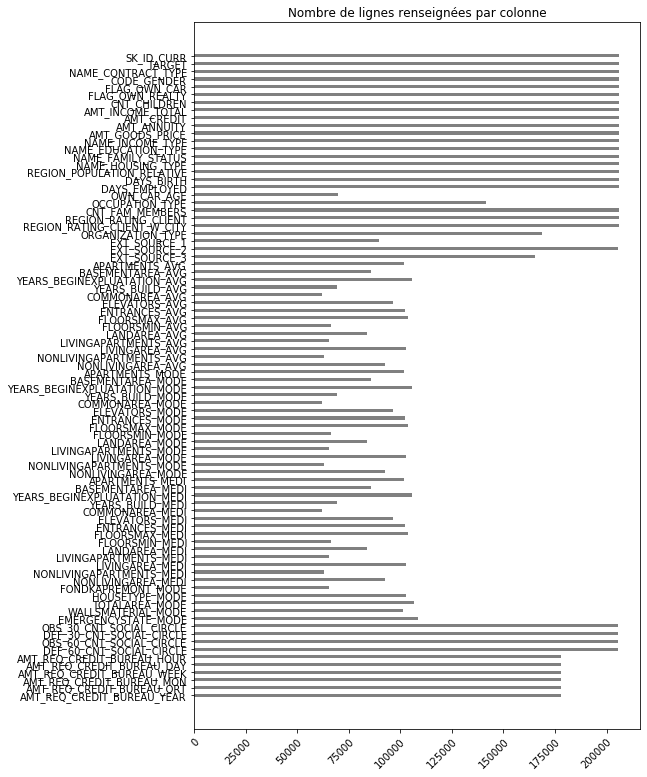

In [12]:
myDf(dfApplicationTrain).ColCountLinesChart(typeChart='barh', displayColName=True)

## Recherche de corrélations

### Requests

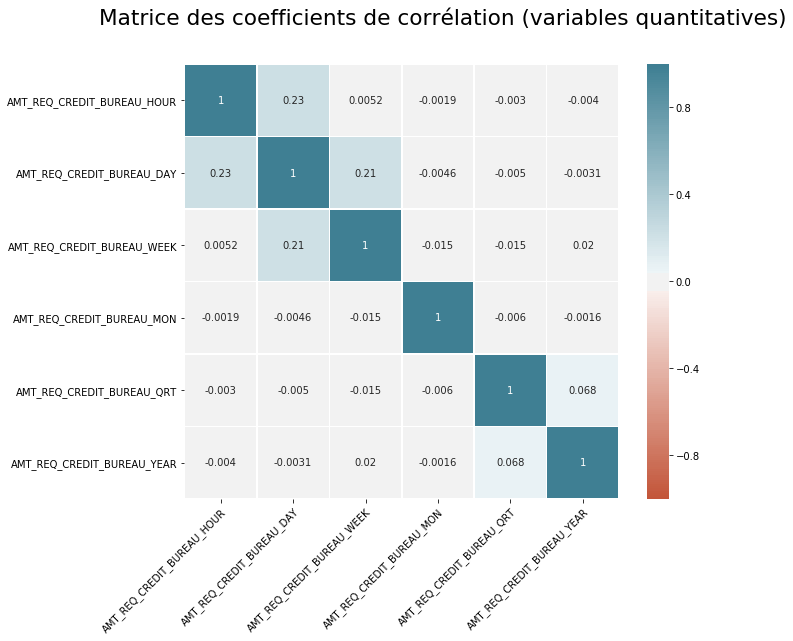

In [13]:
myDf(dfApplicationTrain).Stat(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [14]:
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_YEAR, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_QRT'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_QRT, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_MON'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_MON, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_WEEK, axis=1)
dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_DAY'] = dfApplicationTrain.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                 x.AMT_REQ_CREDIT_BUREAU_DAY, axis=1)

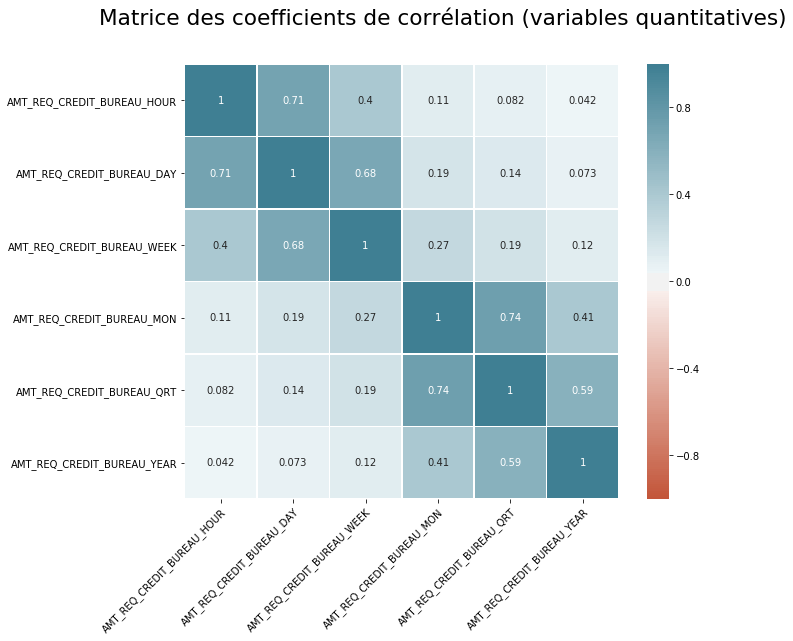

In [15]:
myDf(dfApplicationTrain).Stat(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [16]:
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_HOUR']
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_DAY']
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_MON']
del dfApplicationTrain['AMT_REQ_CREDIT_BUREAU_QRT']

### External source

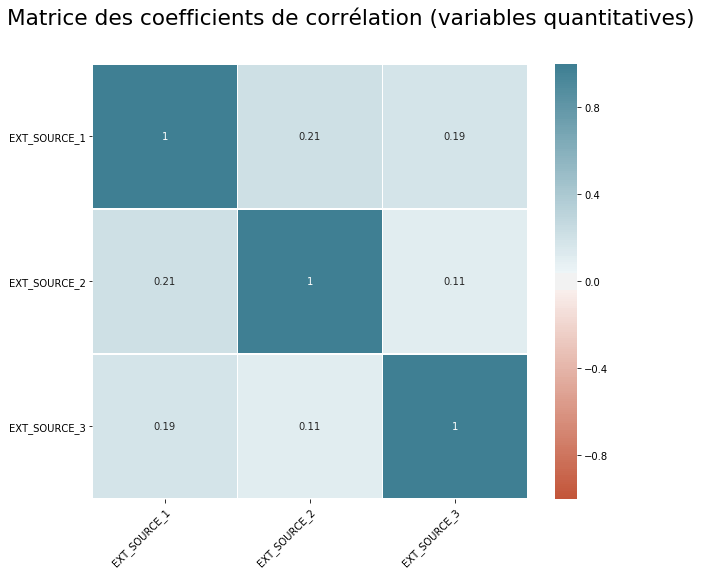

In [17]:
myDf(dfApplicationTrain).Stat(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

### External source 1 & days birth

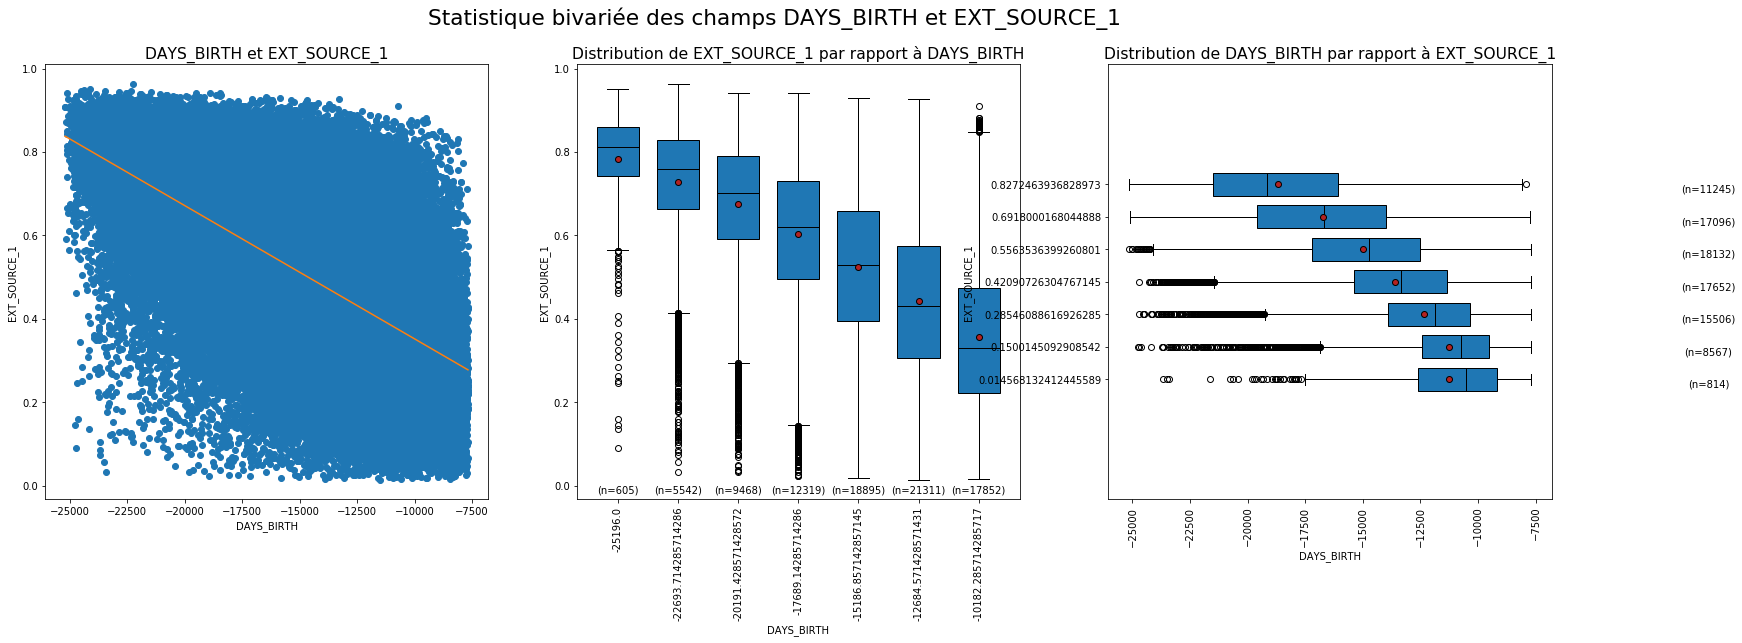

Covariance entre DAYS_BIRTH et EXT_SOURCE_1 : -497.7527370405132 
Covariance débiaisée entre DAYS_BIRTH et EXT_SOURCE_1 : -497.75828698963613 
Coefficient de correlation linéaire entre DAYS_BIRTH et EXT_SOURCE_1 : -0.5987859131817657 
Régression linéaire entre DAYS_BIRTH et EXT_SOURCE_1: y = -3.198143095463258e-05x + 0.03198865591960229
Coefficient de détermination entre DAYS_BIRTH et EXT_SOURCE_1 : 0.358544569824921 


In [18]:
myDf(dfApplicationTrain).Stat(['EXT_SOURCE_1','DAYS_BIRTH'], typeStat='biv')

In [19]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['EXT_SOURCE_1', 'DAYS_BIRTH']].isnull()).sum()

Nombre de lignes avec le champ vide:


EXT_SOURCE_1    116345
DAYS_BIRTH           0
dtype: int64

In [20]:
del dfApplicationTrain['EXT_SOURCE_1']

### Social circle

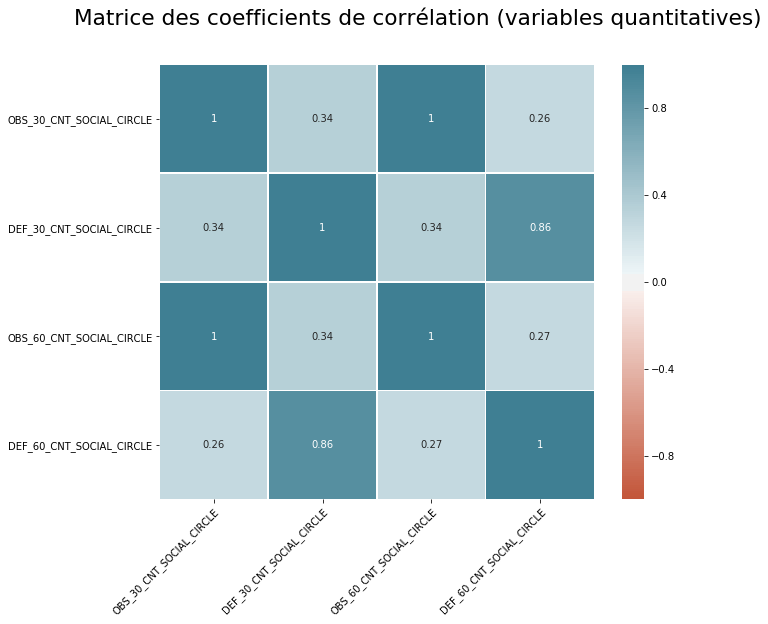

In [21]:
myDf(dfApplicationTrain).Stat(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'], typeStat='biv',typeFeature='continue',bivThresholdCorr=2)

In [22]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].isnull()).sum()

Nombre de lignes avec le champ vide:


OBS_30_CNT_SOCIAL_CIRCLE    681
DEF_30_CNT_SOCIAL_CIRCLE    681
OBS_60_CNT_SOCIAL_CIRCLE    681
DEF_60_CNT_SOCIAL_CIRCLE    681
dtype: int64

In [23]:
del dfApplicationTrain['OBS_60_CNT_SOCIAL_CIRCLE']
del dfApplicationTrain['DEF_60_CNT_SOCIAL_CIRCLE']

### Car

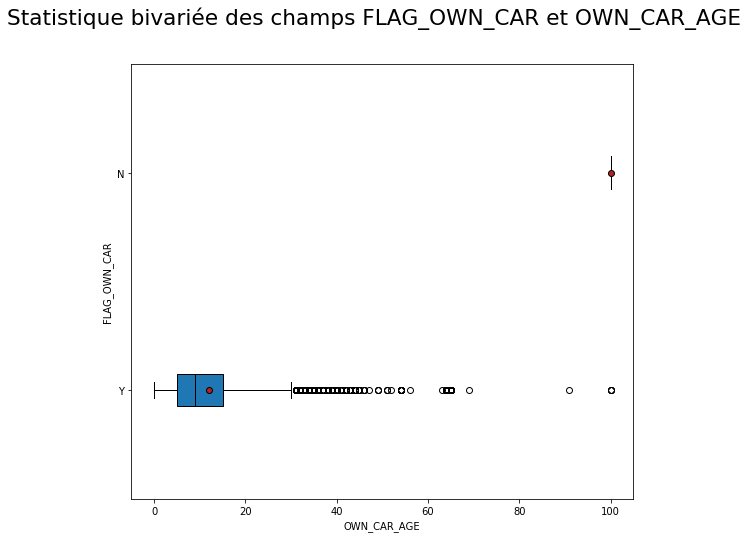

Rapport de corrélation entre FLAG_OWN_CAR et OWN_CAR_AGE: 0.9725873094051383


In [24]:
myDf(dfApplicationTrain[['FLAG_OWN_CAR','OWN_CAR_AGE']].replace(np.nan,100)).Stat(['FLAG_OWN_CAR','OWN_CAR_AGE'], typeStat='biv')

In [25]:
del dfApplicationTrain['OWN_CAR_AGE']

### Familly

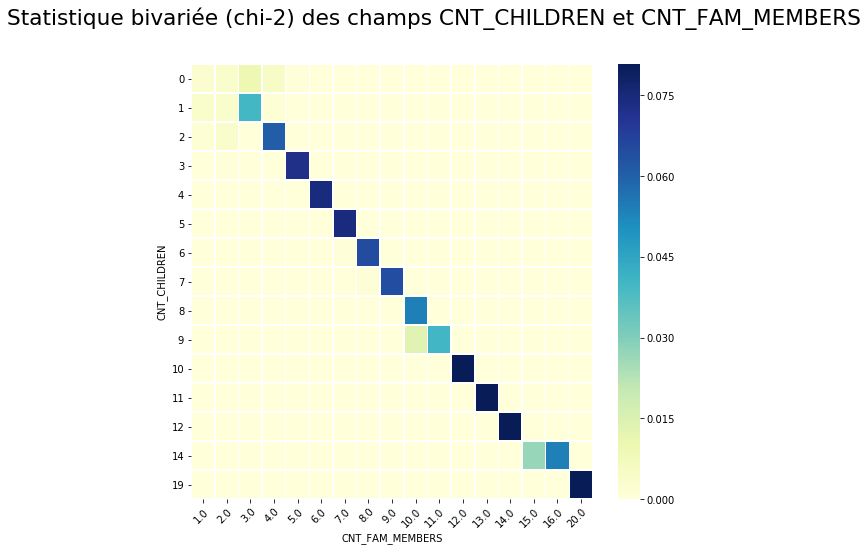

chi-2 entre CNT_CHILDREN et CNT_FAM_MEMBERS : 2551264.4820845732 
phi-2 entre CNT_CHILDREN et CNT_FAM_MEMBERS : 12.382975693270753 
coefficient T de Tschuprow entre CNT_CHILDREN et CNT_FAM_MEMBERS : 0.9096001130105066 
coefficient C de Cramer entre CNT_CHILDREN et CNT_FAM_MEMBERS : 0.9404776785256808 


In [26]:
myDf(dfApplicationTrain).Stat(['CNT_CHILDREN','CNT_FAM_MEMBERS'], typeStat='biv')

In [27]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['CNT_CHILDREN','CNT_FAM_MEMBERS']].isnull()).sum()

Nombre de lignes avec le champ vide:


CNT_CHILDREN       0
CNT_FAM_MEMBERS    2
dtype: int64

In [28]:
del dfApplicationTrain['CNT_FAM_MEMBERS']

### Amount

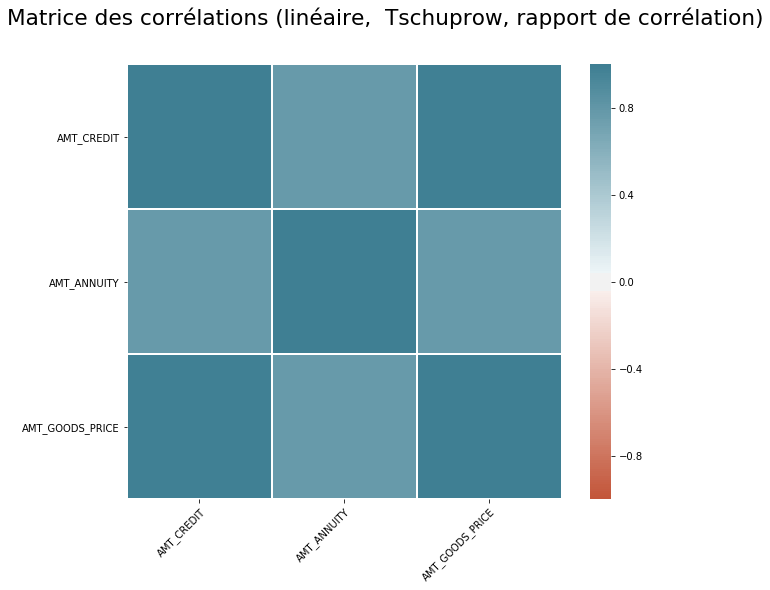

In [29]:
myDf(dfApplicationTrain).Stat(['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'], typeStat='biv', bivOnlyCorrTable=True)

In [30]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_CREDIT           0
AMT_ANNUITY          9
AMT_GOODS_PRICE    191
dtype: int64

In [31]:
del dfApplicationTrain['AMT_ANNUITY']
del dfApplicationTrain['AMT_GOODS_PRICE']

### Income / employment

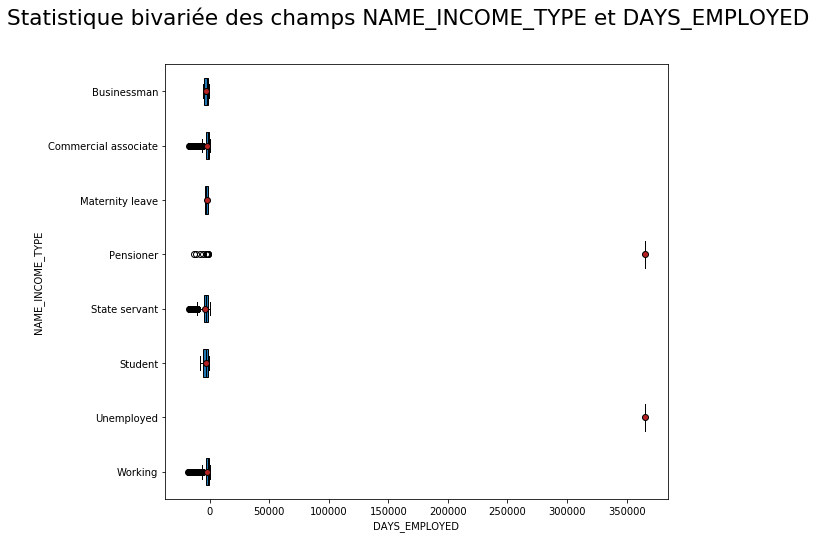

Rapport de corrélation entre NAME_INCOME_TYPE et DAYS_EMPLOYED: 0.9994483874873606


In [32]:
myDf(dfApplicationTrain).Stat(['NAME_INCOME_TYPE','DAYS_EMPLOYED'], typeStat='biv')

In [33]:
print('NAME_INCOME_TYPE avec days employed positif::')
dfApplicationTrain[dfApplicationTrain.DAYS_EMPLOYED > 0].NAME_INCOME_TYPE.unique()

NAME_INCOME_TYPE avec days employed positif::


array(['Pensioner', 'Unemployed'], dtype=object)

In [34]:
dfApplicationTrain['DAYS_EMPLOYED'] = dfApplicationTrain.apply(lambda x: np.where(x.DAYS_EMPLOYED>0,1,x.DAYS_EMPLOYED),axis=1)

In [35]:
myDf(dfApplicationTrain).Stat(['NAME_INCOME_TYPE','DAYS_EMPLOYED'], typeStat='biv')

TypeError: unhashable type: 'numpy.ndarray'

### Region rating

In [ ]:
myDf(dfApplicationTrain).Stat(['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'REGION_POPULATION_RELATIVE'], typeStat='biv', bivOnlyCorrTable=True)

In [ ]:
dfApplicationTrain[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ,'REGION_POPULATION_RELATIVE']].dtypes

In [ ]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY' ,'REGION_POPULATION_RELATIVE']].isnull()).sum()

In [ ]:
del dfApplicationTrain['REGION_RATING_CLIENT_W_CITY']
del dfApplicationTrain['REGION_POPULATION_RELATIVE']

### Gender & occupation

In [ ]:
myDf(dfApplicationTrain).Stat(['CODE_GENDER','OCCUPATION_TYPE'], typeStat='biv')

In [ ]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['CODE_GENDER', 'OCCUPATION_TYPE']].isnull()).sum()

### Champs Building

#### Corrélations enre les champs _MEDI ou _AVG ou _MODE

In [ ]:
tmp = dfApplicationTrain[['APARTMENTS_AVG','APARTMENTS_MEDI','APARTMENTS_MODE',
                            'BASEMENTAREA_AVG','BASEMENTAREA_MEDI','BASEMENTAREA_MODE',
                            'COMMONAREA_AVG','COMMONAREA_MEDI','COMMONAREA_MODE',
                            'ELEVATORS_AVG','ELEVATORS_MEDI','ELEVATORS_MODE',
                            'EMERGENCYSTATE_MODE','ENTRANCES_AVG','ENTRANCES_MEDI','ENTRANCES_MODE',
                            'FLOORSMAX_AVG','FLOORSMAX_MEDI','FLOORSMAX_MODE','FLOORSMIN_AVG',
                            'FLOORSMIN_MEDI','FLOORSMIN_MODE',
                            'FONDKAPREMONT_MODE',
                            'HOUSETYPE_MODE',
                            'LANDAREA_AVG','LANDAREA_MEDI','LANDAREA_MODE',
                            'LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI','LIVINGAPARTMENTS_MODE',
                            'LIVINGAREA_AVG','LIVINGAREA_MEDI','LIVINGAREA_MODE',
                            'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MODE',
                            'NONLIVINGAREA_AVG','NONLIVINGAREA_MEDI','NONLIVINGAREA_MODE',
                            'TOTALAREA_MODE',
                            'WALLSMATERIAL_MODE',
                            'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BEGINEXPLUATATION_MODE',
                            'YEARS_BUILD_AVG','YEARS_BUILD_MEDI','YEARS_BUILD_MODE']]
myDf(tmp).Stat(typeStat='biv', bivOnlyCorrTable=True,  multivHeatAnnot=False)

#### Sélection des champs _MEDI ou _AVG ou _MODE

In [ ]:
cols = ['APARTMENTS_MEDI',
        'BASEMENTAREA_MEDI',
        'COMMONAREA_MEDI',
        'ELEVATORS_MEDI',
        'ENTRANCES_MEDI',
        'FLOORSMAX_MEDI',
        'FLOORSMIN_MEDI',
        'LANDAREA_MEDI',
        'LIVINGAPARTMENTS_MEDI',
        'LIVINGAREA_MEDI',
        'NONLIVINGAPARTMENTS_MEDI',
        'NONLIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MEDI',
        'YEARS_BUILD_MEDI'
]
tmp = dfApplicationTrain[cols]
myDf(tmp).ColCountLines().mean()

In [ ]:
cols = ['APARTMENTS_AVG',
        'BASEMENTAREA_AVG',
        'COMMONAREA_AVG',
        'ELEVATORS_AVG',
        'ENTRANCES_AVG',
        'FLOORSMAX_AVG',
        'FLOORSMIN_AVG',
        'LANDAREA_AVG',
        'LIVINGAPARTMENTS_AVG',
        'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG',
        'NONLIVINGAREA_AVG',
        'YEARS_BEGINEXPLUATATION_AVG',
        'YEARS_BUILD_AVG']
tmp = dfApplicationTrain[cols]
myDf(tmp).ColCountLines().mean()

In [ ]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'EMERGENCYSTATE_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'FONDKAPREMONT_MODE',
'HOUSETYPE_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE'
]
tmp = dfApplicationTrain[cols]
myDf(tmp).ColCountLines().mean()

In [ ]:
del dfApplicationTrain['APARTMENTS_AVG']
del dfApplicationTrain['APARTMENTS_MEDI']
del dfApplicationTrain['BASEMENTAREA_AVG']
del dfApplicationTrain['BASEMENTAREA_MEDI']
del dfApplicationTrain['COMMONAREA_AVG']
del dfApplicationTrain['COMMONAREA_MEDI']
del dfApplicationTrain['ELEVATORS_AVG']
del dfApplicationTrain['ELEVATORS_MEDI']
del dfApplicationTrain['ENTRANCES_AVG']
del dfApplicationTrain['ENTRANCES_MEDI']
del dfApplicationTrain['FLOORSMAX_AVG']
del dfApplicationTrain['FLOORSMAX_MEDI']
del dfApplicationTrain['FLOORSMIN_AVG']
del dfApplicationTrain['FLOORSMIN_MEDI']
del dfApplicationTrain['LANDAREA_AVG']
del dfApplicationTrain['LANDAREA_MEDI']
del dfApplicationTrain['LIVINGAPARTMENTS_AVG']
del dfApplicationTrain['LIVINGAPARTMENTS_MEDI']
del dfApplicationTrain['LIVINGAREA_AVG']
del dfApplicationTrain['LIVINGAREA_MEDI']
del dfApplicationTrain['NONLIVINGAPARTMENTS_AVG']
del dfApplicationTrain['NONLIVINGAPARTMENTS_MEDI']
del dfApplicationTrain['NONLIVINGAREA_AVG']
del dfApplicationTrain['NONLIVINGAREA_MEDI']
del dfApplicationTrain['YEARS_BEGINEXPLUATATION_AVG']
del dfApplicationTrain['YEARS_BEGINEXPLUATATION_MEDI']
del dfApplicationTrain['YEARS_BUILD_AVG']
del dfApplicationTrain['YEARS_BUILD_MEDI']

#### Suppression des champs _MODE avec trop peu de valeurs différentes

In [ ]:
myDf(dfApplicationTrain[['EMERGENCYSTATE_MODE','HOUSETYPE_MODE','NONLIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE']]).Stat(typeStat='univ', statsNan=True)

In [ ]:
del dfApplicationTrain['EMERGENCYSTATE_MODE']
del dfApplicationTrain['HOUSETYPE_MODE']
del dfApplicationTrain['NONLIVINGAREA_MODE']
del dfApplicationTrain['NONLIVINGAPARTMENTS_MODE']

#### Aperçu du taux de remplissage des champs _MODE

In [ ]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'FONDKAPREMONT_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'TOTALAREA_MODE',
'WALLSMATERIAL_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BUILD_MODE'
]
myDf(dfApplicationTrain[cols]).ColCountLinesChart(typeChart='barh', displayColName=True)

#### Corrélations entre champs _MODE

In [ ]:
myDf(dfApplicationTrain[cols]).Stat(typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=False)

In [ ]:
cols = ['APARTMENTS_MODE',
'BASEMENTAREA_MODE',
'COMMONAREA_MODE',
'ELEVATORS_MODE',
'ENTRANCES_MODE',
'FLOORSMAX_MODE',
'FLOORSMIN_MODE',
'LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE',
'LIVINGAREA_MODE',
'TOTALAREA_MODE'
]
myDf(dfApplicationTrain[cols]).Stat(typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=True)

In [ ]:
del dfApplicationTrain['BASEMENTAREA_MODE']
del dfApplicationTrain['COMMONAREA_MODE']
del dfApplicationTrain['ELEVATORS_MODE']
del dfApplicationTrain['ENTRANCES_MODE']
del dfApplicationTrain['FLOORSMAX_MODE']
del dfApplicationTrain['FLOORSMIN_MODE']
del dfApplicationTrain['LANDAREA_MODE']
del dfApplicationTrain['LIVINGAPARTMENTS_MODE']
del dfApplicationTrain['LIVINGAREA_MODE']
del dfApplicationTrain['TOTALAREA_MODE']

In [ ]:
myDf(dfApplicationTrain).Stat(['APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE'],typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=True)

In [ ]:
print('Nombre de lignes avec le champ vide:')
(dfApplicationTrain[['APARTMENTS_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE']].isnull()).sum()

In [ ]:
del dfApplicationTrain['YEARS_BUILD_MODE']

In [ ]:
cols = ['APARTMENTS_MODE',
'YEARS_BEGINEXPLUATATION_MODE',
'FONDKAPREMONT_MODE',
'WALLSMATERIAL_MODE'
]
myDf(dfApplicationTrain[cols]).Stat(typeStat='univ-biv', statsNan=True, bivOnlyCorrTable=True, multivHeatAnnot=True)

In [ ]:
del dfApplicationTrain['FONDKAPREMONT_MODE']

### Matrice des corrélations des variables restantes

In [ ]:
myDf(dfApplicationTrain).Stat(exclCol=['SK_ID_CURR'], typeStat='biv', bivOnlyCorrTable=True, multivHeatAnnot=False)

## Statistique univariée

In [ ]:
myDf(dfApplicationTrain).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_CURR'])

## Gestion des outliers

In [37]:
dfApplicationTrain = dfApplicationTrain[(dfApplicationTrain.AMT_REQ_CREDIT_BUREAU_YEAR < 50) | dfApplicationTrain.AMT_REQ_CREDIT_BUREAU_YEAR.isnull()]
dfApplicationTrain = dfApplicationTrain[(dfApplicationTrain.OBS_30_CNT_SOCIAL_CIRCLE < 50) | dfApplicationTrain.OBS_30_CNT_SOCIAL_CIRCLE.isnull()]

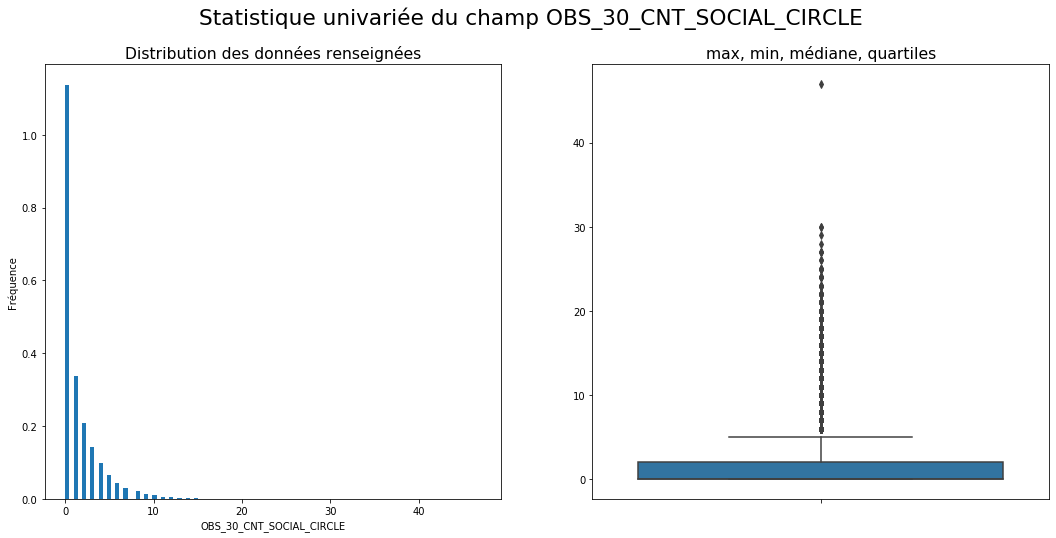

Mesures de position
 - Moyenne: 1.42
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 2.31
 - Min: 0.0
 - Q25: 0.0
 - Q75: 2.0
 - Max: 47.0
Mesures de forme
 - Skewness (asymétrie): 2.59
 - Kurtosis (applatissement): 10.17


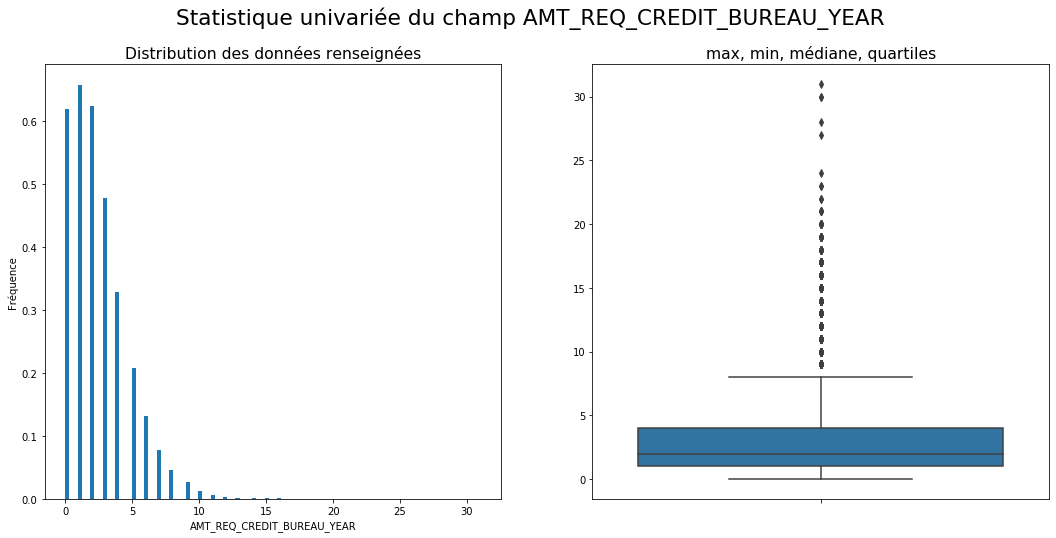

Mesures de position
 - Moyenne: 2.47
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 2.23
 - Min: 0.0
 - Q25: 1.0
 - Q75: 4.0
 - Max: 31.0
Mesures de forme
 - Skewness (asymétrie): 1.41
 - Kurtosis (applatissement): 3.82


In [93]:
myDf(dfApplicationTrain).Stat(['OBS_30_CNT_SOCIAL_CIRCLE','AMT_REQ_CREDIT_BUREAU_YEAR'], typeStat='univ')

## Encoding des variables catégorielles

In [39]:
categorical_ix = dfApplicationTrain.select_dtypes(include=['object', 'bool']).columns
dfApplicationTrain[categorical_ix] = dfApplicationTrain[categorical_ix].replace(np.nan, 'missing')

In [40]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
dfApplicationTrain['NAME_CONTRACT_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['NAME_CONTRACT_TYPE']])
dfApplicationTrain['CODE_GENDER'] = ordinal_encoder.fit_transform(dfApplicationTrain[['CODE_GENDER']])
dfApplicationTrain['FLAG_OWN_CAR'] = ordinal_encoder.fit_transform(dfApplicationTrain[['FLAG_OWN_CAR']])
dfApplicationTrain['FLAG_OWN_REALTY'] = ordinal_encoder.fit_transform(dfApplicationTrain[['FLAG_OWN_REALTY']])
dfApplicationTrain['NAME_INCOME_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['NAME_INCOME_TYPE']])
dfApplicationTrain['NAME_HOUSING_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['NAME_HOUSING_TYPE']])
dfApplicationTrain['OCCUPATION_TYPE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['OCCUPATION_TYPE']])
dfApplicationTrain['WALLSMATERIAL_MODE'] = ordinal_encoder.fit_transform(dfApplicationTrain[['WALLSMATERIAL_MODE']])

In [41]:
dfApplicationTrain['NAME_EDUCATION_TYPE_ENCODED'] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Academic degree'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Higher education'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 2
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Incomplete higher'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 3
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Secondary / secondary special'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 4
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_EDUCATION_TYPE == 'Lower secondary'].index, "NAME_EDUCATION_TYPE_ENCODED"] = 5

In [42]:
dfApplicationTrain['MARRIED_FLAG'] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
dfApplicationTrain.at[dfApplicationTrain[dfApplicationTrain.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1

### Conservation des variables numériques uniquement

In [43]:
col_type = dfApplicationTrain.dtypes
col_type = col_type[(col_type == 'int64') | (col_type == 'uint8') | (col_type == 'float64')]
dfApplicationTrain = dfApplicationTrain[col_type.index]

# Exploration de PreviousApplication

## Statistiques par current application

In [57]:
nbWithPrevious = dfApplicationTrain[dfApplicationTrain.SK_ID_CURR.isin(dfPreviousApplication.SK_ID_CURR)].shape[0]
nbWithoutPrevious = dfApplicationTrain[~dfApplicationTrain.SK_ID_CURR.isin(dfPreviousApplication.SK_ID_CURR)].shape[0]
print("{} loans sans previous ({}%)".format(nbWithoutPrevious, np.round(100 * nbWithoutPrevious / (nbWithPrevious + nbWithoutPrevious), 1)))

11307 loans sans previous (5.5%)


Text(0.5, 1.0, 'Stat nb previous application at credit bureau')

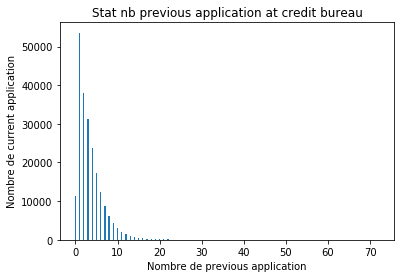

In [58]:
distrib_nb_previous = dfApplicationTrain.merge(dfPreviousApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')['SK_ID_CURR'].value_counts().value_counts()
distrib_nb_previous[0] = nbWithoutPrevious
tmp = pd.DataFrame({'nb_previous': pd.Series(distrib_nb_previous.index),
                   'nb_application': distrib_nb_previous.reset_index(drop=True)}).sort_values('nb_previous')
plt.bar(pd.Series(distrib_nb_previous.index), distrib_nb_previous.reset_index(drop=True), width=0.3)
plt.xlabel('Nombre de previous application')
plt.ylabel('Nombre de current application')
plt.title("Stat nb previous application at credit bureau")

## Suppression de lignes non pertinentes

In [162]:
dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]

In [163]:
dfPreviousApplication.NAME_CONTRACT_STATUS.value_counts()

Approved        592924
Canceled        173427
Refused         158843
Unused offer     15225
Name: NAME_CONTRACT_STATUS, dtype: int64

In [164]:
dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]

## Suppression de variables non pertinentes

### Fonctionnellement inintéressantes

In [165]:
del dfPreviousApplication['FLAG_LAST_APPL_PER_CONTRACT'] # Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
del dfPreviousApplication['NFLAG_LAST_APPL_IN_DAY'] # Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice

del dfPreviousApplication['NAME_TYPE_SUITE'] # Who accompanied client when applying for the previous application
del dfPreviousApplication['WEEKDAY_APPR_PROCESS_START'] #On which day of the week did the client apply for the loan
del dfPreviousApplication['HOUR_APPR_PROCESS_START'] #Approximately at what hour did the client apply for the loan
del dfPreviousApplication['NAME_CLIENT_TYPE'] #Was the client old or new client when applying for the previous application
del dfPreviousApplication['SELLERPLACE_AREA'] #Selling area of seller place of the previous application

### Trop de valeurs manquantes

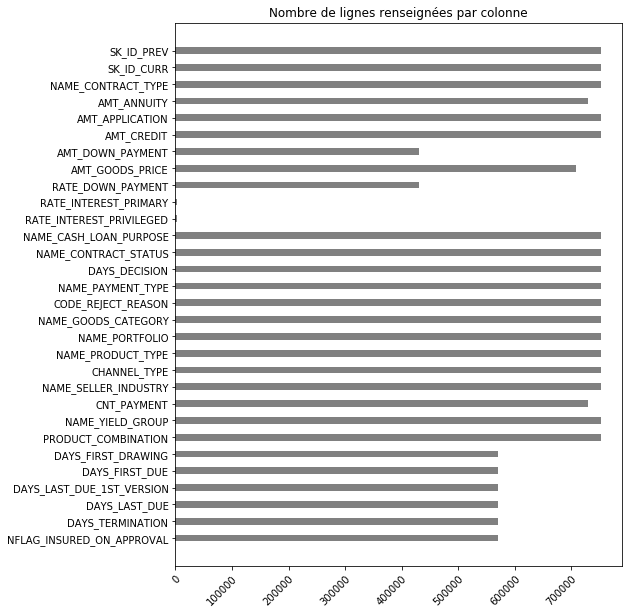

In [166]:
myDf(dfPreviousApplication).ColCountLinesChart(typeChart='barh', displayColName=True)

In [167]:
del dfPreviousApplication['RATE_INTEREST_PRIMARY']
del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']

### Trop de valeurs identiques

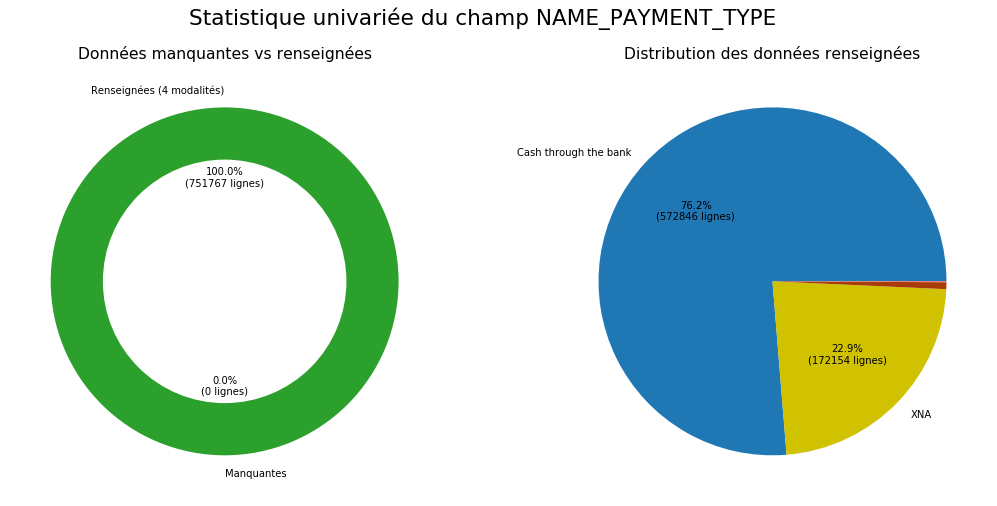

In [168]:
myDf(dfPreviousApplication).Stat(['NAME_PAYMENT_TYPE'],typeStat='univ', statsNan=True)

In [169]:
del dfPreviousApplication['NAME_PAYMENT_TYPE']

## Recherche de corrélations

### Champs days

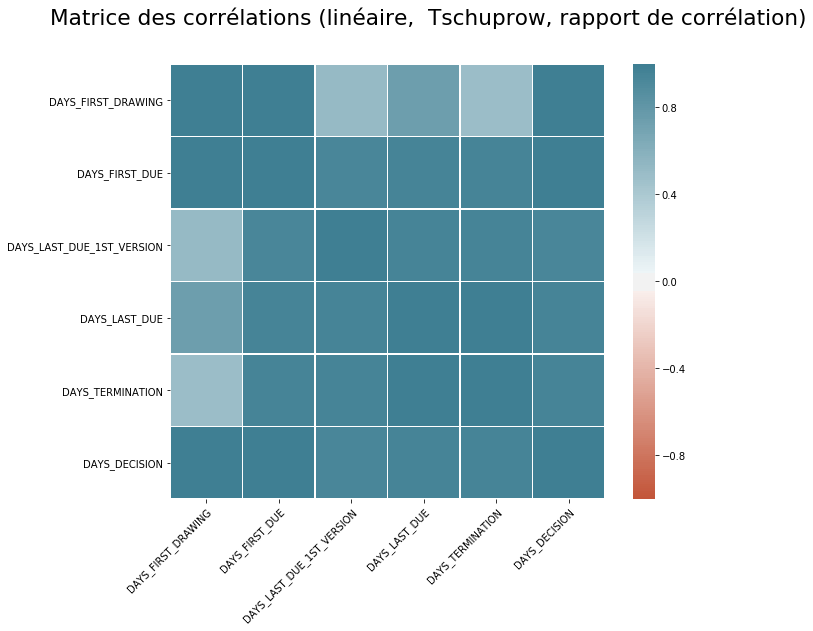

In [170]:
myDf(dfPreviousApplication.replace(365243,np.nan)).Stat(['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION','DAYS_DECISION'], bivOnlyCorrTable=True, typeStat='biv')

In [171]:
del dfPreviousApplication['DAYS_FIRST_DRAWING']
del dfPreviousApplication['DAYS_FIRST_DUE']
del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
del dfPreviousApplication['DAYS_LAST_DUE']
del dfPreviousApplication['DAYS_TERMINATION']

### Montants

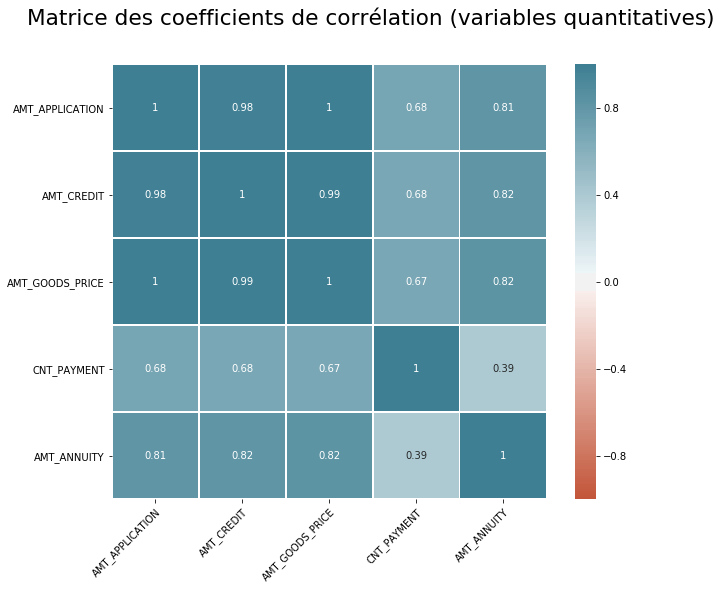

In [172]:
myDf(dfPreviousApplication).Stat(['AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','CNT_PAYMENT','AMT_ANNUITY'], typeStat='biv', bivThresholdCorr=2) 

In [173]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE','CNT_PAYMENT','AMT_ANNUITY']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_APPLICATION        0
AMT_CREDIT             1
AMT_GOODS_PRICE    43154
CNT_PAYMENT        23065
AMT_ANNUITY        23065
dtype: int64

In [174]:
del dfPreviousApplication['AMT_APPLICATION']
del dfPreviousApplication['AMT_GOODS_PRICE']
del dfPreviousApplication['AMT_ANNUITY']
del dfPreviousApplication['CNT_PAYMENT']

### Contract type portfolio name

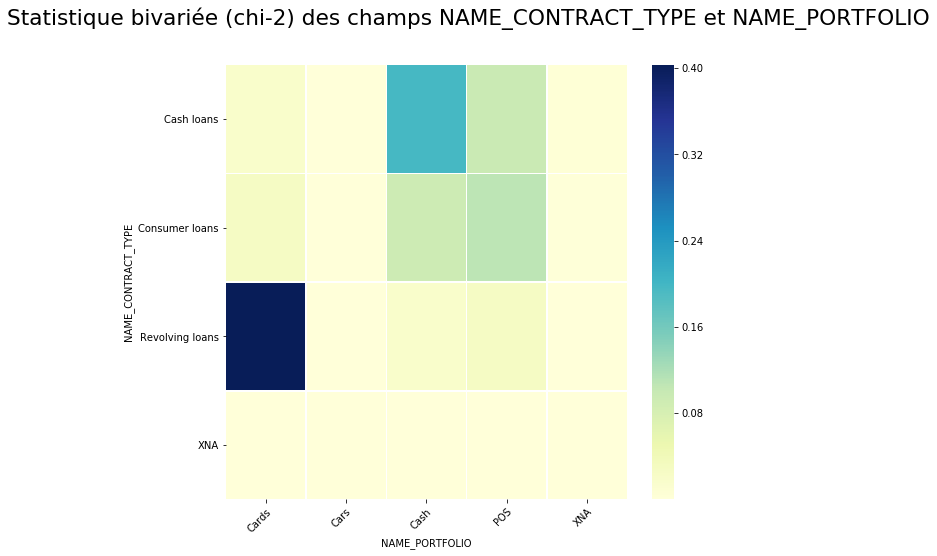

chi-2 entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 1466814.2678104152 
phi-2 entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 1.9511554348759859 
coefficient T de Tschuprow entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 0.7504998719375147 
coefficient C de Cramer entre NAME_CONTRACT_TYPE et NAME_PORTFOLIO : 0.806464596221472 


In [175]:
myDf(dfPreviousApplication).Stat(['NAME_CONTRACT_TYPE','NAME_PORTFOLIO'], typeStat='biv')

In [176]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_CONTRACT_TYPE','NAME_PORTFOLIO']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_CONTRACT_TYPE    0
NAME_PORTFOLIO        0
dtype: int64

In [177]:
del dfPreviousApplication['NAME_PORTFOLIO']

### Contract status, code reject reason

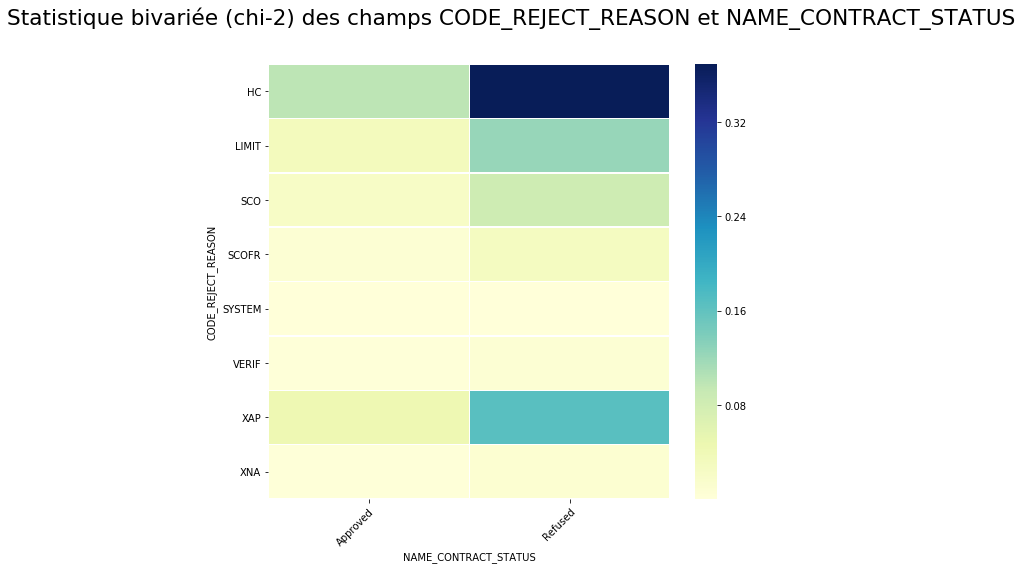

chi-2 entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 751737.0618980417 
phi-2 entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.9999601763552294 
coefficient T de Tschuprow entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.6147759112768799 
coefficient C de Cramer entre CODE_REJECT_REASON et NAME_CONTRACT_STATUS : 0.9999800879793704 


In [178]:
myDf(dfPreviousApplication.replace(np.nan,'NAN')).Stat(['NAME_CONTRACT_STATUS','CODE_REJECT_REASON'], typeStat='biv')

In [179]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','CODE_REJECT_REASON']].replace(np.nan,'NAN').groupby(['NAME_CONTRACT_STATUS','CODE_REJECT_REASON']).size()

NAME_CONTRACT_STATUS  CODE_REJECT_REASON
Approved              XAP                   592919
                      XNA                        5
Refused               HC                     94311
                      LIMIT                  31405
                      SCO                    21661
                      SCOFR                   7054
                      SYSTEM                   115
                      VERIF                   2002
                      XNA                     2295
dtype: int64

In [180]:
del dfPreviousApplication['CODE_REJECT_REASON']

### Contract_type, channel_type, flag_insurance

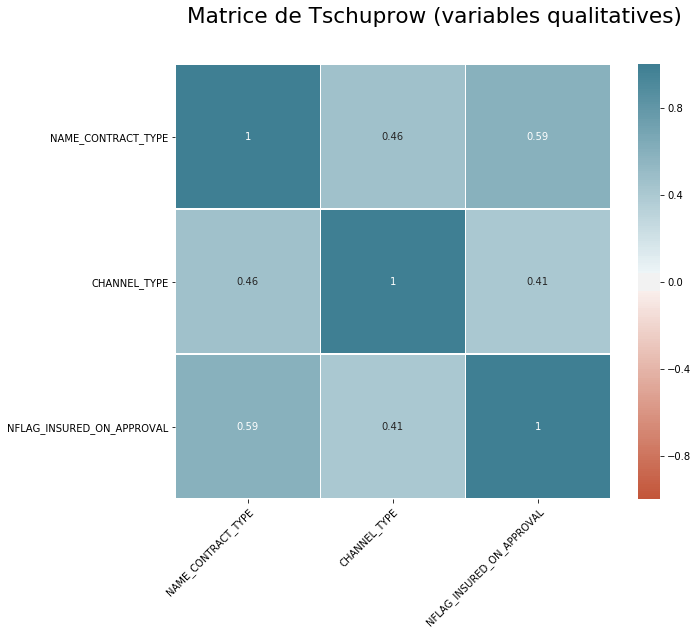

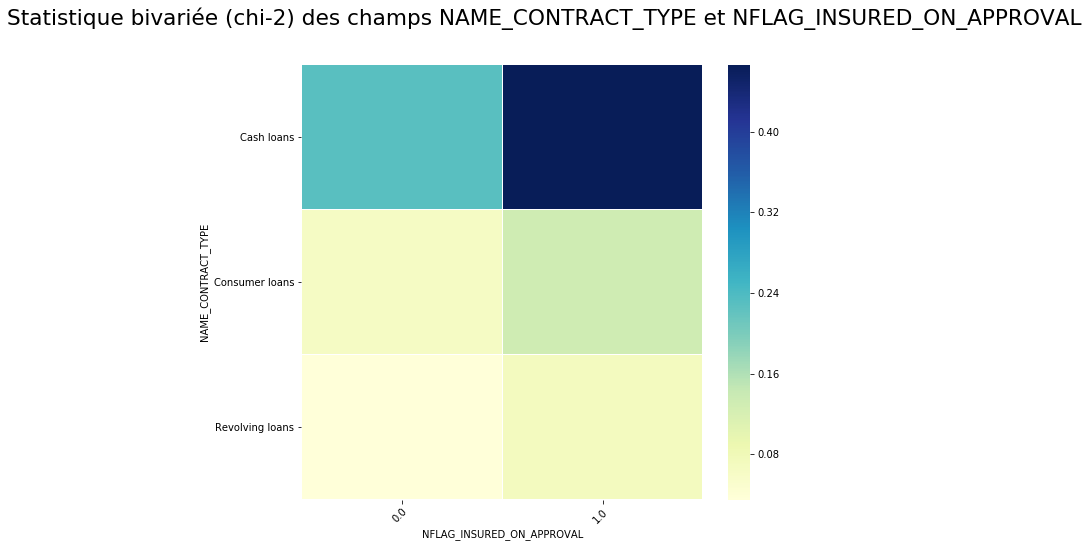

chi-2 entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 236064.2982536396 
phi-2 entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.413736332899799 
coefficient T de Tschuprow entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.5408842451178466 
coefficient C de Cramer entre NAME_CONTRACT_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.643223392687019 


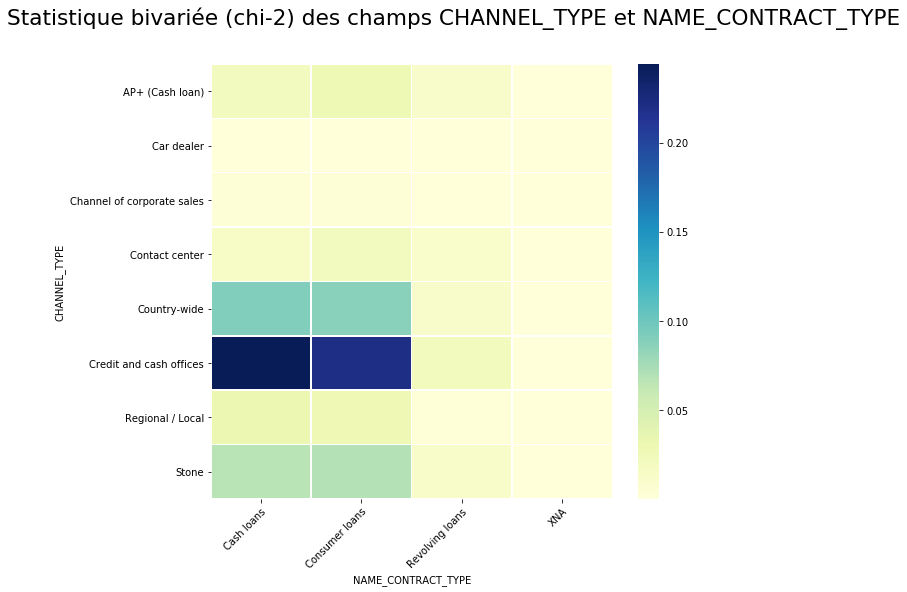

chi-2 entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 594442.1050454302 
phi-2 entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.7907265217087611 
coefficient T de Tschuprow entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.4153921921761776 
coefficient C de Cramer entre CHANNEL_TYPE et NAME_CONTRACT_TYPE : 0.5133960530002677 


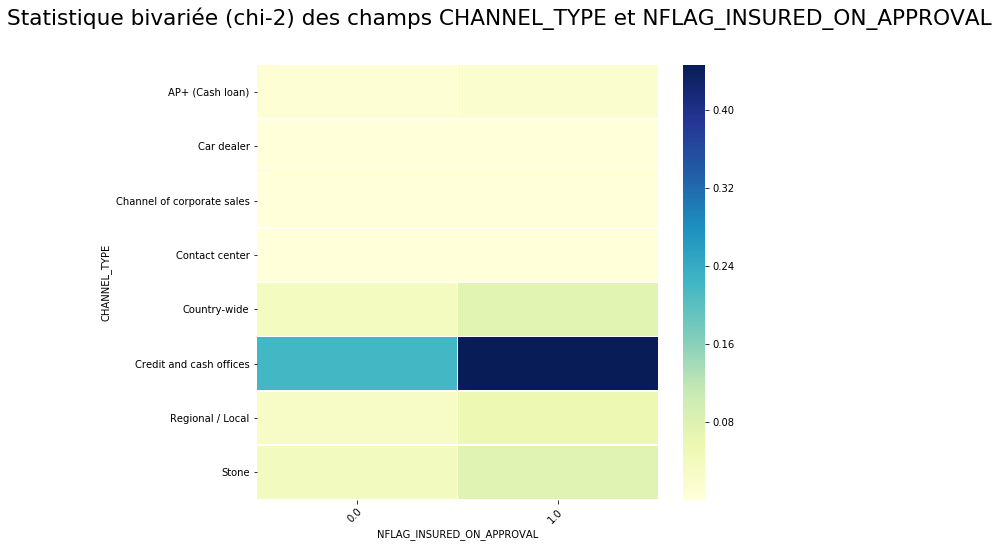

chi-2 entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 144141.78084831272 
phi-2 entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.2526290178862653 
coefficient T de Tschuprow entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.3090061384701296 
coefficient C de Cramer entre CHANNEL_TYPE et NFLAG_INSURED_ON_APPROVAL : 0.5026221422562532 


In [181]:
myDf(dfPreviousApplication).Stat(['NAME_CONTRACT_TYPE','CHANNEL_TYPE','NFLAG_INSURED_ON_APPROVAL'], typeStat='biv')

C'est le flag insurance qui est le moins souvent renseigné

In [182]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_CONTRACT_TYPE','CHANNEL_TYPE','NFLAG_INSURED_ON_APPROVAL']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_CONTRACT_TYPE                0
CHANNEL_TYPE                      0
NFLAG_INSURED_ON_APPROVAL    181200
dtype: int64

Mais c'est surtout sur les crédit refusés que le flag insurance n'est pas renseigné

In [183]:
dfPreviousApplication[['NAME_CONTRACT_STATUS','NFLAG_INSURED_ON_APPROVAL']].replace(np.nan, -99).groupby(['NAME_CONTRACT_STATUS','NFLAG_INSURED_ON_APPROVAL']).size()

NAME_CONTRACT_STATUS  NFLAG_INSURED_ON_APPROVAL
Approved              -99.0                         22357
                       0.0                         381904
                       1.0                         188663
Refused               -99.0                        158843
dtype: int64

De plus, la majeur partie des SK_ID_CURR ont au moins un SK_ID_PREV avec le flag insurance renseigné

In [184]:
NB_SK_ID_CURR_WITH_INSURANCE_FLAG = len(dfPreviousApplication[~dfPreviousApplication.NFLAG_INSURED_ON_APPROVAL.isnull()].SK_ID_CURR.unique())
NB_SK_ID_CURR = len(dfPreviousApplication.SK_ID_CURR.unique())
print("{} SK_ID_CURR sur {} n'ont aucune ligne avec un flag insurrance renseigné".format(NB_SK_ID_CURR-NB_SK_ID_CURR_WITH_INSURANCE_FLAG,NB_SK_ID_CURR))

598 SK_ID_CURR sur 194723 n'ont aucune ligne avec un flag insurrance renseigné


Donc on conserve le flag insurance car c'est un flag

In [185]:
del dfPreviousApplication['CHANNEL_TYPE']
del dfPreviousApplication['NAME_CONTRACT_TYPE']

### Name yield group et product combination

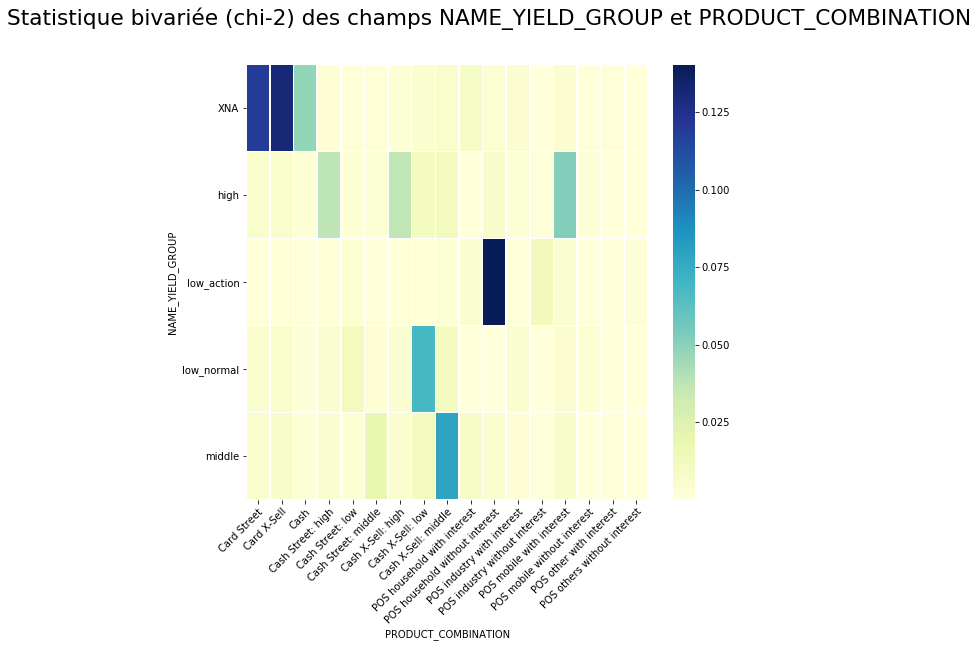

chi-2 entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 1774135.8733116162 
phi-2 entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 2.360010952208272 
coefficient T de Tschuprow entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 0.5431402848491668 
coefficient C de Cramer entre NAME_YIELD_GROUP et PRODUCT_COMBINATION : 0.7681163571048777 


In [186]:
myDf(dfPreviousApplication).Stat(['NAME_YIELD_GROUP','PRODUCT_COMBINATION'], typeStat='biv')

In [187]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_YIELD_GROUP','PRODUCT_COMBINATION']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_YIELD_GROUP        0
PRODUCT_COMBINATION    18
dtype: int64

In [188]:
NB_SK_ID_CURR_WITH_YIELD_GROUP = len(dfPreviousApplication[~dfPreviousApplication.NAME_YIELD_GROUP.isnull()].SK_ID_CURR.unique())
NB_SK_ID_CURR = len(dfPreviousApplication.SK_ID_CURR.unique())
print("{} SK_ID_CURR sur {} n'ont aucune ligne avec un yield group renseigné".format(NB_SK_ID_CURR-NB_SK_ID_CURR_WITH_YIELD_GROUP,NB_SK_ID_CURR))

0 SK_ID_CURR sur 194723 n'ont aucune ligne avec un yield group renseigné


On conserve NAME_YIELD_GROUP car c'est une variable ordonnable

In [189]:
del dfPreviousApplication['PRODUCT_COMBINATION']

### Name seller industry, name goods category

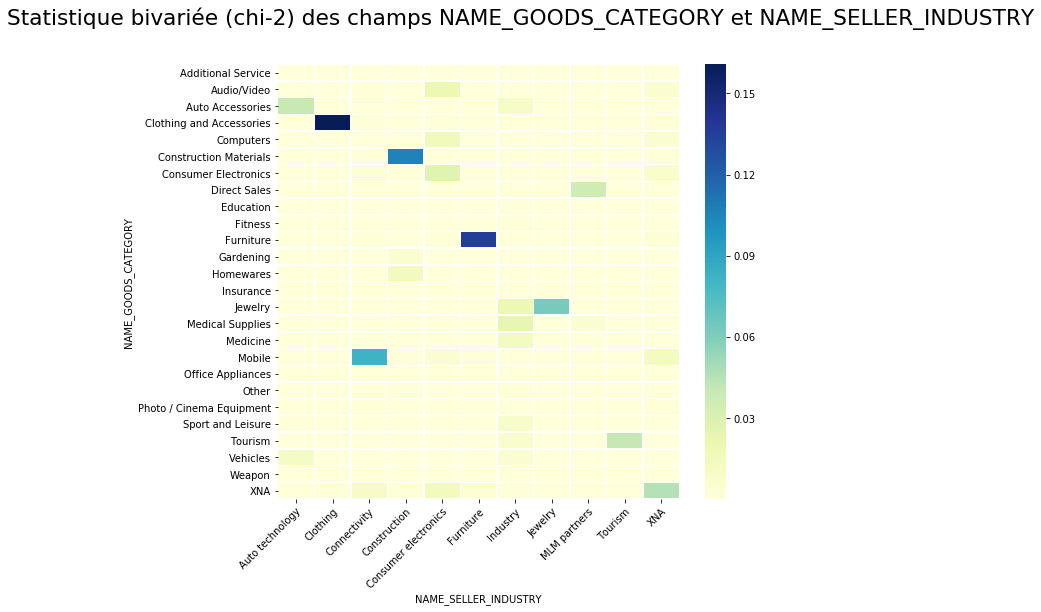

chi-2 entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 3937006.232203405 
phi-2 entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 5.237003263249657 
coefficient T de Tschuprow entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 0.5755146987802013 
coefficient C de Cramer entre NAME_GOODS_CATEGORY et NAME_SELLER_INDUSTRY : 0.7236714215201301 


In [190]:
myDf(dfPreviousApplication).Stat(['NAME_SELLER_INDUSTRY','NAME_GOODS_CATEGORY'], typeStat='biv')

In [191]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['NAME_SELLER_INDUSTRY','NAME_GOODS_CATEGORY']].isnull()).sum()

Nombre de lignes avec le champ vide:


NAME_SELLER_INDUSTRY    0
NAME_GOODS_CATEGORY     0
dtype: int64

In [192]:
del dfPreviousApplication['NAME_GOODS_CATEGORY']

### Down payment

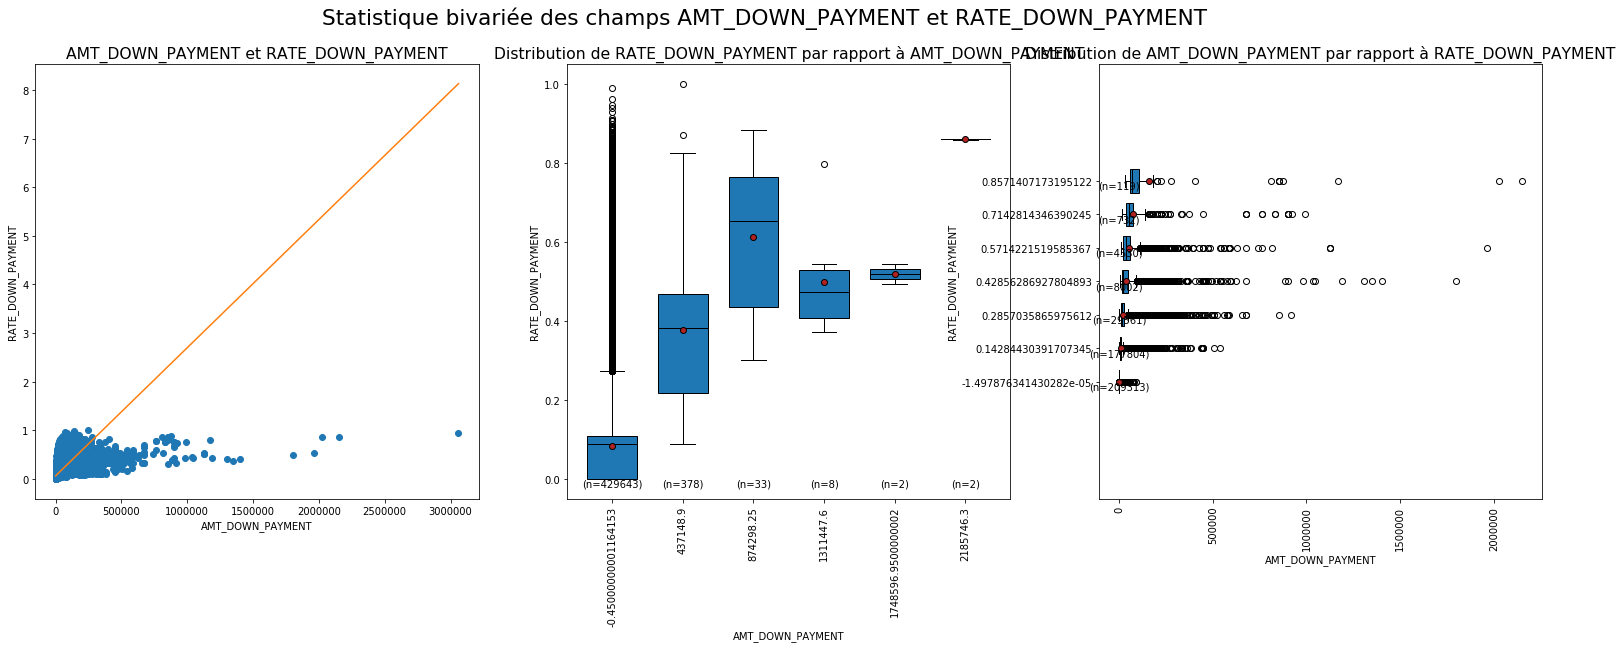

Covariance entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 1064.6146271110456 
Covariance débiaisée entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 1064.61710257906 
Coefficient de correlation linéaire entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 0.488361814707292 
Régression linéaire entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT: y = 2.6355708756480434e-06x + 0.06477540891083736
Coefficient de détermination entre AMT_DOWN_PAYMENT et RATE_DOWN_PAYMENT : 0.2384972620641994 


In [193]:
myDf(dfPreviousApplication).Stat(['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT'], typeStat='biv')

In [194]:
print('Nombre de lignes avec le champ vide:')
(dfPreviousApplication[['AMT_DOWN_PAYMENT','RATE_DOWN_PAYMENT']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_DOWN_PAYMENT     321700
RATE_DOWN_PAYMENT    321700
dtype: int64

In [195]:
del dfPreviousApplication['AMT_DOWN_PAYMENT']

### Matrice des corrélations des variables restantes

/home/pierre/Documents/openclassrooms/Projet_7/Git/credit_scoring/myTools.py:1477: RuntimeWarning: invalid value encountered in double_scalars
  tschuprow = math.sqrt(phi2 / math.sqrt((r-1)*(c-1)))
/home/pierre/Documents/openclassrooms/Projet_7/Git/credit_scoring/myTools.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  cramer = math.sqrt(phi2/(min(r,c)-1))


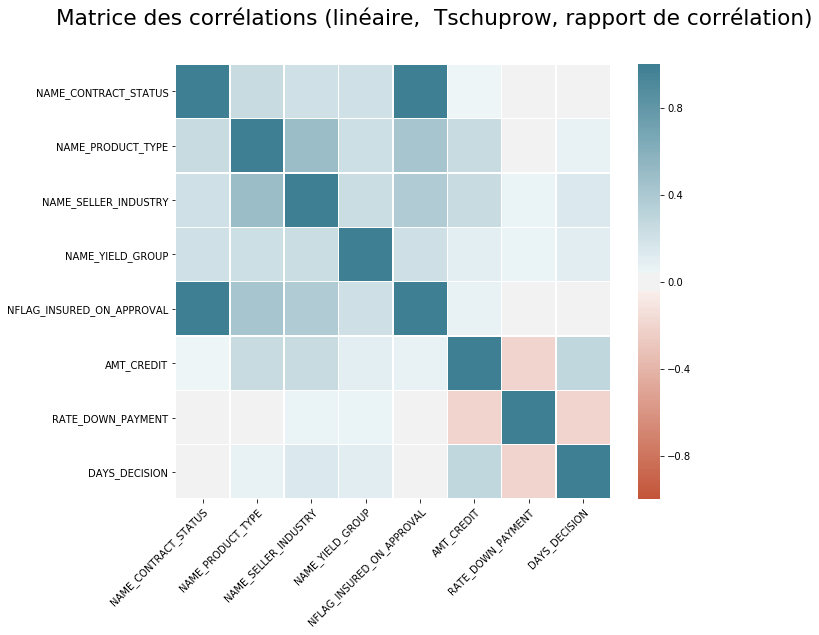

In [196]:
myDf(dfPreviousApplication).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='biv', bivOnlyCorrTable=True)

## Statistique univariée

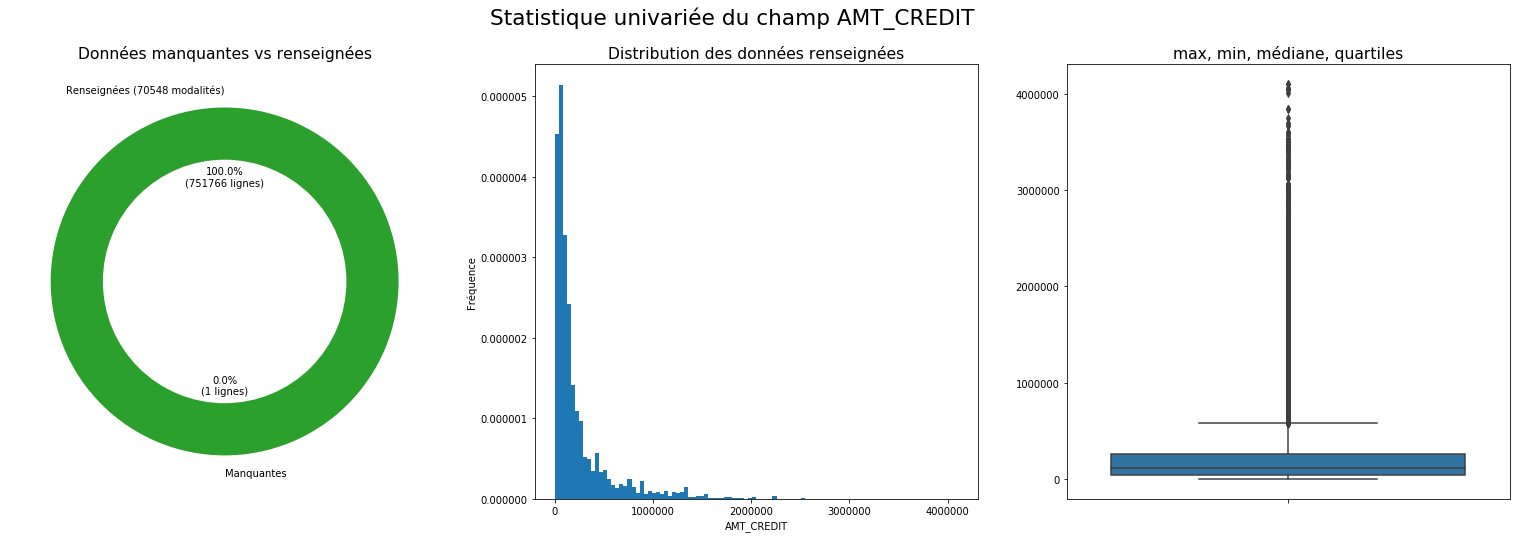

Mesures de position
 - Moyenne: 237266.59
 - Médiane: 111919.5
Mesures de dispertion
 - Ecart type: 335157.27
 - Min: 0.0
 - Q25: 47970.0
 - Q75: 260896.5
 - Max: 4104351.0
Mesures de forme
 - Skewness (asymétrie): 3.04
 - Kurtosis (applatissement): 12.38


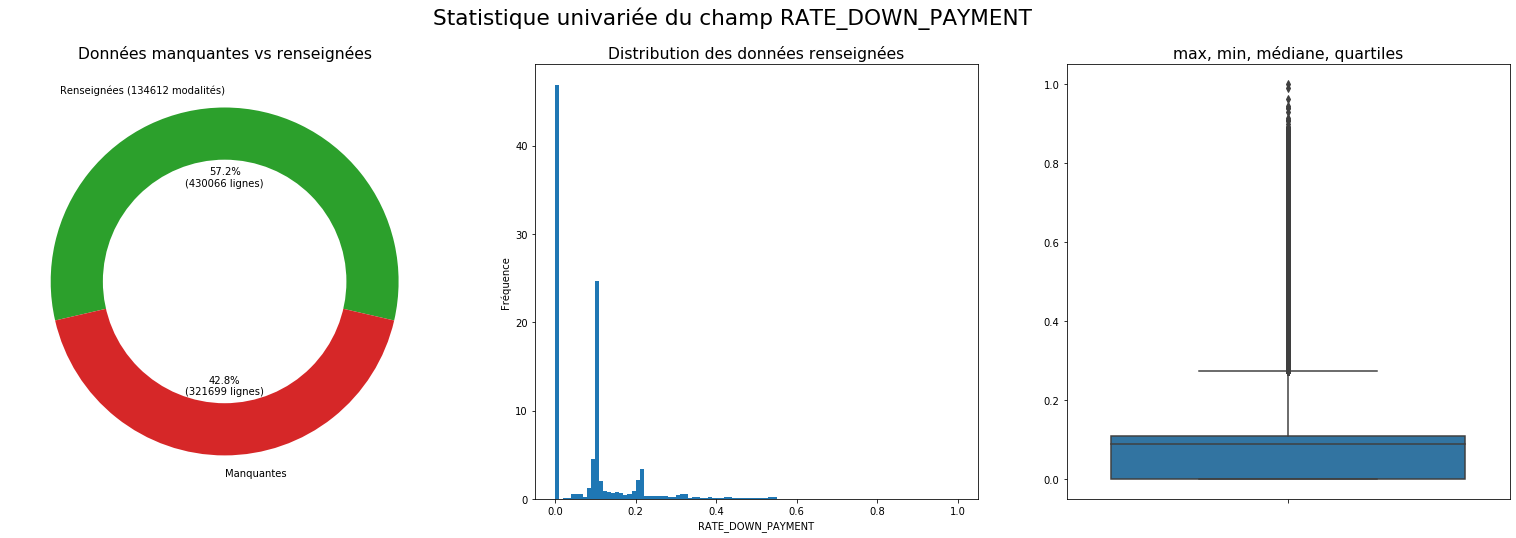

Mesures de position
 - Moyenne: 0.08
 - Médiane: 0.09
Mesures de dispertion
 - Ecart type: 0.11
 - Min: -0.0
 - Q25: 0.0
 - Q75: 0.11
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.07
 - Kurtosis (applatissement): 6.03


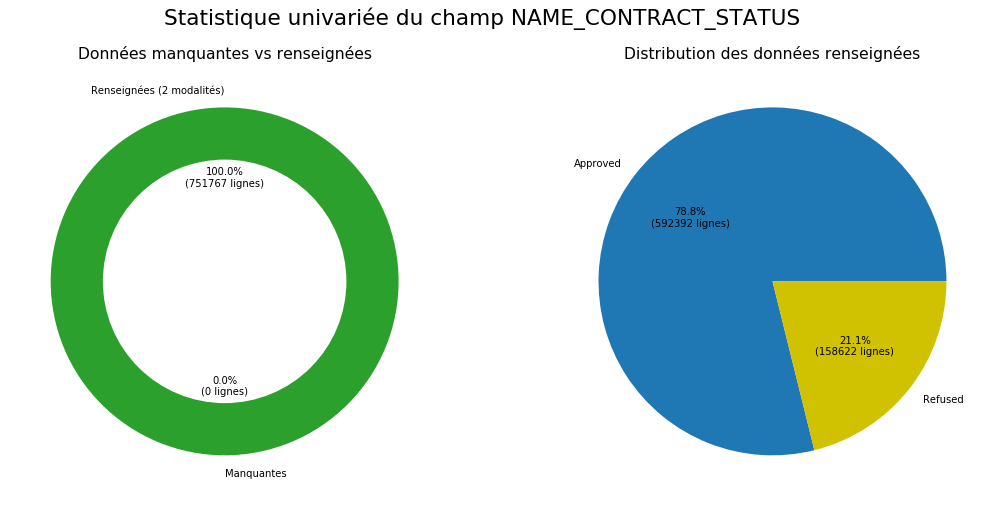

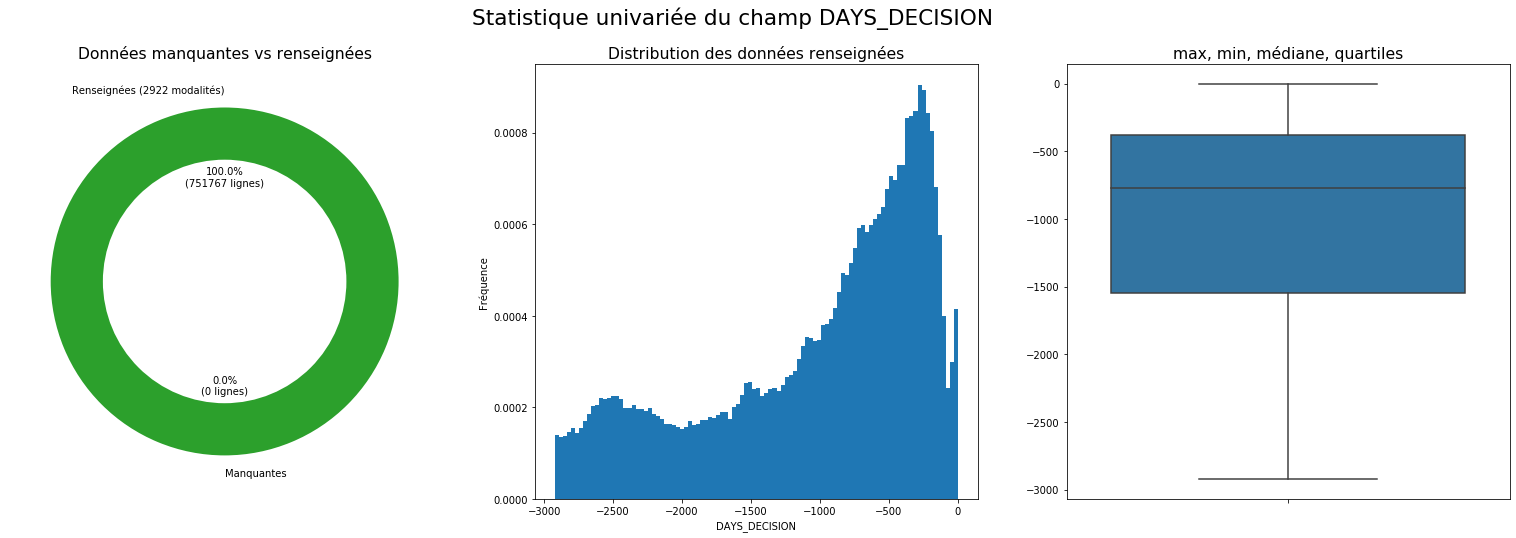

Mesures de position
 - Moyenne: -1030.38
 - Médiane: -773.0
Mesures de dispertion
 - Ecart type: 794.53
 - Min: -2922
 - Q25: -1549.0
 - Q75: -380.0
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -0.8
 - Kurtosis (applatissement): -0.55


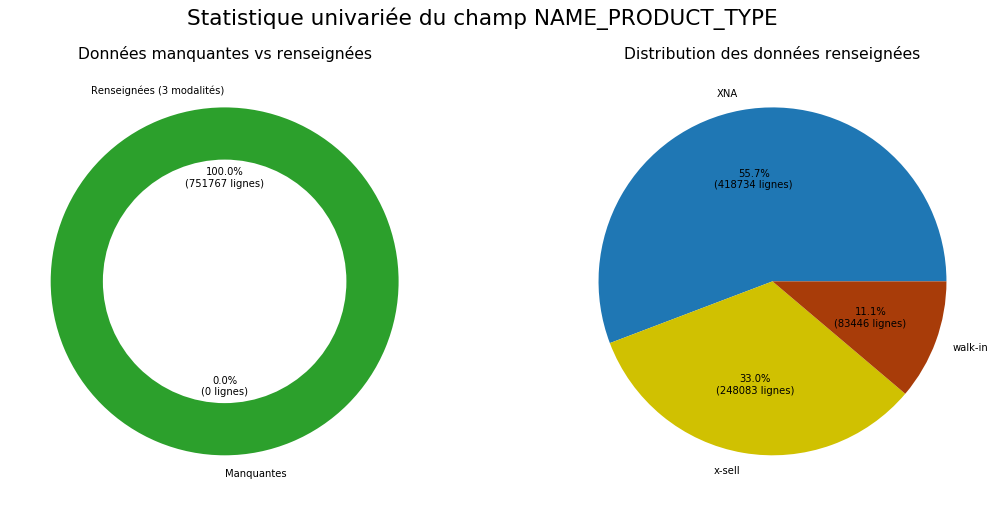

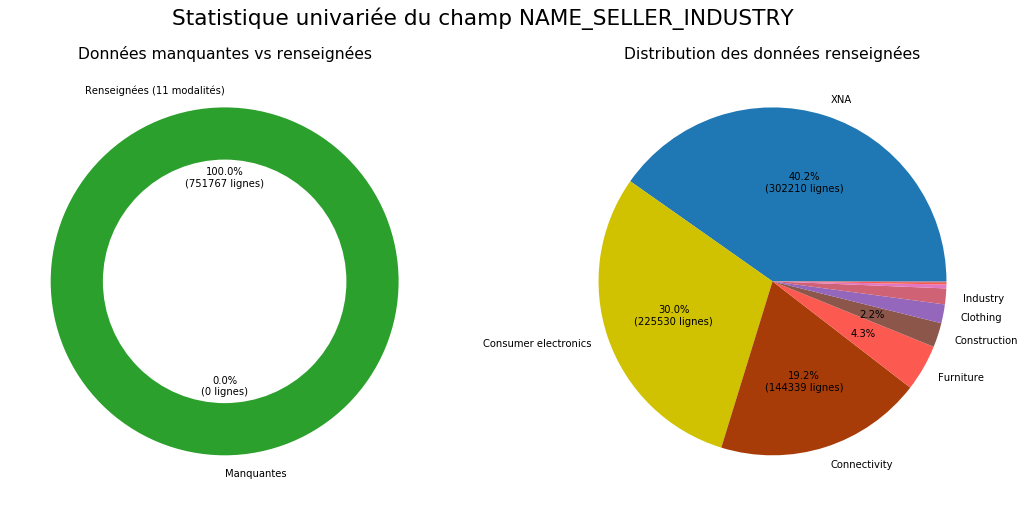

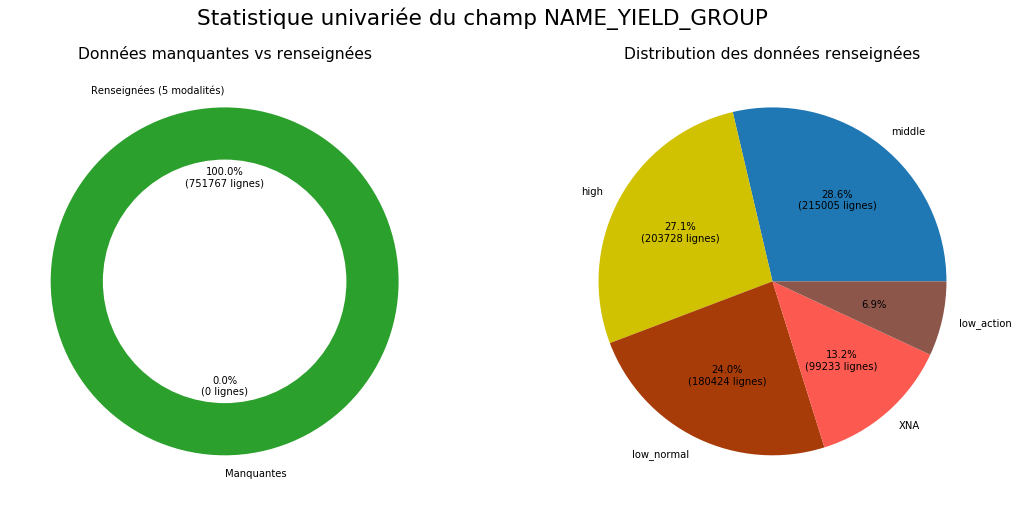

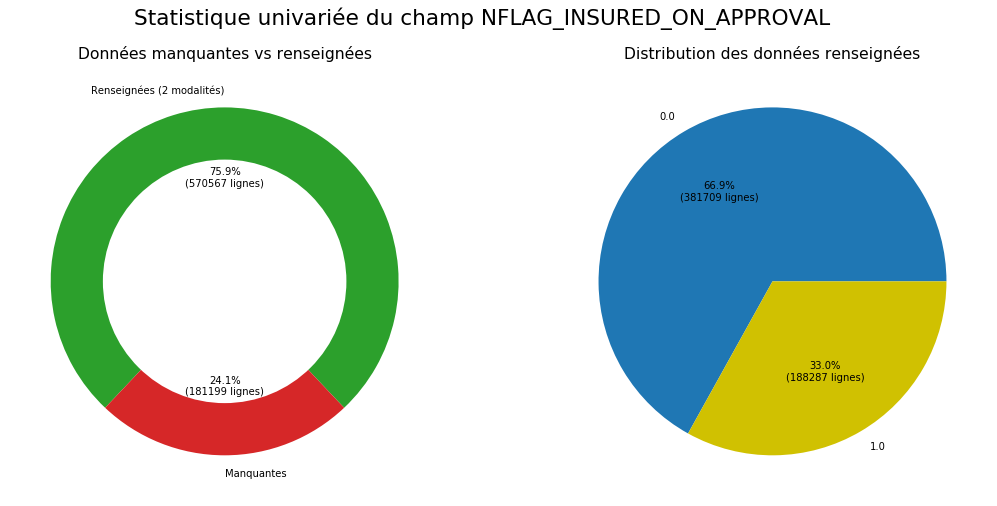

In [197]:
myDf(dfPreviousApplication).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_PREV','SK_ID_CURR'])

## Encodage de variables catégorielles

In [198]:
dfPreviousApplication['NAME_YIELD_GROUP_ENCODED'] = -1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP_ENCODED"] = 3
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP_ENCODED"] = 2
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP_ENCODED"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP_ENCODED"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP_ENCODED == -1].index, "NAME_YIELD_GROUP_ENCODED"] = np.nan
del dfPreviousApplication['NAME_YIELD_GROUP']

In [199]:
dfPreviousApplication['NAME_CONTRACT_STATUS_ENCODED'] = -1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved'].index, "NAME_CONTRACT_STATUS_ENCODED"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused'].index, "NAME_CONTRACT_STATUS_ENCODED"] = 0
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS_ENCODED == -1].index, "NAME_CONTRACT_STATUS_ENCODED"] = np.nan
del dfPreviousApplication['NAME_CONTRACT_STATUS']

In [200]:
dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
dfXSell['X_SELL'] = 1
dfXSell
dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication['X_SELL'] = dfPreviousApplication.apply(lambda x: np.where(x.X_SELL==1,1,0), axis=1)
del dfPreviousApplication['NAME_PRODUCT_TYPE']

# Exploration de installment payments

## Suppression de variables inintéressantes

In [90]:
del dfInstallmentsPayments['NUM_INSTALMENT_VERSION'] #Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER'] #On which installment we observe payment

## Statistique univariée

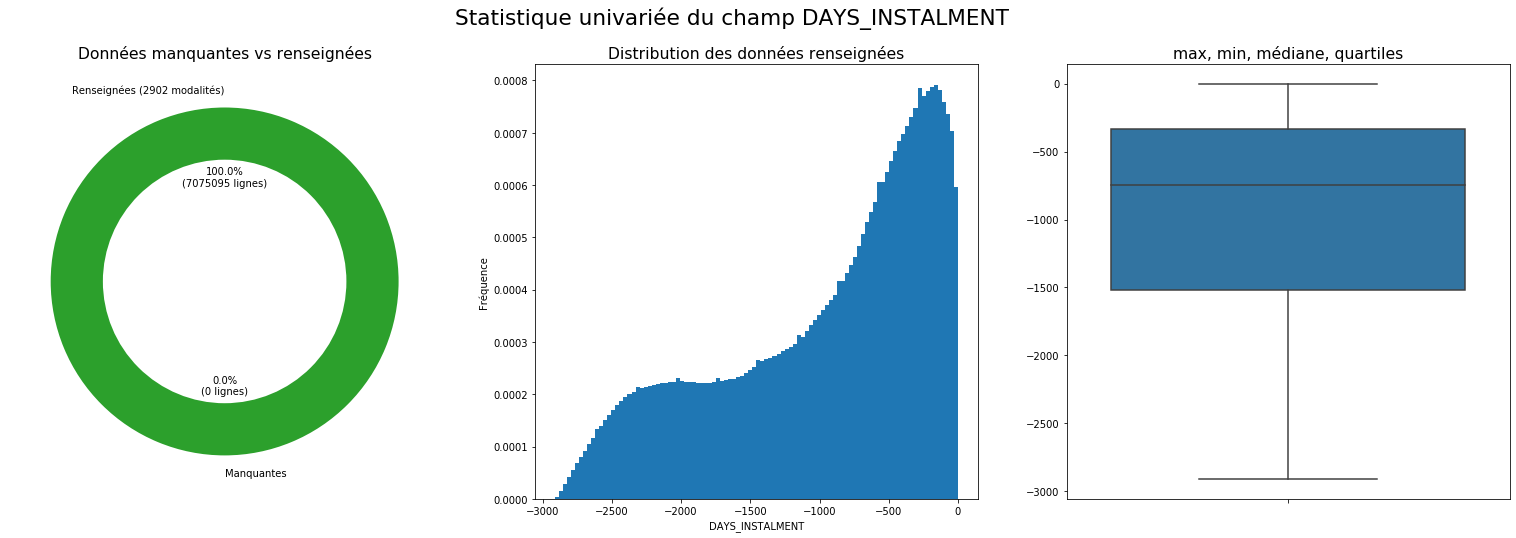

Mesures de position
 - Moyenne: -968.42
 - Médiane: -749.0
Mesures de dispertion
 - Ecart type: 754.31
 - Min: -2911.0
 - Q25: -1516.0
 - Q75: -335.0
 - Max: -1.0
Mesures de forme
 - Skewness (asymétrie): -0.69
 - Kurtosis (applatissement): -0.69


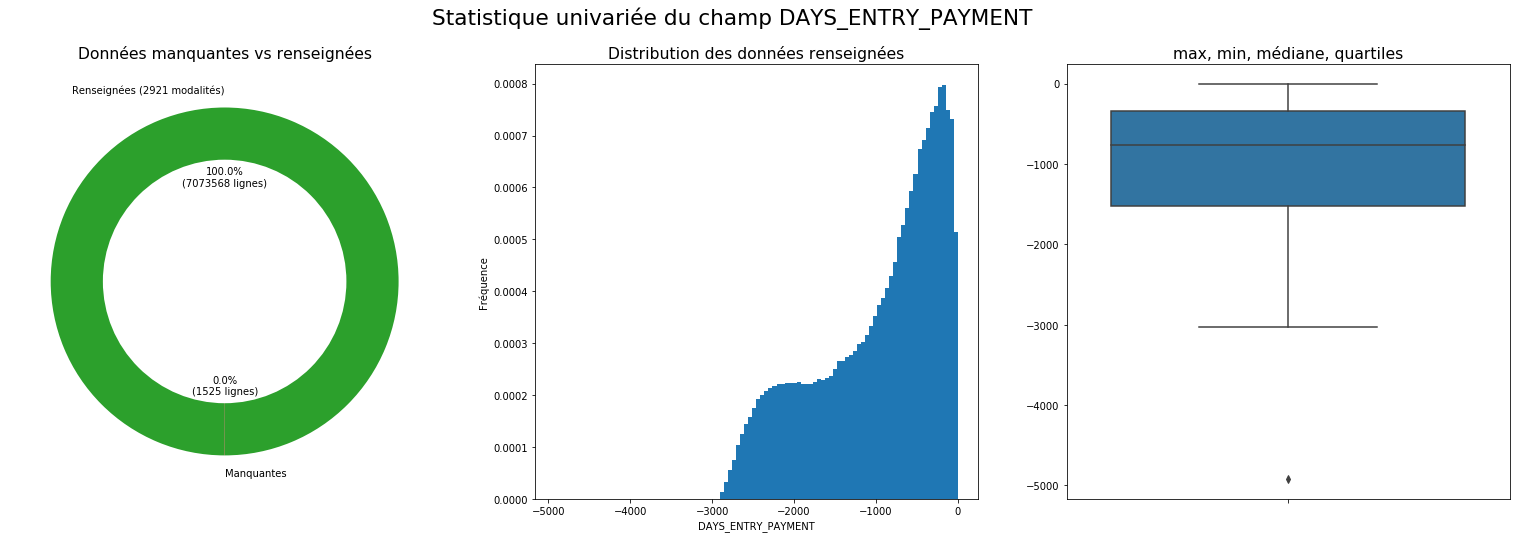

Mesures de position
 - Moyenne: -977.84
 - Médiane: -759.0
Mesures de dispertion
 - Ecart type: 754.24
 - Min: -4921.0
 - Q25: -1525.0
 - Q75: -345.0
 - Max: -1.0
Mesures de forme
 - Skewness (asymétrie): -0.69
 - Kurtosis (applatissement): -0.7


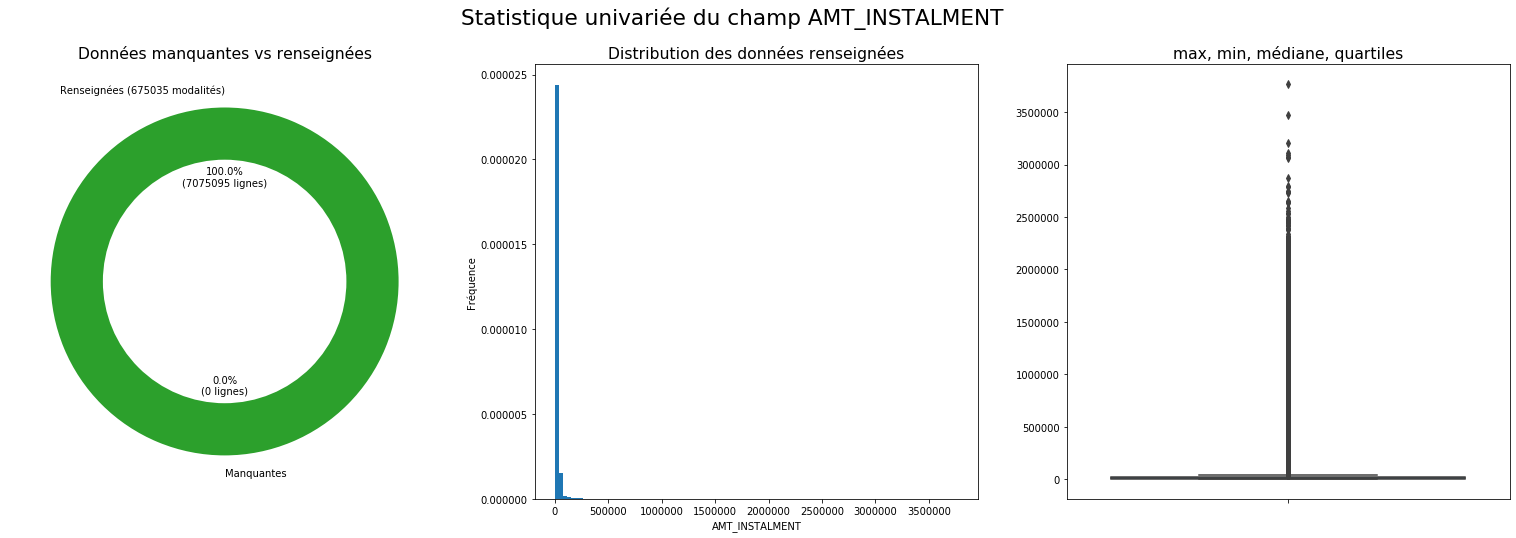

Mesures de position
 - Moyenne: 18072.33
 - Médiane: 9212.94
Mesures de dispertion
 - Ecart type: 52436.83
 - Min: 0.0
 - Q25: 4645.12
 - Q75: 17695.04
 - Max: 3771487.84
Mesures de forme
 - Skewness (asymétrie): 15.72
 - Kurtosis (applatissement): 362.32


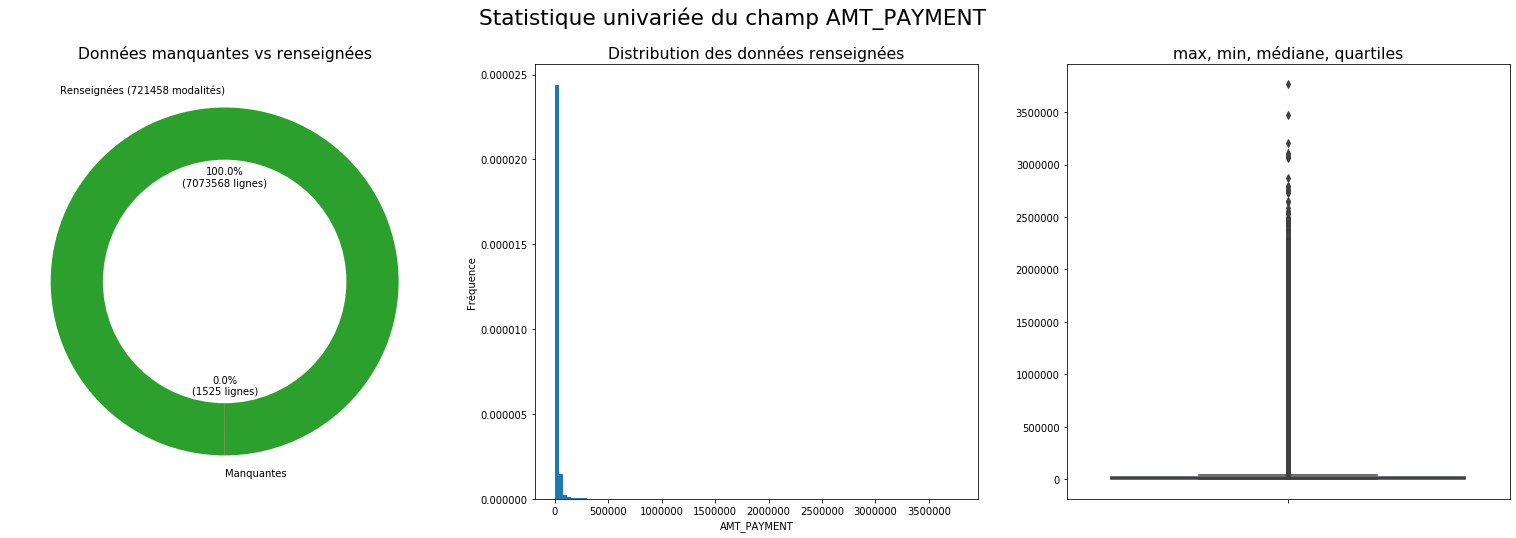

Mesures de position
 - Moyenne: 18259.65
 - Médiane: 8865.58
Mesures de dispertion
 - Ecart type: 56798.94
 - Min: 0.0
 - Q25: 4050.4
 - Q75: 16989.71
 - Max: 3771487.84
Mesures de forme
 - Skewness (asymétrie): 14.49
 - Kurtosis (applatissement): 303.52


In [91]:
myDf(dfInstallmentsPayments).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

# Exploration de PosCashBalance

### Pour l'analyse, on diminue la taille du train set

In [100]:
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")

In [101]:
dfPosCashBalance = dfPosCashBalance[(dfPosCashBalance.SK_ID_CURR >150000) & (dfPosCashBalance.SK_ID_CURR <175000)]

## Variables inintéressantes

In [102]:
dfPosCashBalance.NAME_CONTRACT_STATUS.value_counts()

Active                   637691
Completed                 51801
Signed                     6113
Returned to the store       404
Approved                    338
Demand                      219
Amortized debt               11
Name: NAME_CONTRACT_STATUS, dtype: int64

In [103]:
del dfPosCashBalance['NAME_CONTRACT_STATUS']
del dfPosCashBalance['CNT_INSTALMENT'] # Term of previous credit (can change over time)
del dfPosCashBalance['CNT_INSTALMENT_FUTURE'] # Installments left to pay on the previous credit

## Recherche de corrélations

### Entre SK_DPD et SK_DPD_DEF

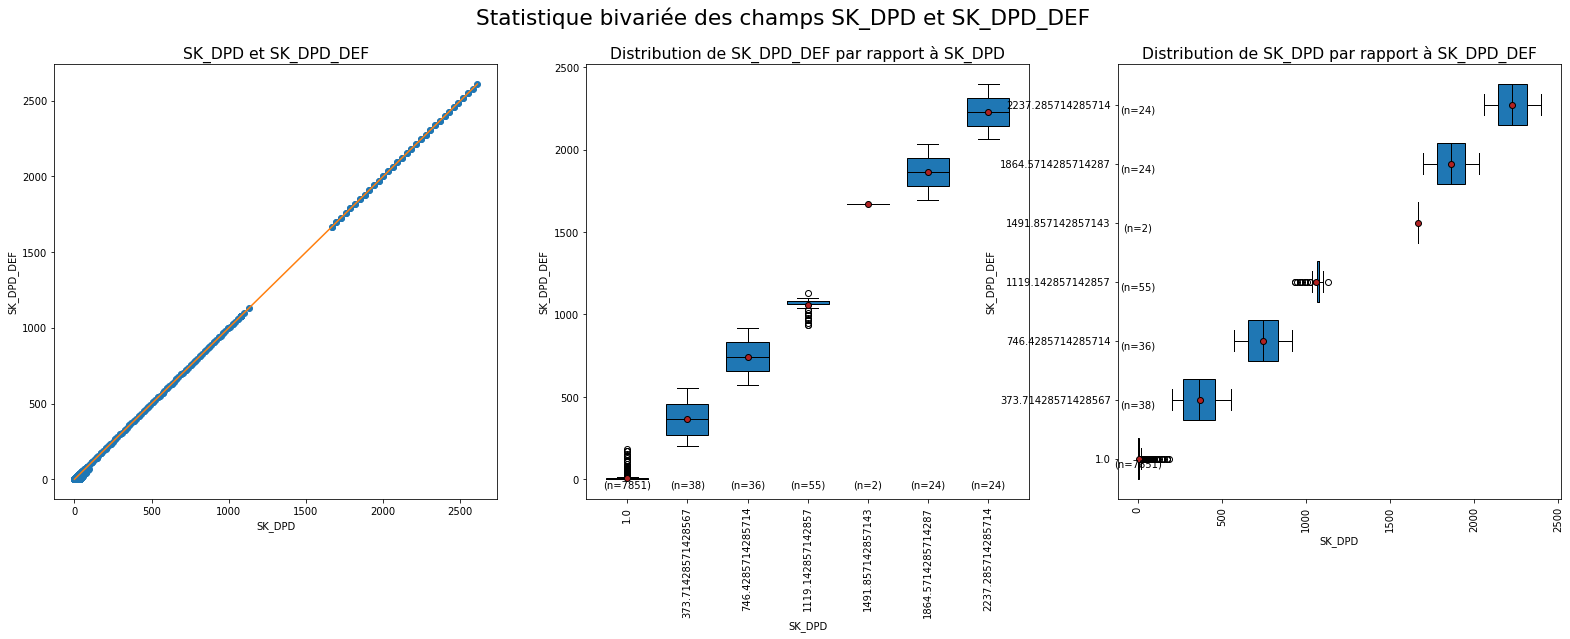

Covariance entre SK_DPD et SK_DPD_DEF : 45124.90762801437 
Covariance débiaisée entre SK_DPD et SK_DPD_DEF : 45130.51948072274 
Coefficient de correlation linéaire entre SK_DPD et SK_DPD_DEF : 0.9998198958785647 
Régression linéaire entre SK_DPD et SK_DPD_DEF: y = 0.9999639124983335x + -0.550815617827929
Coefficient de détermination entre SK_DPD et SK_DPD_DEF : 0.9996398241946239 


In [104]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD_DEF != 0]).Stat(['SK_DPD','SK_DPD_DEF'], typeStat='biv')

In [105]:
print('Nombre de lignes avec le champ vide:')
(dfPosCashBalance[['SK_DPD','SK_DPD_DEF']].isnull()).sum()

Nombre de lignes avec le champ vide:


SK_DPD        0
SK_DPD_DEF    0
dtype: int64

In [106]:
print('Nombre de lignes avec SK_DPD=0 et SK_DPD_DEF != 0:')
dfPosCashBalance[(dfPosCashBalance.SK_DPD == 0) & (dfPosCashBalance.SK_DPD_DEF != 0)].shape[0]

Nombre de lignes avec SK_DPD=0 et SK_DPD_DEF != 0:


0

In [107]:
print('Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF=0:')
dfPosCashBalance[(dfPosCashBalance.SK_DPD != 0) & (dfPosCashBalance.SK_DPD_DEF == 0)].shape[0]

Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF=0:


13040

In [108]:
print('Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF!=0:')
dfPosCashBalance[dfPosCashBalance.SK_DPD != 0].shape[0]

Nombre de lignes avec SK_DPD!=0 et SK_DPD_DEF!=0:


21082

On prend la moyenne des deux

In [109]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: (x.SK_DPD + x.SK_DPD_DEF) / 2, axis=1)

In [110]:
del dfPosCashBalance['SK_DPD_DEF']

## Statistique univariée

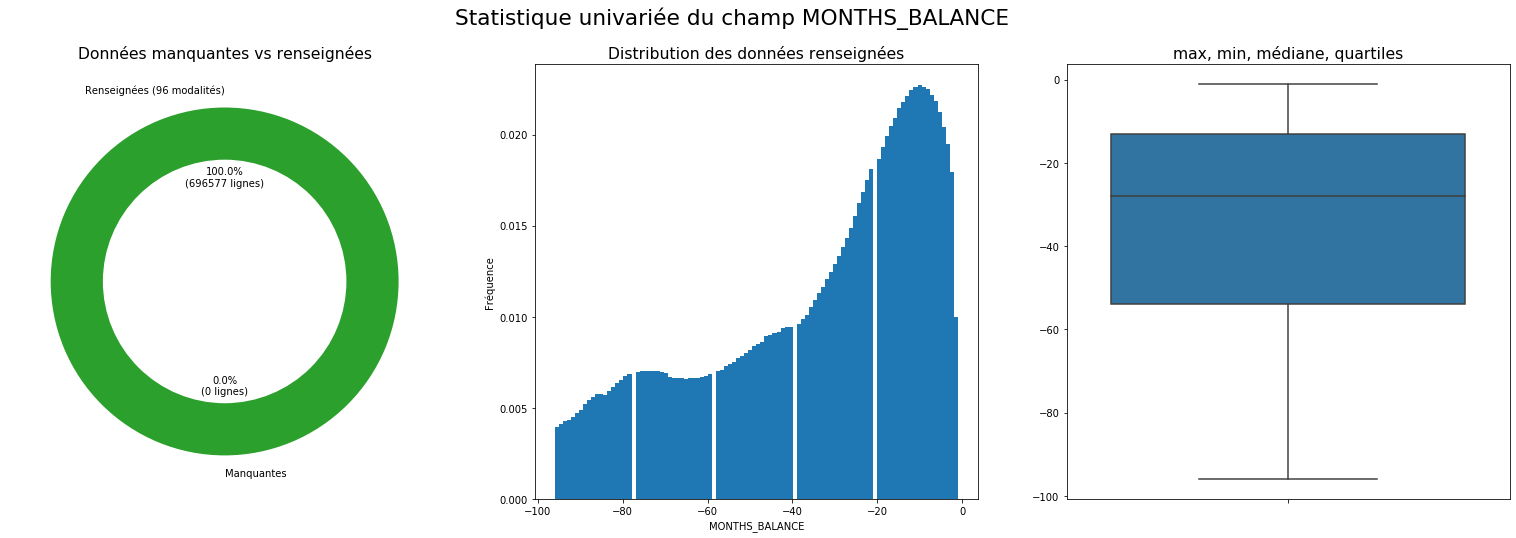

Mesures de position
 - Moyenne: -35.15
 - Médiane: -28.0
Mesures de dispertion
 - Ecart type: 26.17
 - Min: -96
 - Q25: -54.0
 - Q75: -13.0
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -0.66
 - Kurtosis (applatissement): -0.73


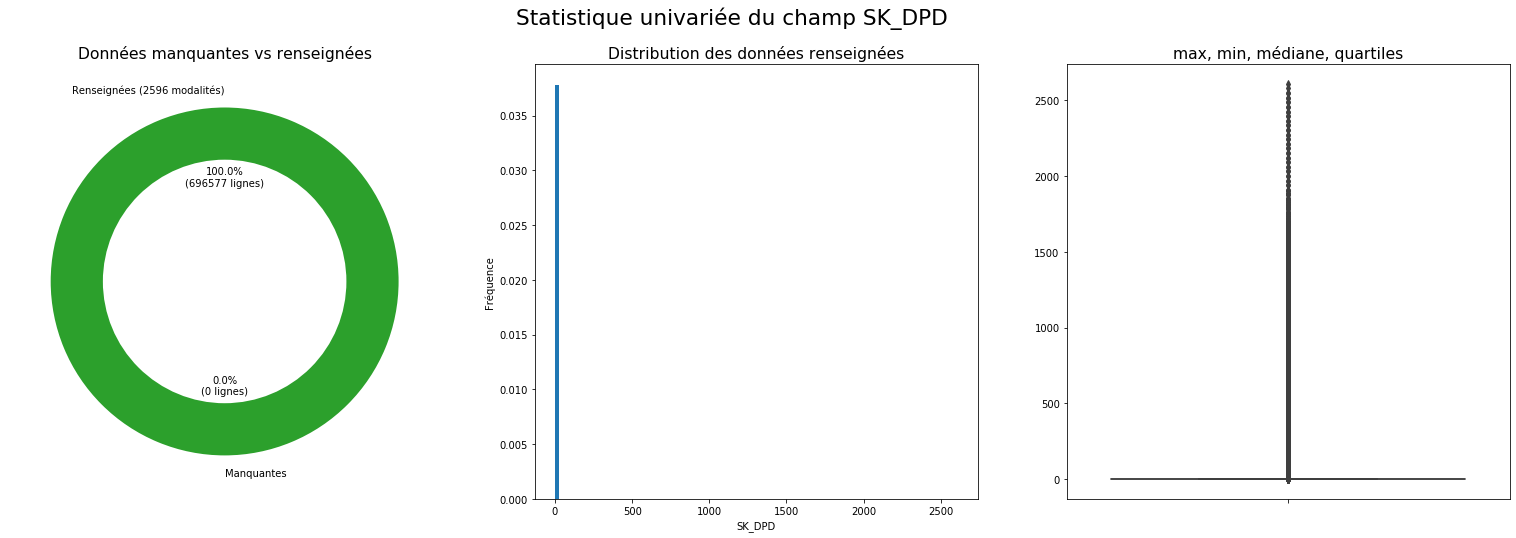

Mesures de position
 - Moyenne: 6.3
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 70.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 2610.0
Mesures de forme
 - Skewness (asymétrie): 15.07
 - Kurtosis (applatissement): 273.47


In [111]:
myDf(dfPosCashBalance).Stat(exclCol=['SK_ID_CURR','SK_ID_PREV'], typeStat='univ', statsNan=True)

### SK_DPD restreint aux valeurs strictement positives

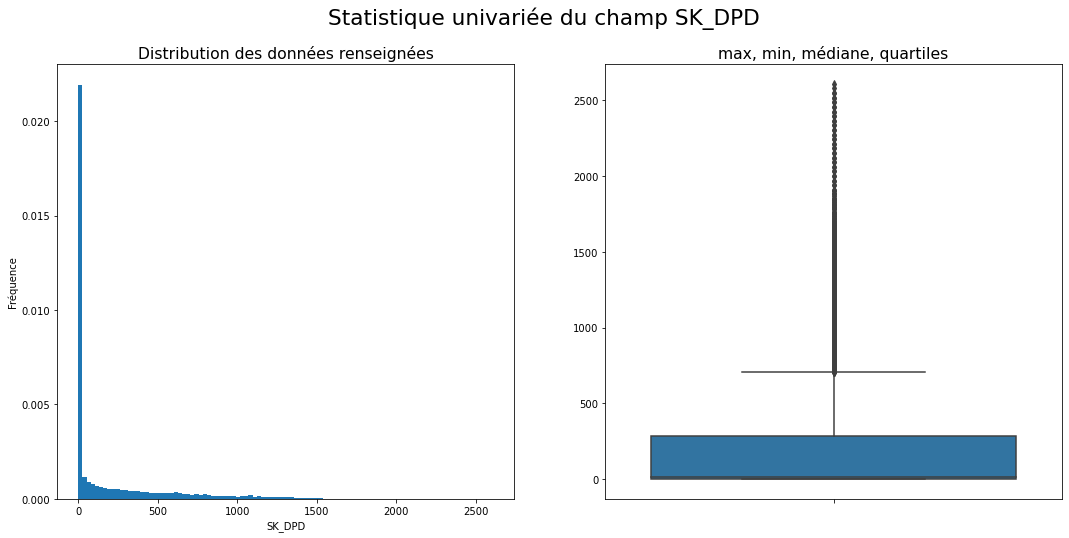

Mesures de position
 - Moyenne: 208.21
 - Médiane: 13.0
Mesures de dispertion
 - Ecart type: 351.65
 - Min: 0.5
 - Q25: 4.0
 - Q75: 286.0
 - Max: 2610.0
Mesures de forme
 - Skewness (asymétrie): 2.16
 - Kurtosis (applatissement): 4.99


In [100]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD > 0]).Stat('SK_DPD')

# Exploration de CreditCardBalance

In [ ]:
dfPosCashBalance = dfPosCashBalance[(dfPosCashBalance.SK_ID_CURR > 150000) & (dfPosCashBalance.SK_ID_CURR < 200000)]
dfInstallmentsPayments = dfInstallmentsPayments[(dfInstallmentsPayments.SK_ID_CURR > 150000) & (dfInstallmentsPayments.SK_ID_CURR < 200000)]
dfCreditCardBalance = dfCreditCardBalance[(dfCreditCardBalance.SK_ID_CURR > 150000) & (dfCreditCardBalance.SK_ID_CURR < 200000)]

In [ ]:
dfPosCashBalance.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])

# Exploration de dfBureau

In [114]:
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureau = dfBureau.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)

In [115]:
dfBureau = dfBureau.merge(dfApplicationTrain[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

## Statistiques sur les previous par current application

In [112]:
nbWithPrevious = dfApplicationTrain[dfApplicationTrain.SK_ID_CURR.isin(dfBureau.SK_ID_CURR)].shape[0]
nbWithoutPrevious = dfApplicationTrain[~dfApplicationTrain.SK_ID_CURR.isin(dfBureau.SK_ID_CURR)].shape[0]
print("{} loans sans previous ({}%)".format(nbWithoutPrevious, np.round(100 * nbWithoutPrevious / (nbWithPrevious + nbWithoutPrevious), 1)))

29649 loans sans previous (14.4%)


Text(0.5, 1.0, 'Stat nb previous application in other financial institution')

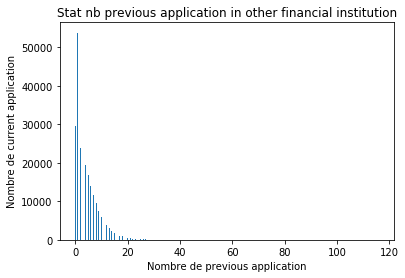

In [113]:
distrib_nb_previous = dfApplicationTrain.merge(dfBureau[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')['SK_ID_CURR'].value_counts().value_counts()
distrib_nb_previous[0] = nbWithoutPrevious
tmp = pd.DataFrame({'nb_previous': pd.Series(distrib_nb_previous.index),
                   'nb_application': distrib_nb_previous.reset_index(drop=True)}).sort_values('nb_previous')
plt.bar(pd.Series(distrib_nb_previous.index), distrib_nb_previous.reset_index(drop=True), width=0.3)
plt.xlabel('Nombre de previous application')
plt.ylabel('Nombre de current application')
plt.title("Stat nb previous application in other financial institution")

## Suppression de variables non pertinentes

### Trop de valeurs manquantes

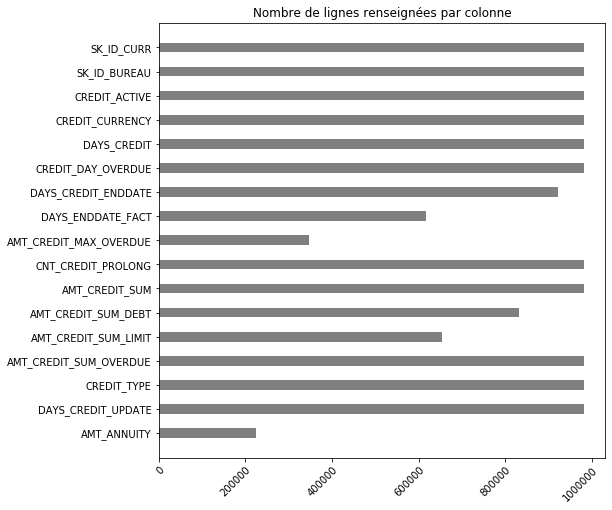

In [114]:
myDf(dfBureau).ColCountLinesChart(typeChart='barh', displayColName=True)

In [115]:
del dfBureau['AMT_ANNUITY']

### Trop de valeurs identiques

#### Devise

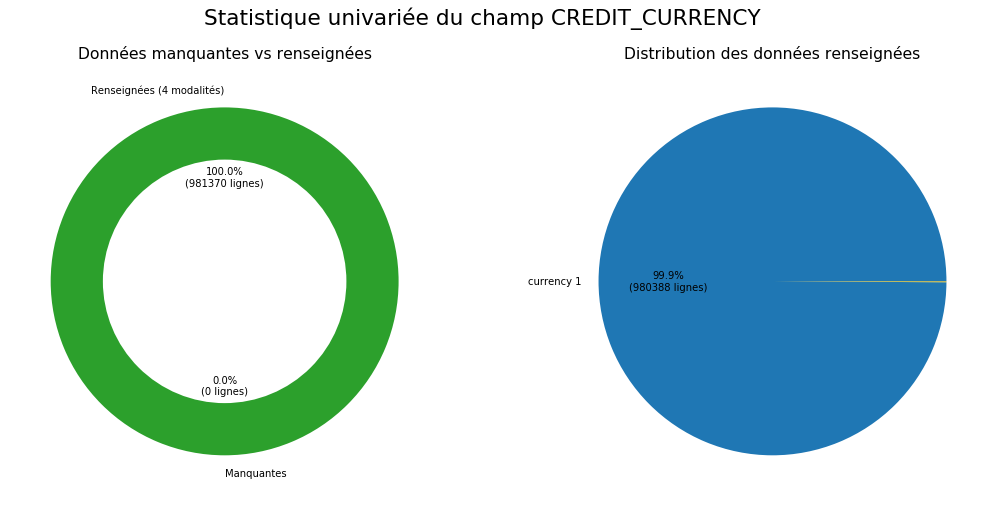

In [116]:
myDf(dfBureau).Stat('CREDIT_CURRENCY', statsNan=True)

On supprime le champ devise tout en conservant les deux montants

In [138]:
del dfBureau['CREDIT_CURRENCY']

#### Autres champs

In [117]:
nb_zero = dfBureau[dfBureau.CNT_CREDIT_PROLONG==0].shape[0]
nb_not_null = dfBureau[~dfBureau.CNT_CREDIT_PROLONG.isnull()].shape[0]
print("CNT_CREDIT_PROLONG: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

CNT_CREDIT_PROLONG: 975425 sur 981370 à zéro (99.0%)


In [118]:
nb_zero = dfBureau[dfBureau.CREDIT_DAY_OVERDUE==0].shape[0]
nb_not_null = dfBureau[~dfBureau.CREDIT_DAY_OVERDUE.isnull()].shape[0]
print("CREDIT_DAY_OVERDUE: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

CREDIT_DAY_OVERDUE: 978903 sur 981370 à zéro (100.0%)


In [119]:
nb_zero = dfBureau[dfBureau.AMT_CREDIT_SUM_OVERDUE==0].shape[0]
nb_not_null = dfBureau[~dfBureau.AMT_CREDIT_SUM_OVERDUE.isnull()].shape[0]
print("AMT_CREDIT_SUM_OVERDUE: {} sur {} à zéro ({}%)".format(nb_zero, nb_not_null,np.round(nb_zero/nb_not_null*100),1))

AMT_CREDIT_SUM_OVERDUE: 978947 sur 981370 à zéro (100.0%)


In [120]:
nb_zero = dfBureau[dfBureau['AMT_CREDIT_SUM_LIMIT']==0].shape[0]
nb_total = dfBureau[~dfBureau['AMT_CREDIT_SUM_LIMIT'].isnull()].shape[0]
print("{} AMT_CREDIT_SUM_LIMIT à zéro sur {} renseignés ({}%)".format(nb_zero,nb_total,np.round(100*nb_zero/nb_total,1)))

609652 AMT_CREDIT_SUM_LIMIT à zéro sur 653208 renseignés (93.3%)


In [121]:
nb_zero = dfBureau[dfBureau['AMT_CREDIT_MAX_OVERDUE']==0].shape[0]
nb_total = dfBureau[~dfBureau['AMT_CREDIT_MAX_OVERDUE'].isnull()].shape[0]
print("{} AMT_CREDIT_MAX_OVERDUE à zéro sur {} renseignés ({}%)".format(nb_zero,nb_total,np.round(100*nb_zero/nb_total,1)))

273836 AMT_CREDIT_MAX_OVERDUE à zéro sur 345742 renseignés (79.2%)


In [128]:
del dfBureau['CNT_CREDIT_PROLONG']
del dfBureau['CREDIT_DAY_OVERDUE']
del dfBureau['AMT_CREDIT_SUM_OVERDUE']
#del dfBureau['AMT_CREDIT_SUM_LIMIT']
#del dfBureau['AMT_CREDIT_MAX_OVERDUE']

## Recherche de corrélations

### Champs days

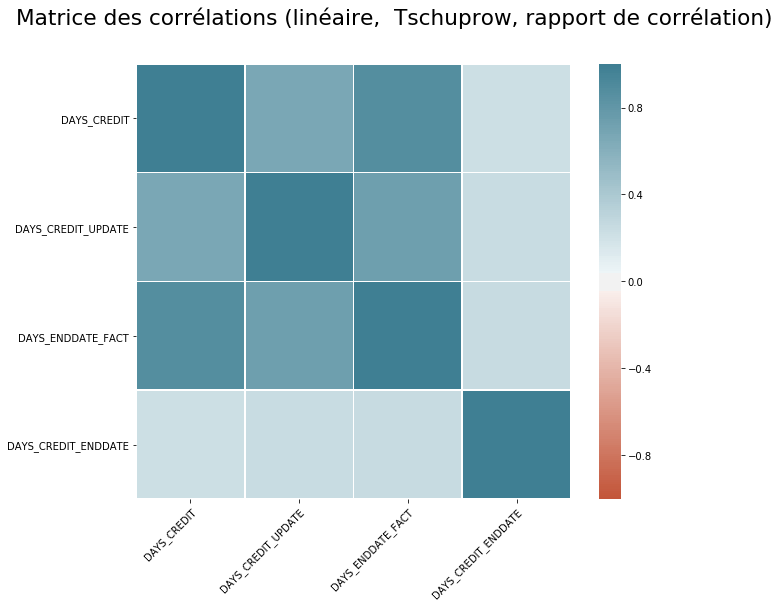

In [129]:
myDf(dfBureau).Stat(['DAYS_CREDIT','DAYS_CREDIT_UPDATE','DAYS_ENDDATE_FACT','DAYS_CREDIT_ENDDATE'], typeStat='biv', bivOnlyCorrTable=True)

In [130]:
print('Nombre de lignes avec le champ vide:')
(dfBureau[['DAYS_CREDIT','DAYS_CREDIT_UPDATE','DAYS_ENDDATE_FACT']].isnull()).sum()

Nombre de lignes avec le champ vide:


DAYS_CREDIT                0
DAYS_CREDIT_UPDATE         0
DAYS_ENDDATE_FACT     364634
dtype: int64

In [131]:
del dfBureau['DAYS_CREDIT_UPDATE']
del dfBureau['DAYS_ENDDATE_FACT']

### Champs amount

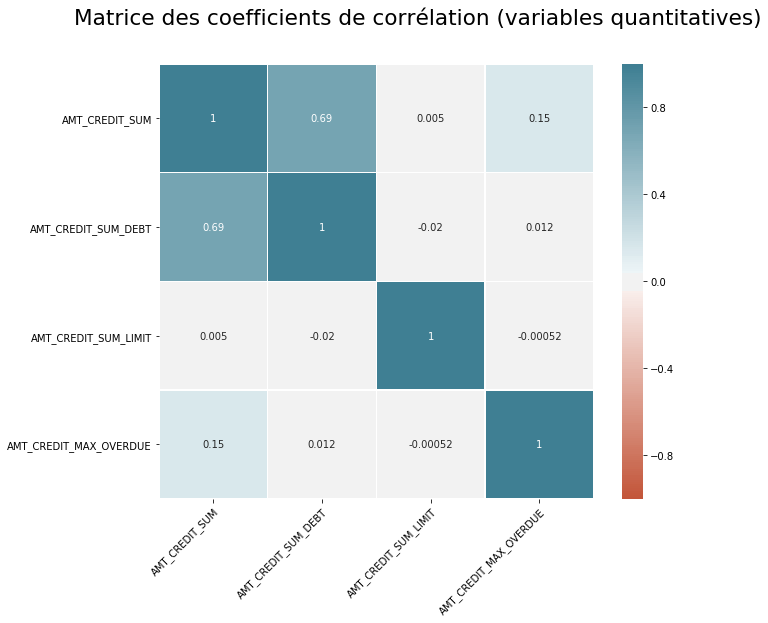

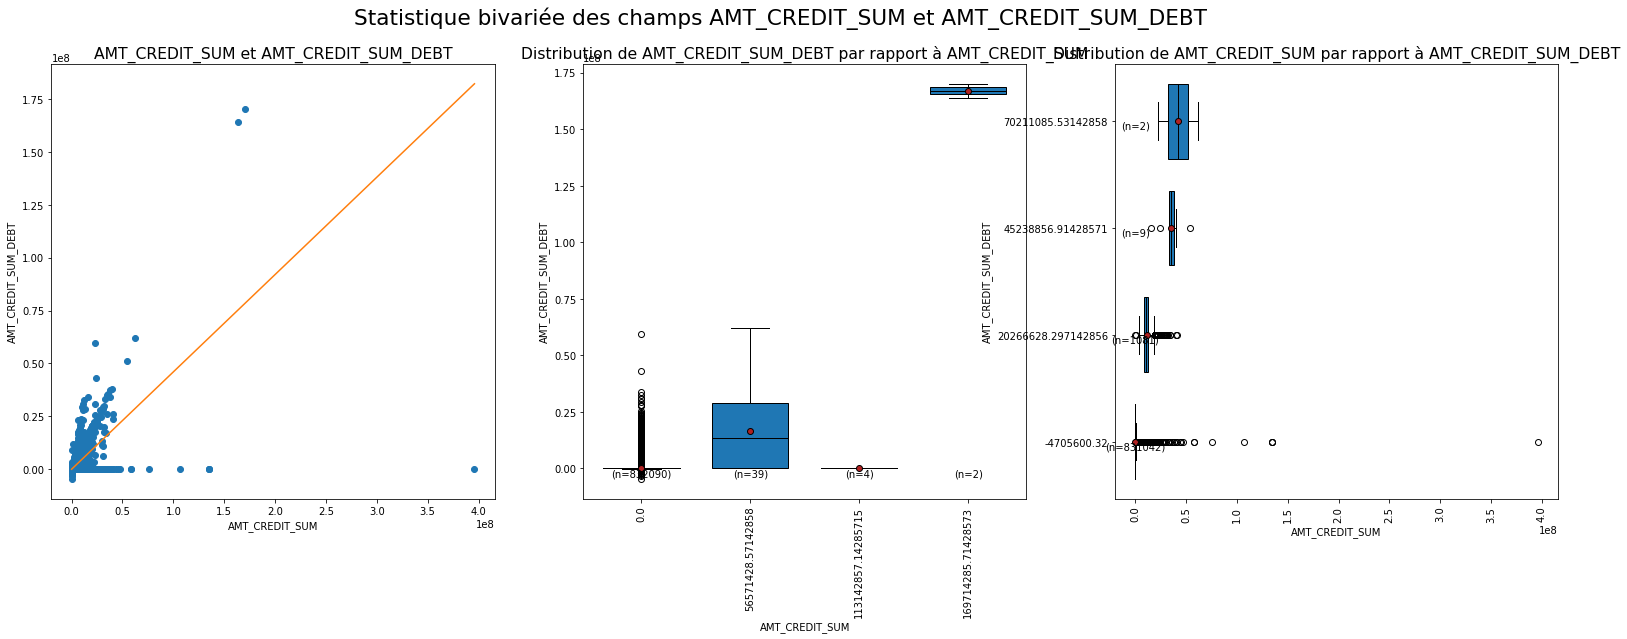

Covariance entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 488957629860.2066 
Covariance débiaisée entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 488958217454.32275 
Coefficient de correlation linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.6914700906413471 
Régression linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT: y = 0.4602597114131534x + -18352.152225768066
Coefficient de détermination entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.4781308862515528 


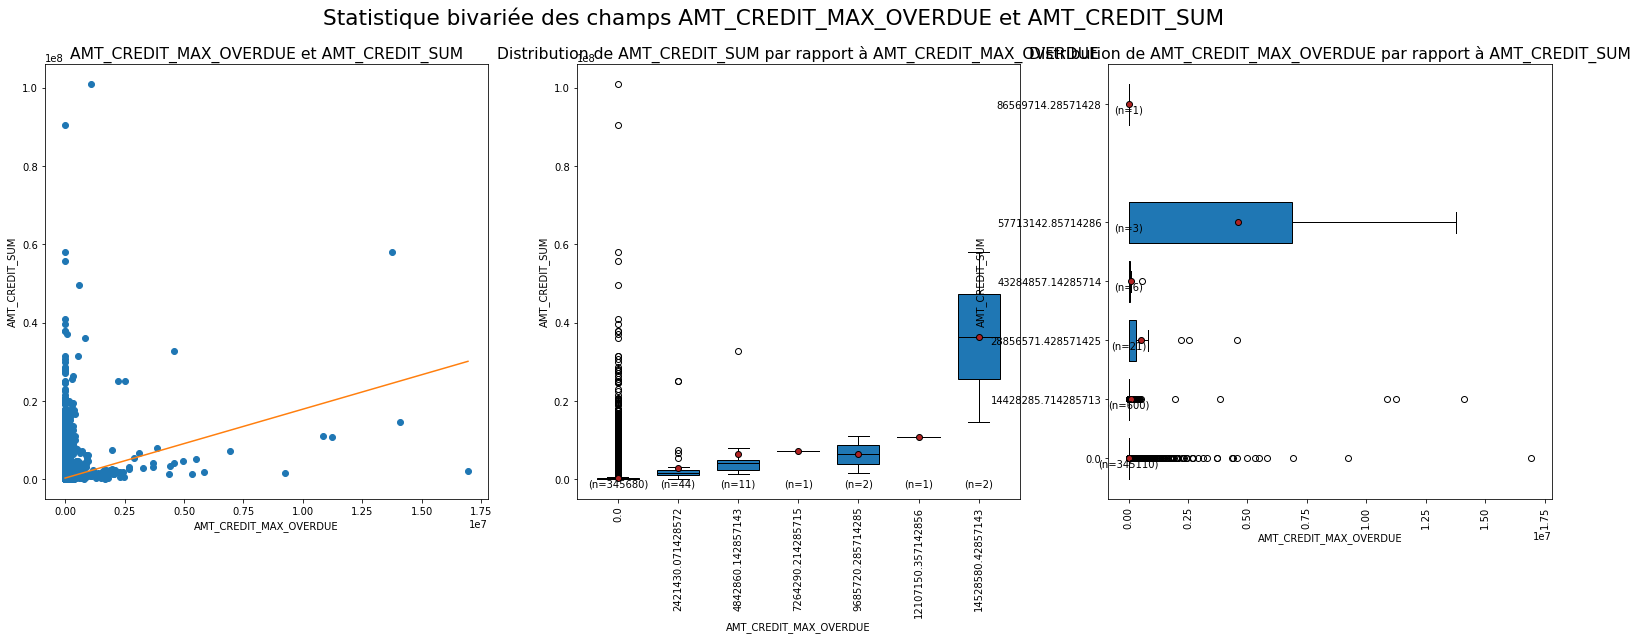

Covariance entre AMT_CREDIT_MAX_OVERDUE et AMT_CREDIT_SUM : 7975902492.622292 
Covariance débiaisée entre AMT_CREDIT_MAX_OVERDUE et AMT_CREDIT_SUM : 7975925561.63202 
Coefficient de correlation linéaire entre AMT_CREDIT_MAX_OVERDUE et AMT_CREDIT_SUM : 0.15011800828285576 
Régression linéaire entre AMT_CREDIT_MAX_OVERDUE et AMT_CREDIT_SUM: y = 1.7594105305643621x + 273362.8367033506
Coefficient de détermination entre AMT_CREDIT_MAX_OVERDUE et AMT_CREDIT_SUM : 0.02253541641081155 


KeyboardInterrupt: 

In [132]:
#del dfBureau['AMT_CREDIT_SUM_LIMIT']
#del dfBureau['AMT_CREDIT_MAX_OVERDUE']
myDf(dfBureau).Stat(['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT'], typeStat='biv')

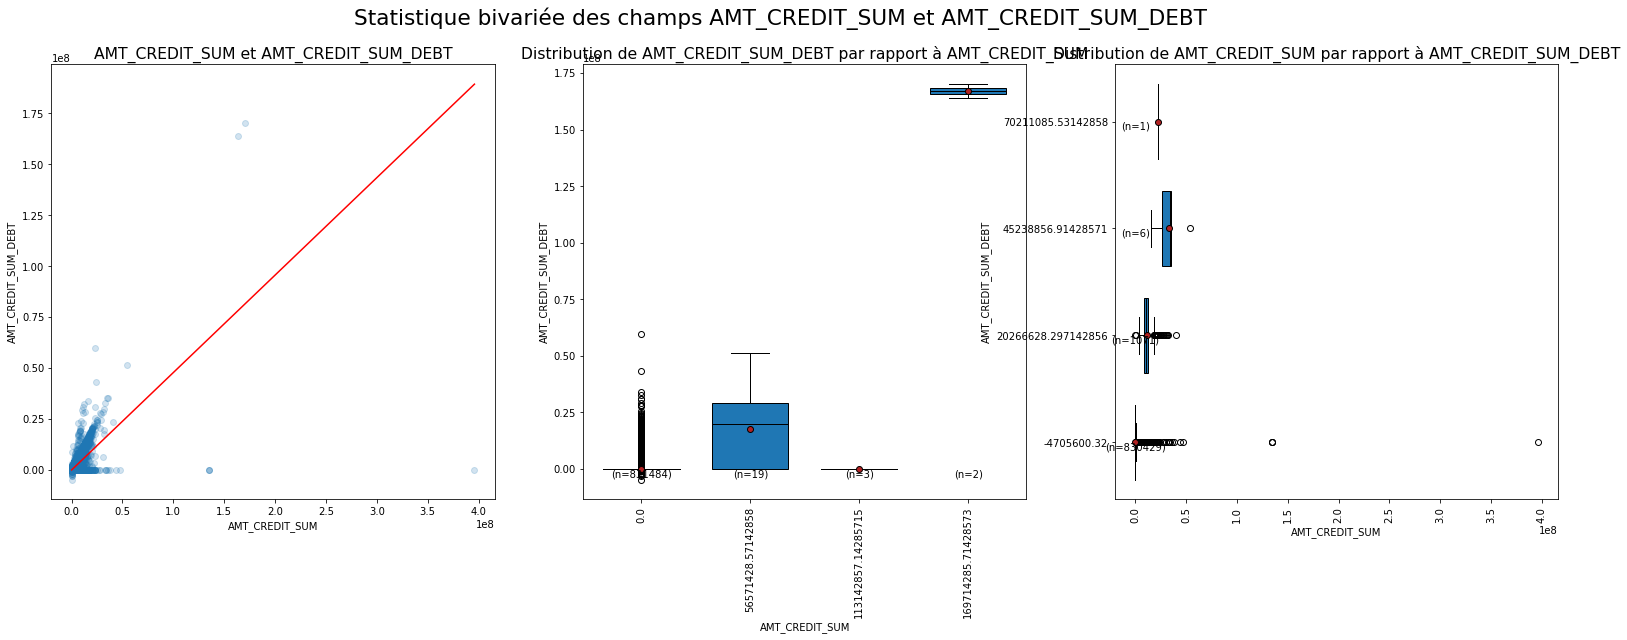

Covariance entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 472755949347.8521 
Covariance débiaisée entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 472756517900.3487 
Coefficient de correlation linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.7036006721172358 
Régression linéaire entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT: y = 0.4780494684885271x + -23284.38978539379
Coefficient de détermination entre AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT : 0.4950539058038259 


In [133]:
myDf(dfBureau).Stat(['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT'], typeStat='biv')

In [134]:
print('Nombre de lignes avec le champ vide:')
(dfBureau[['AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].isnull()).sum()

Nombre de lignes avec le champ vide:


AMT_CREDIT_SUM              3
AMT_CREDIT_SUM_DEBT    149231
dtype: int64

In [135]:
del dfBureau['AMT_CREDIT_SUM_DEBT']

### Autres champs

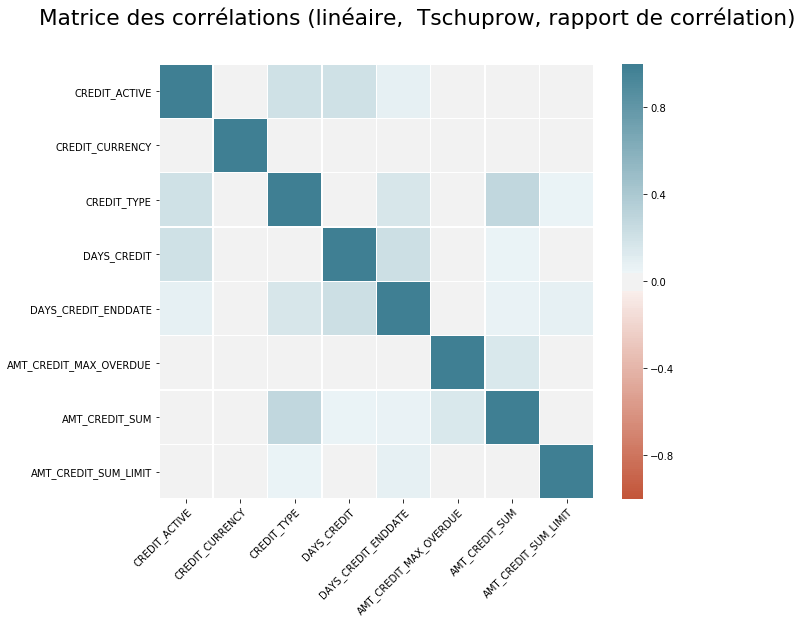

In [136]:
myDf(dfBureau).Stat(exclCol=['SK_ID_CURR','SK_ID_BUREAU'], typeStat='biv', bivOnlyCorrTable=True)

## Statistique univariée

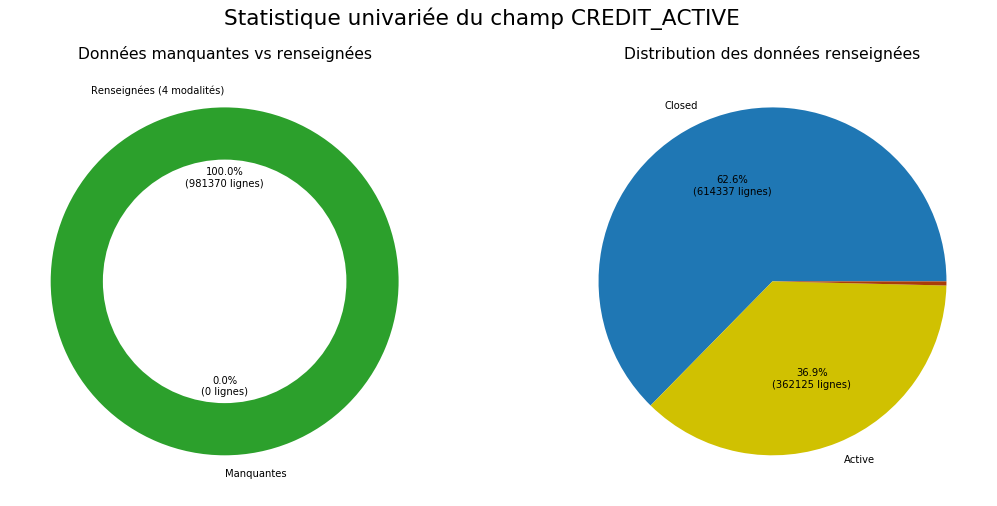

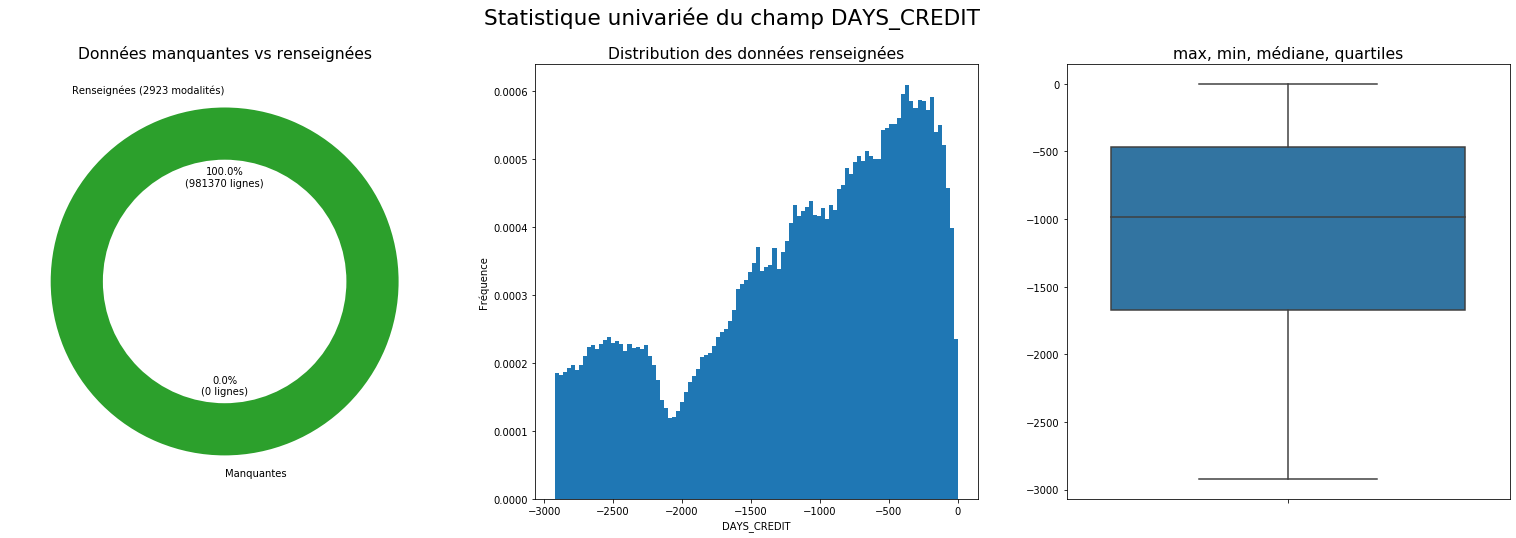

Mesures de position
 - Moyenne: -1143.14
 - Médiane: -985.0
Mesures de dispertion
 - Ecart type: 799.87
 - Min: -2922
 - Q25: -1671.0
 - Q75: -470.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -0.58
 - Kurtosis (applatissement): -0.76


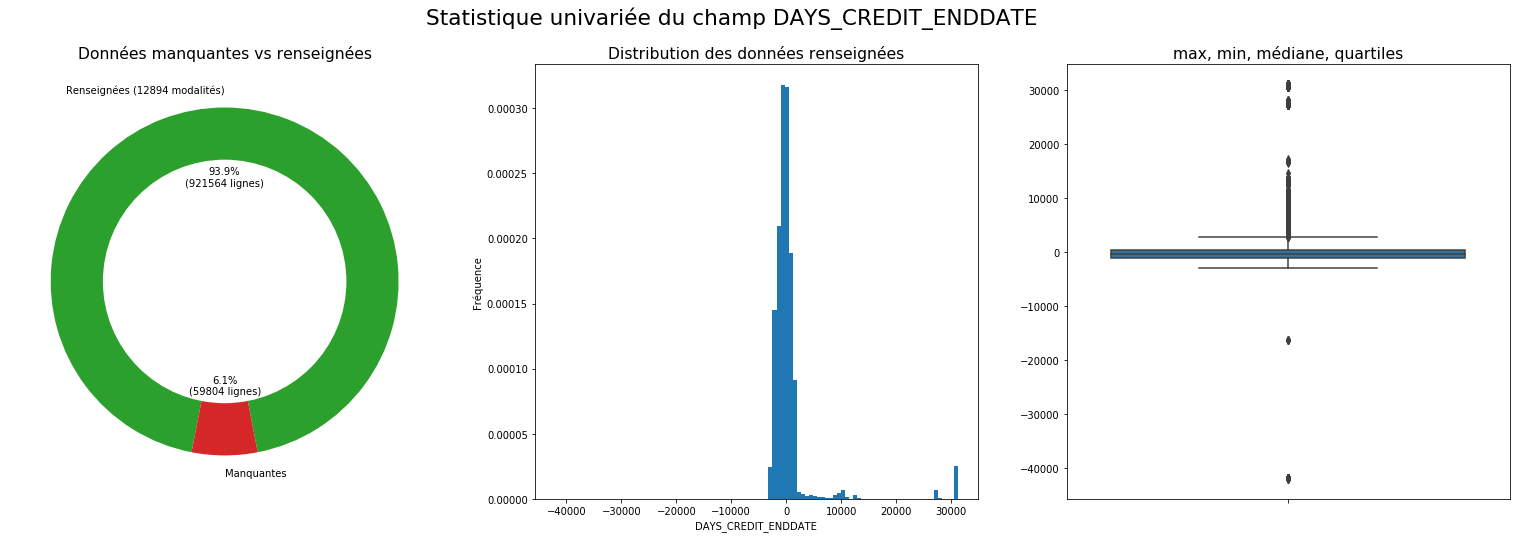

Mesures de position
 - Moyenne: 495.52
 - Médiane: -333.0
Mesures de dispertion
 - Ecart type: 4975.02
 - Min: -42060.0
 - Q25: -1143.0
 - Q75: 472.0
 - Max: 31199.0
Mesures de forme
 - Skewness (asymétrie): 5.13
 - Kurtosis (applatissement): 28.57


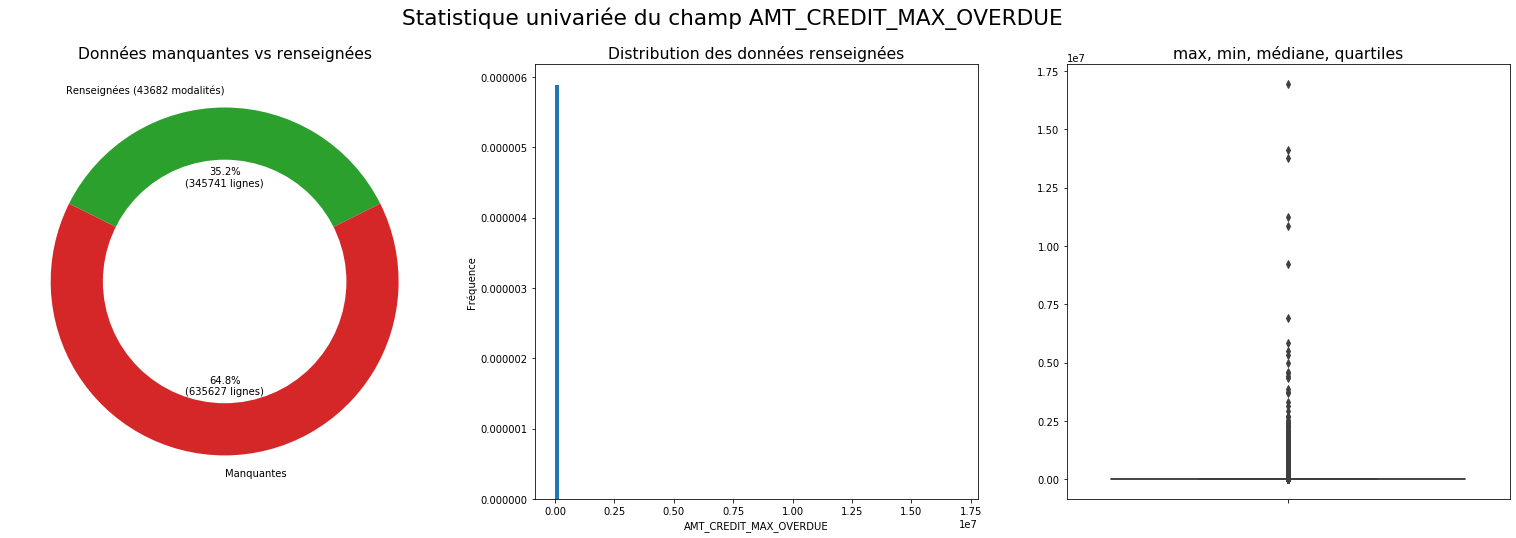

Mesures de position
 - Moyenne: 3504.72
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 67329.64
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 16950010.5
Mesures de forme
 - Skewness (asymétrie): 148.59
 - Kurtosis (applatissement): 28706.67


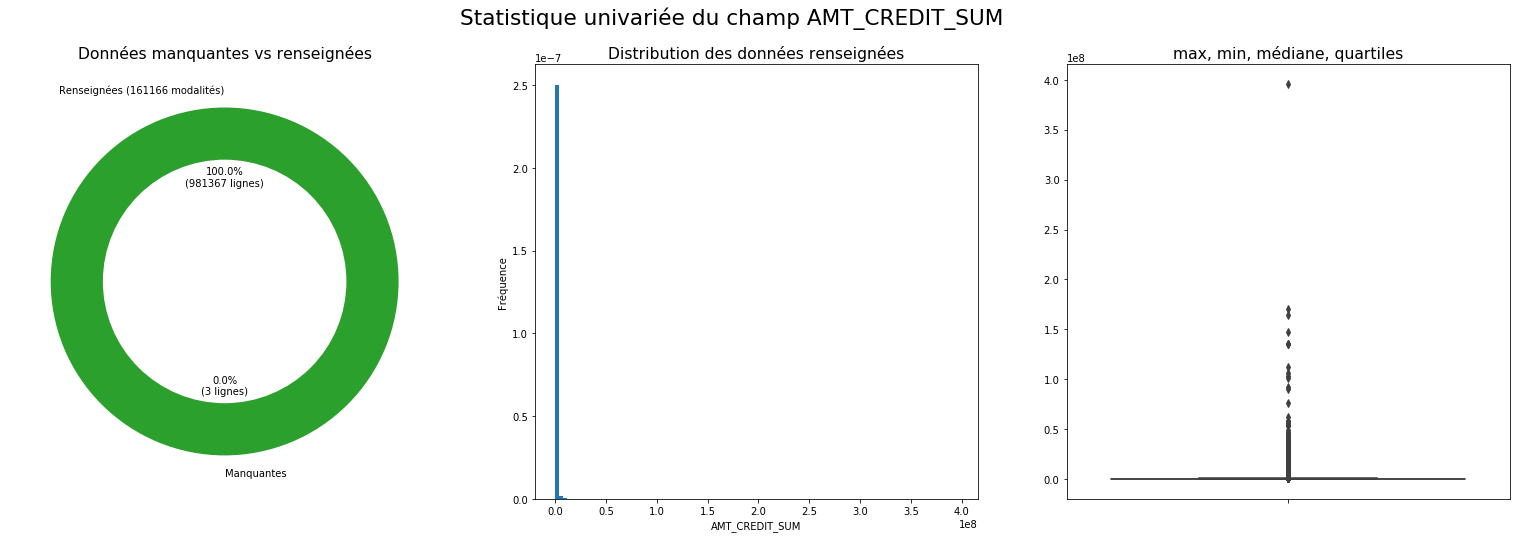

Mesures de position
 - Moyenne: 350311.01
 - Médiane: 124591.5
Mesures de dispertion
 - Ecart type: 1072692.56
 - Min: 0.0
 - Q25: 51223.5
 - Q75: 306000.0
 - Max: 396000000.0
Mesures de forme
 - Skewness (asymétrie): 80.29
 - Kurtosis (applatissement): 21853.6


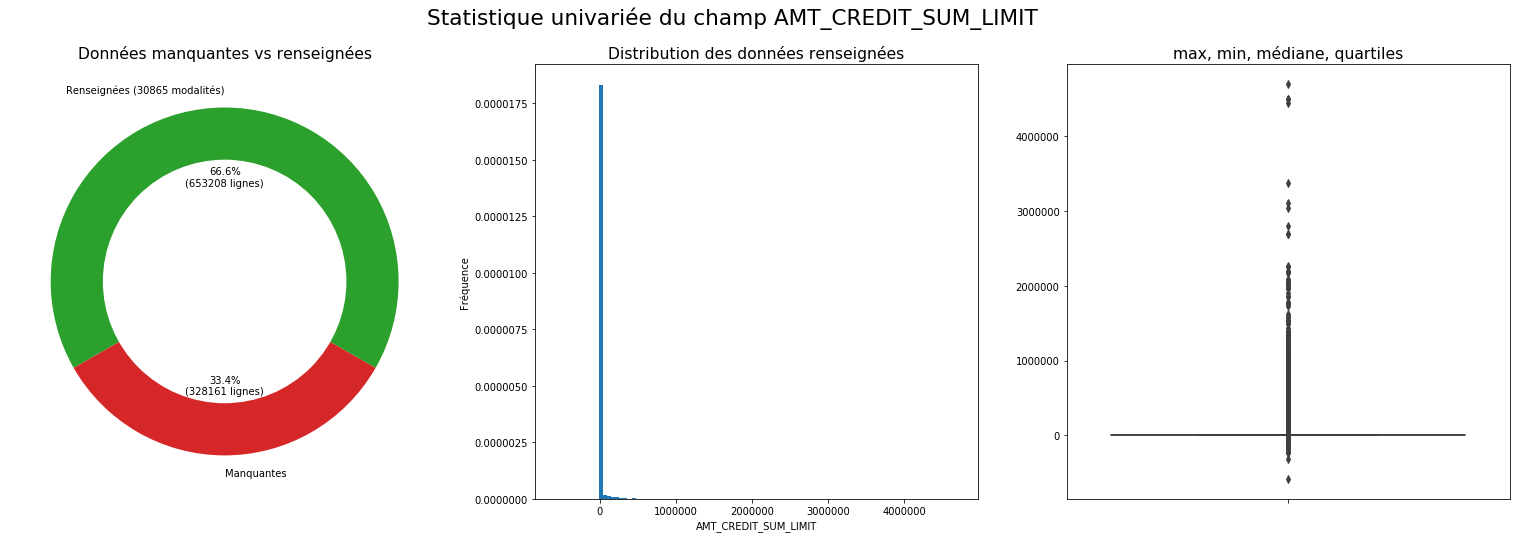

Mesures de position
 - Moyenne: 6359.26
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 46150.26
 - Min: -586406.12
 - Q25: 0.0
 - Q75: 0.0
 - Max: 4705600.32
Mesures de forme
 - Skewness (asymétrie): 19.75
 - Kurtosis (applatissement): 980.86


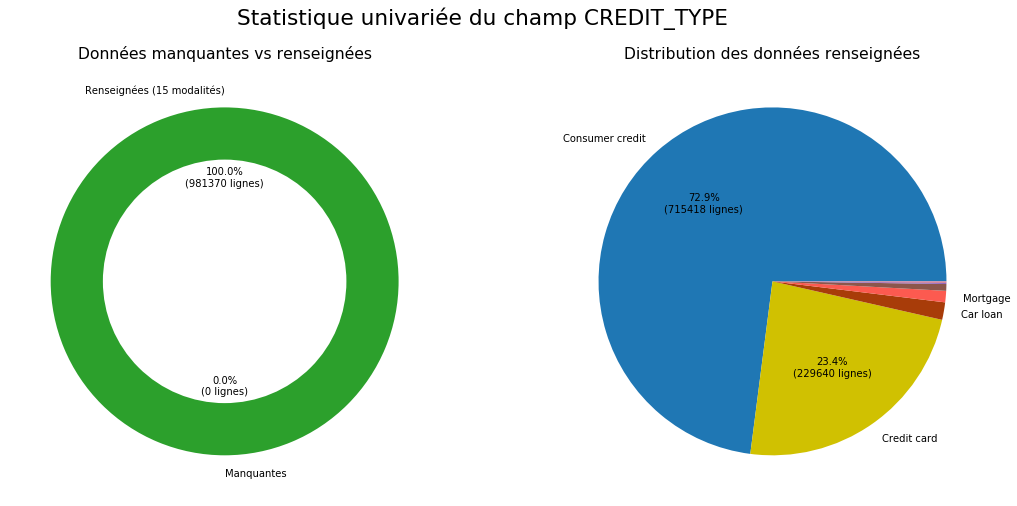

In [139]:
myDf(dfBureau).Stat(typeStat='univ', statsNan=True, exclCol=['SK_ID_BUREAU','SK_ID_CURR'])

## Gestion des outliers

In [140]:
dfBureau = dfBureau[((dfBureau.DAYS_CREDIT_ENDDATE > -10000) & (dfBureau.DAYS_CREDIT_ENDDATE < 20000)) | dfBureau.DAYS_CREDIT_ENDDATE.isnull()]

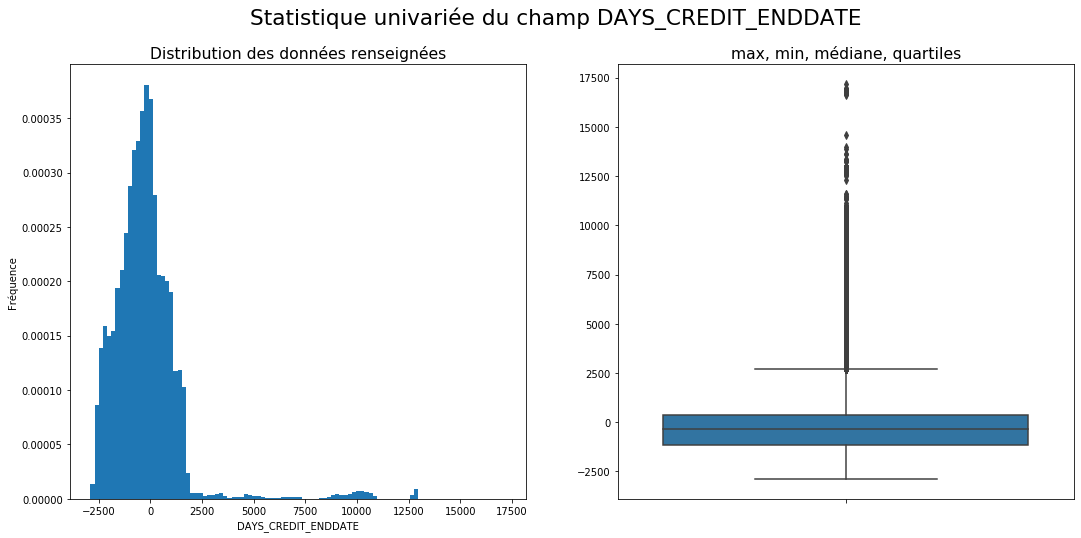

Mesures de position
 - Moyenne: -220.4
 - Médiane: -366.0
Mesures de dispertion
 - Ecart type: 1771.5
 - Min: -2890.0
 - Q25: -1167.0
 - Q75: 379.0
 - Max: 17185.0
Mesures de forme
 - Skewness (asymétrie): 3.47
 - Kurtosis (applatissement): 19.14


In [141]:
myDf(dfBureau).Stat('DAYS_CREDIT_ENDDATE')

# Exploration de Bureau Balance

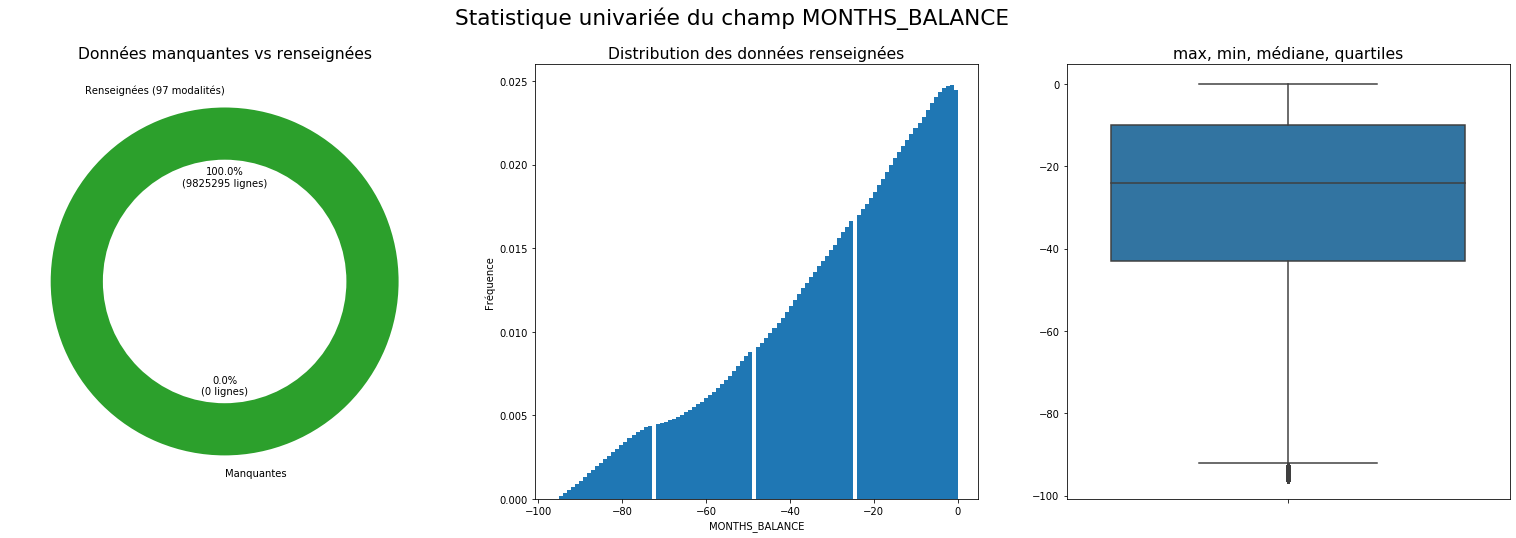

Mesures de position
 - Moyenne: -28.64
 - Médiane: -24.0
Mesures de dispertion
 - Ecart type: 22.07
 - Min: -96
 - Q25: -43.0
 - Q75: -10.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): -0.77
 - Kurtosis (applatissement): -0.23


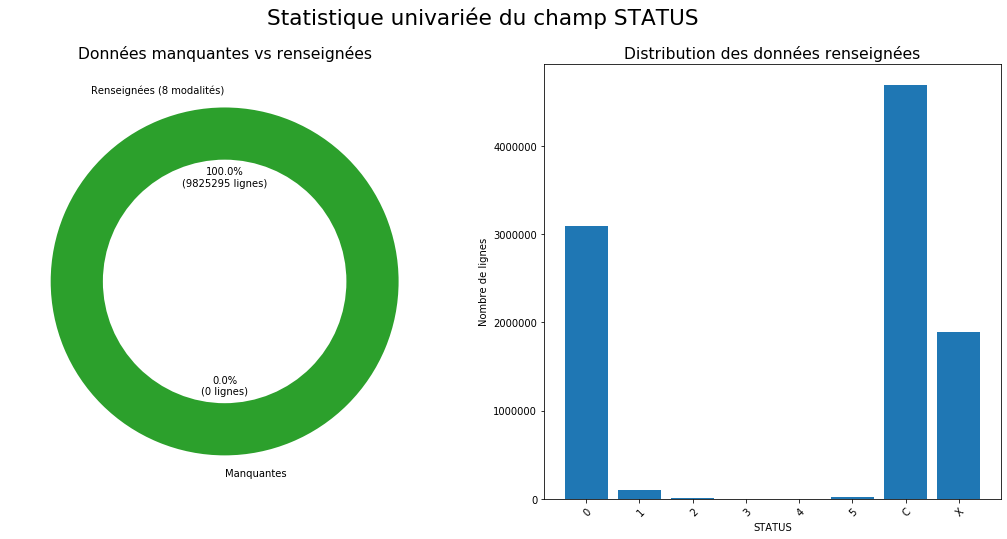

In [142]:
myDf(dfBureauBalance).Stat(['MONTHS_BALANCE','STATUS'], typeStat='univ', statsNan=True)

# Feature engineering

## Feature engineering sur Application Train

### Passage au log de AMT_INCOME_TOTAL

In [ ]:
dfApplicationTrain['AMT_INCOME_TOTAL'] = dfApplicationTrain.apply(lambda x: np.log(x.AMT_INCOME_TOTAL), axis=1)

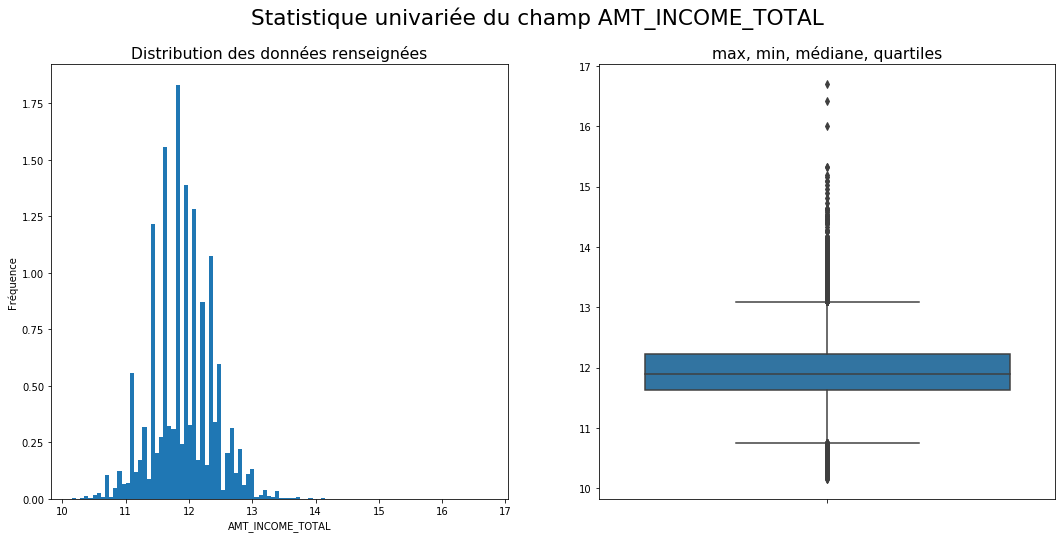

Mesures de position
 - Moyenne: 11.91
 - Médiane: 11.89
Mesures de dispertion
 - Ecart type: 0.49
 - Min: 10.15
 - Q25: 11.63
 - Q75: 12.22
 - Max: 16.71
Mesures de forme
 - Skewness (asymétrie): 0.17
 - Kurtosis (applatissement): 0.67


In [143]:
myDf(dfApplicationTrain).Stat('AMT_INCOME_TOTAL')

## Feature engineering sur des variables communes à Bureau et PreviousApplication

### Days credit et Days decision

In [144]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
dfDays = pd.concat([df1,df2])

In [145]:
dfDays.isnull().any()

SK_ID_CURR       False
SK_ID_PREV       False
DAYS_DECISION    False
dtype: bool

In [146]:
#https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
del dfDays['DAYS_DECISION']
del dfDays['SK_ID_PREV']
dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfDays['DAYS_DIFF'] = dfDays['DAYS_DIFF'].astype(int)

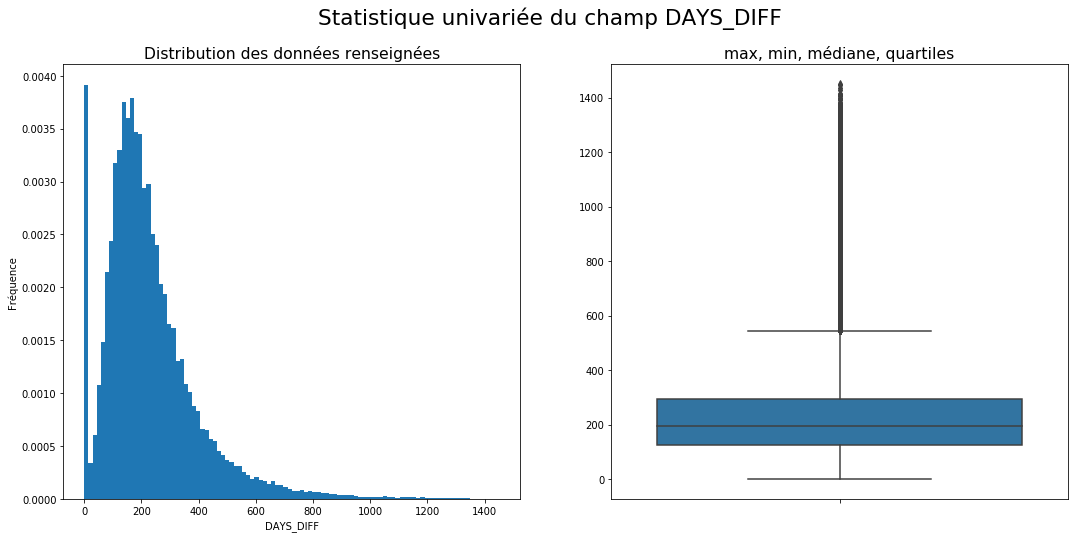

Mesures de position
 - Moyenne: 229.15
 - Médiane: 194.0
Mesures de dispertion
 - Ecart type: 166.55
 - Min: 0
 - Q25: 125.0
 - Q75: 293.0
 - Max: 1451
Mesures de forme
 - Skewness (asymétrie): 1.84
 - Kurtosis (applatissement): 5.8


In [147]:
myDf(dfDays).Stat('DAYS_DIFF')

### Champs amount

#### Création d'une variable montant moyen logarithmique

Passage au log des montants

In [148]:
dfPreviousApplication['AMT_CREDIT_LOG'] = dfPreviousApplication.apply(lambda x: np.log(x.AMT_CREDIT+1), axis=1)
dfBureau['AMT_CREDIT_SUM_LOG'] = dfBureau.apply(lambda x: np.log(x.AMT_CREDIT_SUM+1), axis=1)

Concaténation

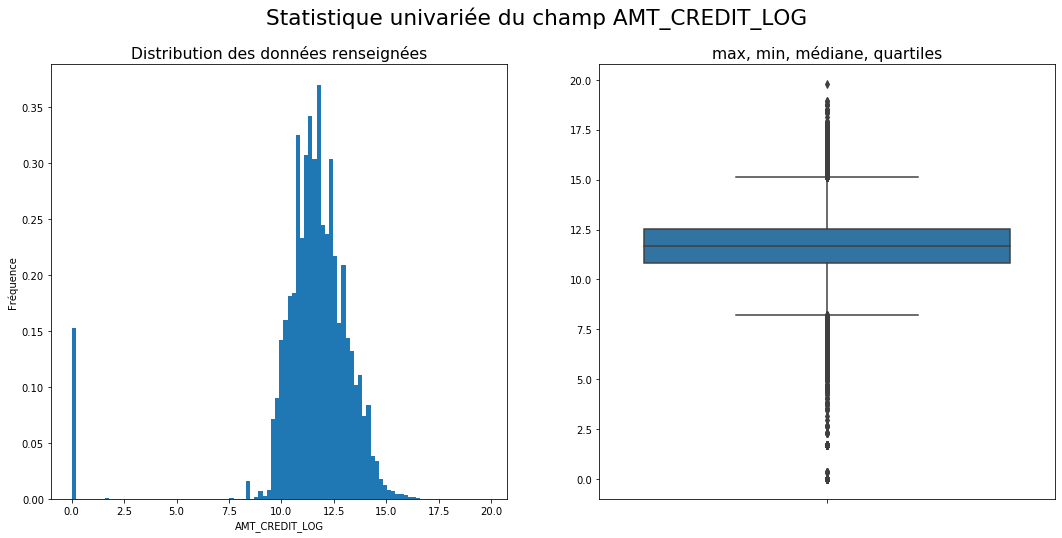

Mesures de position
 - Moyenne: 11.45
 - Médiane: 11.67
Mesures de dispertion
 - Ecart type: 2.36
 - Min: 0.0
 - Q25: 10.81
 - Q75: 12.54
 - Max: 19.8
Mesures de forme
 - Skewness (asymétrie): -3.31
 - Kurtosis (applatissement): 14.13


In [149]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM_LOG']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']]
dfAmtLog = pd.concat([df1,df2])
myDf(dfAmtLog).Stat('AMT_CREDIT_LOG')

Moyenne

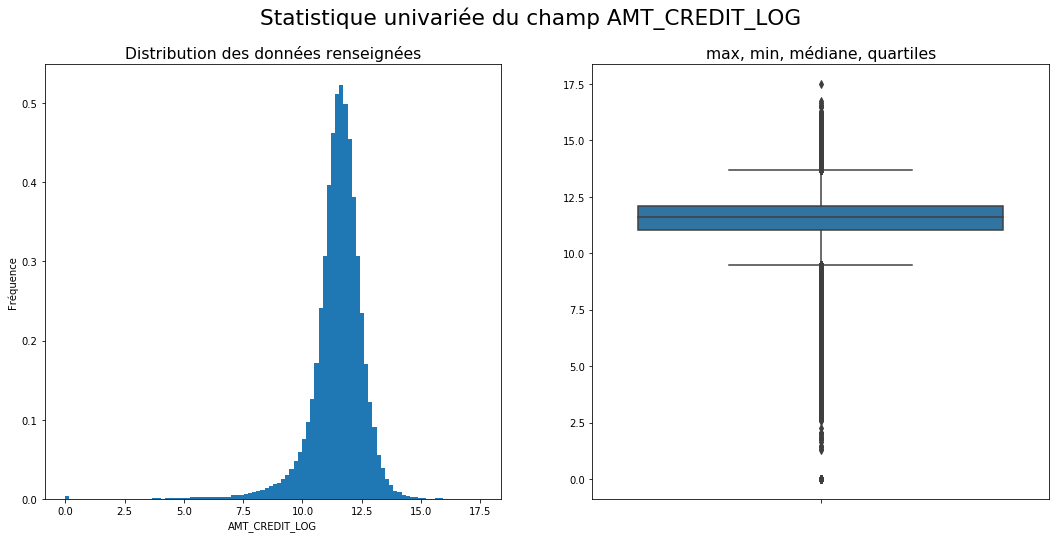

Mesures de position
 - Moyenne: 11.48
 - Médiane: 11.59
Mesures de dispertion
 - Ecart type: 1.1
 - Min: 0.0
 - Q25: 11.05
 - Q75: 12.1
 - Max: 17.5
Mesures de forme
 - Skewness (asymétrie): -2.08
 - Kurtosis (applatissement): 12.98


In [150]:
del dfAmtLog['SK_ID_PREV']
dfAmtLogMean = dfAmtLog.groupby('SK_ID_CURR').mean().reset_index(drop=False)
myDf(dfAmtLogMean).Stat('AMT_CREDIT_LOG')

#### Création d'une variable écart type logarithmique des montants 

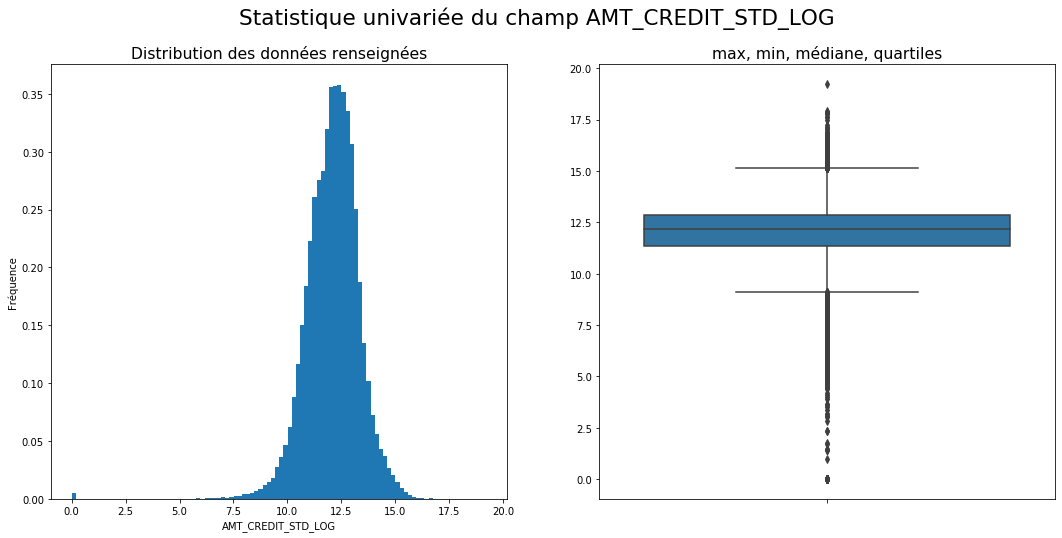

Mesures de position
 - Moyenne: 12.1
 - Médiane: 12.17
Mesures de dispertion
 - Ecart type: 1.24
 - Min: 0.0
 - Q25: 11.36
 - Q75: 12.88
 - Max: 19.25
Mesures de forme
 - Skewness (asymétrie): -1.21
 - Kurtosis (applatissement): 9.69


In [152]:
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']]
dfAmt = pd.concat([df1,df2])
del dfAmt['SK_ID_PREV']
dfAmtStdLog = dfAmt.groupby('SK_ID_CURR').std().reset_index(drop=False).rename(columns = {'AMT_CREDIT': 'AMT_CREDIT_STD'})
dfAmtStdLog['AMT_CREDIT_STD_LOG'] = dfAmtStdLog.apply(lambda x: np.log(1+x.AMT_CREDIT_STD), axis=1)
del dfAmtStdLog['AMT_CREDIT_STD']
myDf(dfAmtStdLog).Stat('AMT_CREDIT_STD_LOG')

#### Visualisation d'une variable écart type des montants logarithmique (non conservée)

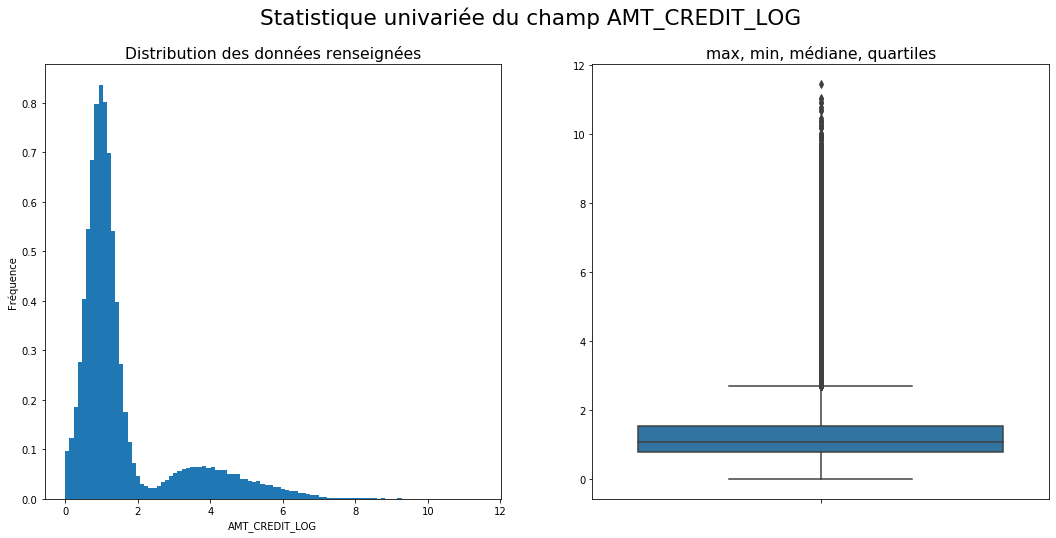

Mesures de position
 - Moyenne: 1.59
 - Médiane: 1.09
Mesures de dispertion
 - Ecart type: 1.43
 - Min: 0.0
 - Q25: 0.78
 - Q75: 1.55
 - Max: 11.45
Mesures de forme
 - Skewness (asymétrie): 1.93
 - Kurtosis (applatissement): 3.35


In [153]:
myDf(dfAmtLog.groupby('SK_ID_CURR').std().reset_index(drop=False)).Stat('AMT_CREDIT_LOG')

## Feature engineering sur PreviousApplication

### Feature engineering sur NAME_SELLER_INDUSTRY

#### NameSellerIndustry avec le plus gros montant cumulé par client

In [207]:
tmp0 = dfPreviousApplication[~dfPreviousApplication.NAME_SELLER_INDUSTRY.isnull()].reset_index(drop=False)
tmp1 = tmp0[['SK_ID_CURR','NAME_SELLER_INDUSTRY','AMT_CREDIT']].groupby(['SK_ID_CURR','NAME_SELLER_INDUSTRY']).sum().reset_index(drop=False)
tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT'], right_on=['SK_ID_CURR','AMT_CREDIT'])
tmp3.head(5)

SK_ID_CURR  NAME_SELLER_INDUSTRY  AMT_CREDIT
0      100002       Auto technology    179055.0
1      100004          Connectivity     20106.0
2      100008  Consumer electronics    773883.0
3      100010             Furniture    260811.0
4      100012          Connectivity     23697.0

Nombre de clients qui ressortent avec plusieurs lignes: on en sélectionne une au hasard

In [208]:
x = tmp3.SK_ID_CURR.value_counts()
len(x[x>1])

31

Pour les clients avec plusieurs seller_industry préférés, on en sélectionne un au hasard en se basant sur l'index

In [209]:
tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
tmp3 = tmp3.reset_index(drop=False)
tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
dfPreviousApplicationMainSellerIndustry = tmp3[['SK_ID_CURR','NAME_SELLER_INDUSTRY']]
dfPreviousApplicationMainSellerIndustry.columns = ['SK_ID_CURR','MAIN_SELLER_INDUSTRY']

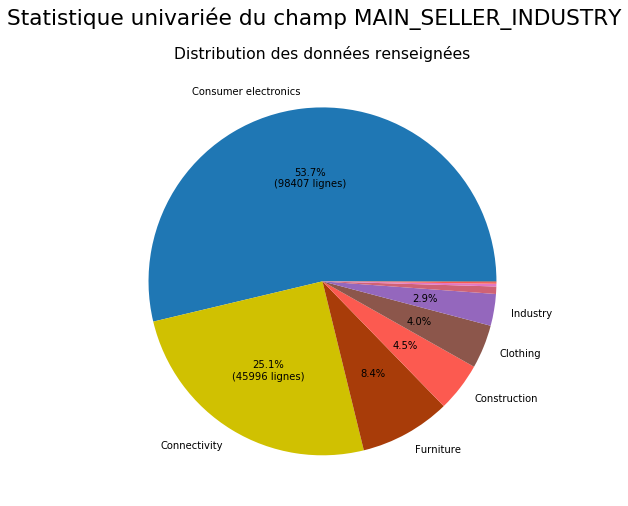

In [210]:
myDf(dfPreviousApplicationMainSellerIndustry).Stat('MAIN_SELLER_INDUSTRY')

#### Nombre de type de seller industry par client

In [211]:
dfPreviousApplicationNbSellerIndustry = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
dfPreviousApplicationNbSellerIndustry.columns = ['SK_ID_CURR','NB_SELLER_INDUSTRY']

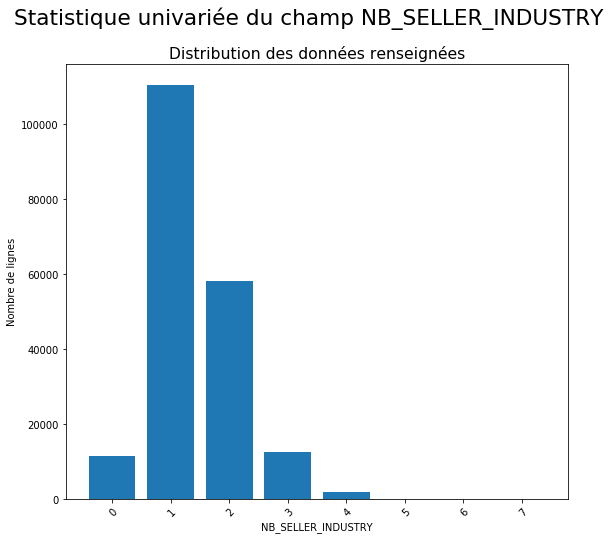

In [212]:
myDf(dfPreviousApplicationNbSellerIndustry).Stat('NB_SELLER_INDUSTRY')

#### Merge avec dfPreviousApplication

In [213]:
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationMainSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationNbSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfPreviousApplication['NAME_SELLER_INDUSTRY']

### Création d'une variable nombre de previous application

In [214]:
dfNbPreviousApplication = pd.DataFrame(dfPreviousApplication.groupby('SK_ID_CURR').size(), columns=['NB_PREVIOUS']).reset_index(drop=False)
dfPreviousApplication = dfPreviousApplication.merge(dfNbPreviousApplication, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

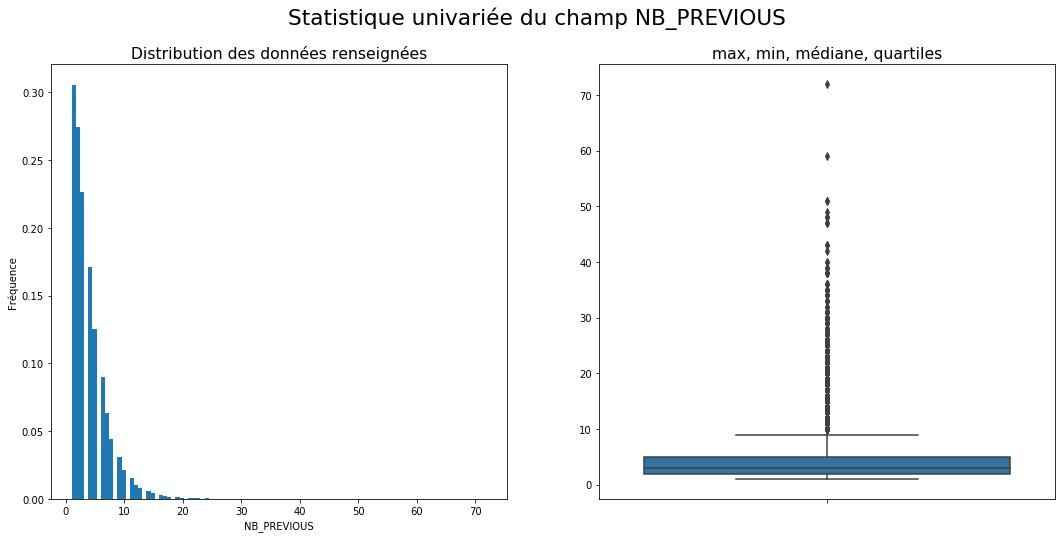

Mesures de position
 - Moyenne: 3.86
 - Médiane: 3.0
Mesures de dispertion
 - Ecart type: 3.1
 - Min: 1
 - Q25: 2.0
 - Q75: 5.0
 - Max: 72
Mesures de forme
 - Skewness (asymétrie): 2.31
 - Kurtosis (applatissement): 11.43


In [215]:
myDf(dfNbPreviousApplication).Stat('NB_PREVIOUS')

## Feature engineering sur Bureau

### Transformation de CREDIT_ACTIVE

On considère que les status Sold et Bad debt correspondent à de crédits actifs (comme dans https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering)

In [216]:
tmp = dfBureau[['CREDIT_ACTIVE','DAYS_CREDIT_ENDDATE']]
tmp = tmp[~tmp.DAYS_CREDIT_ENDDATE.isnull()]
tmp = tmp[tmp.DAYS_CREDIT_ENDDATE != 0]
tmp['DAYS_CREDIT_ENDDATE'] = tmp['DAYS_CREDIT_ENDDATE'] / abs(tmp['DAYS_CREDIT_ENDDATE'])
tmp.groupby(['CREDIT_ACTIVE','DAYS_CREDIT_ENDDATE']).size()

CREDIT_ACTIVE  DAYS_CREDIT_ENDDATE
Active         -1.0                    45488
                1.0                   257546
Bad debt       -1.0                       13
Closed         -1.0                   529440
                1.0                    63282
Sold           -1.0                     2276
                1.0                     1118
dtype: int64

In [217]:
dfBureau['CREDIT_ACTIVE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_ACTIVE == 'Active', 1, 0), axis=1)

### Feature engineering sur CREDIT_TYPE

#### Type de crédit avec le plus gros montant cumulé par client

In [218]:
tmp0 = dfBureau[~dfBureau.CREDIT_TYPE.isnull()].reset_index(drop=False)
tmp1 = tmp0[['SK_ID_CURR','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR','CREDIT_TYPE']).sum().reset_index(drop=False)
tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT_SUM'], right_on=['SK_ID_CURR','AMT_CREDIT_SUM'])
tmp3.head(5)

SK_ID_CURR      CREDIT_TYPE  AMT_CREDIT_SUM
0      100002  Consumer credit      724806.000
1      100004  Consumer credit      189037.800
2      100008  Consumer credit      468445.500
3      100010  Consumer credit      675000.000
4      100014  Consumer credit     2729932.425

Clients qui ressortent avec plusieurs lignes: on en sélectionne une au hasard

In [219]:
x = tmp3.SK_ID_CURR.value_counts()
len(x[x>1])

125

In [220]:
tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
tmp3 = tmp3.reset_index(drop=False)
tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
dfBureauMainCreditType = tmp3[['SK_ID_CURR','CREDIT_TYPE']]
dfBureauMainCreditType.columns = ['SK_ID_CURR','MAIN_CREDIT_TYPE']

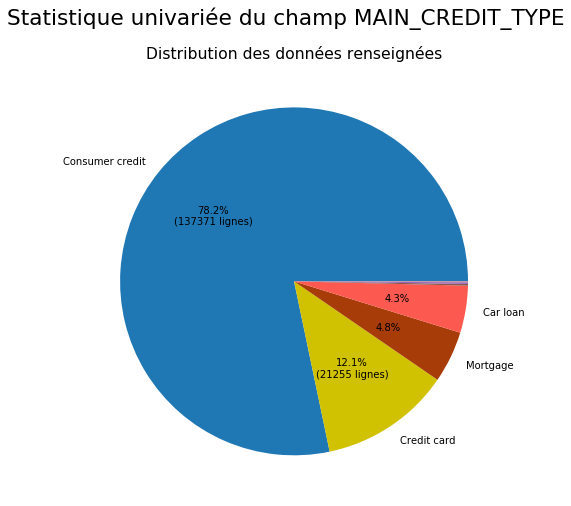

In [221]:
myDf(dfBureauMainCreditType).Stat('MAIN_CREDIT_TYPE')

#### Nombre de type de crédits par client

In [222]:
dfBureauNbCreditType = dfBureau[['SK_ID_CURR','CREDIT_TYPE']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
dfBureauNbCreditType.columns = ['SK_ID_CURR','NB_CREDIT_TYPE']

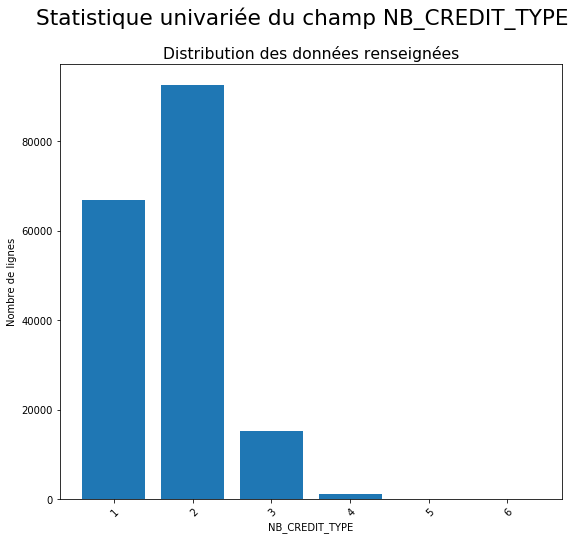

In [223]:
myDf(dfBureauNbCreditType).Stat('NB_CREDIT_TYPE')

#### Merge avec dfBureau

In [224]:
dfBureau = dfBureau.merge(dfBureauMainCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfBureau = dfBureau.merge(dfBureauNbCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfBureau['CREDIT_TYPE']

### Création d'une variable nombre de bureau

In [226]:
dfNbBureau = pd.DataFrame(dfBureau.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU']).reset_index(drop=False)
dfBureau = dfBureau.merge(dfNbBureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

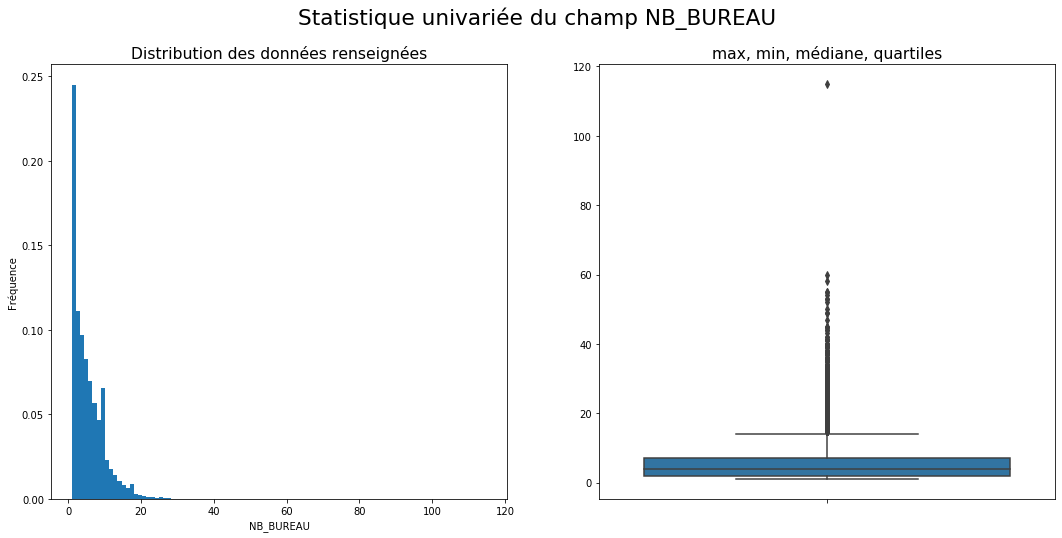

Mesures de position
 - Moyenne: 5.46
 - Médiane: 4.0
Mesures de dispertion
 - Ecart type: 4.31
 - Min: 1
 - Q25: 2.0
 - Q75: 7.0
 - Max: 115
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 7.61


In [248]:
myDf(dfNbBureau).Stat('NB_BUREAU')

## Fearture engineering sur Installment Payment

In [249]:
dfInstallmentsPayments = dfInstallmentsPaymentsOri[(dfInstallmentsPaymentsOri.SK_ID_CURR>175000) & (dfInstallmentsPaymentsOri.SK_ID_CURR<200000)]

In [250]:
dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]

### Nombre d'installment par client

In [251]:
dfInstallmentsPaymentsCount = pd.DataFrame(dfInstallmentsPayments.groupby('SK_ID_CURR').size(), columns=['NB_INSTALLMENT']).reset_index(drop=False)
dfInstallmentsPaymentsCount.head(3)

SK_ID_CURR  NB_INSTALLMENT
0      175001              10
1      175002              29
2      175003              14

### Différence entre les montants et dates effectifs et prévues (positifs et négatifs)

On applique un facteur temporel afin de diminuer l'impact des installments anciens et on sépare les positifs des négatifs

In [253]:
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.DAYS_INSTALMENT - x.DAYS_ENTRY_PAYMENT) / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.AMT_INSTALMENT - x.AMT_PAYMENT)/x.AMT_INSTALMENT / np.sqrt(1-x.DAYS_ENTRY_PAYMENT), axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT>0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0), axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT<0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT>0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0), axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT<0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0), axis=1)

In [255]:
dfInstallmentsPayments = dfInstallmentsPayments[['SK_ID_CURR','DIFF_DAYS_INSTALLMENT_PAYMENT_NEG','DIFF_DAYS_INSTALLMENT_PAYMENT_POS','DIFF_AMT_INSTALLMENT_PAYMENT_NEG','DIFF_AMT_INSTALLMENT_PAYMENT_POS']]

On somme par client

In [256]:
dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').sum().reset_index(drop=False)

On divise par le nombre d'installments

In [257]:
dfInstallmentsPayments = dfInstallmentsPayments.merge(dfInstallmentsPaymentsCount, right_on='SK_ID_CURR', left_on='SK_ID_CURR')
dfInstallmentsPayments

SK_ID_CURR  DIFF_DAYS_INSTALLMENT_PAYMENT_NEG  \
0          175001                           0.000000   
1          175002                          -0.191372   
2          175003                           0.000000   
3          175004                          -1.794636   
4          175005                          -0.524986   
...           ...                                ...   
23787      199995                          -1.124131   
23788      199996                           0.000000   
23789      199997                           0.000000   
23790      199998                          -1.619088   
23791      199999                          -0.149509   

       DIFF_DAYS_INSTALLMENT_PAYMENT_POS  DIFF_AMT_INSTALLMENT_PAYMENT_NEG  \
0                              16.607710                          0.000000   
1                              10.746188                          0.000000   
2                              12.361473                         -0.265709   
3                               3.481881                          0.000000   
4                              19.710058                         -0.454521   
...                                  ...                               ...   
23787                           9.468127                          0.000000   
23788                           1.830655                          0.000000   
23789                          18.622550                          0.000000   
23790                          24.219661                         -0.125952   
23791                          45.987523                          0.000000   

       DIFF_AMT_INSTALLMENT_PAYMENT_POS  NB_INSTALLMENT  
0                              0.000000              10  
1                              0.059083              29  
2                              0.000000              14  
3                              0.068391              14  
4                              0.107899              36  
...                                 ...             ...  
23787                          0.288538              11  
23788                          0.000000               6  
23789                          0.000000              36  
23790                          0.187060             153  
23791                          0.065041             107  

[23792 rows x 6 columns]

In [258]:
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_POS / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_DAYS_INSTALLMENT_PAYMENT_NEG / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_POS / x.NB_INSTALLMENT, axis=1)
dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: x.DIFF_AMT_INSTALLMENT_PAYMENT_NEG / x.NB_INSTALLMENT, axis=1)

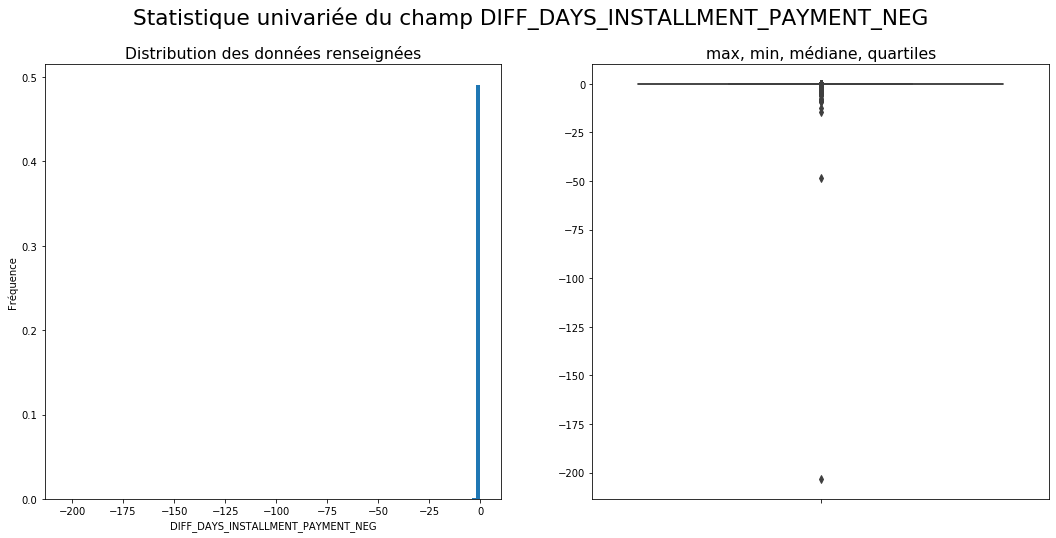

Mesures de position
 - Moyenne: -0.05
 - Médiane: -0.0
Mesures de dispertion
 - Ecart type: 1.38
 - Min: -203.3
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -136.96
 - Kurtosis (applatissement): 19973.11


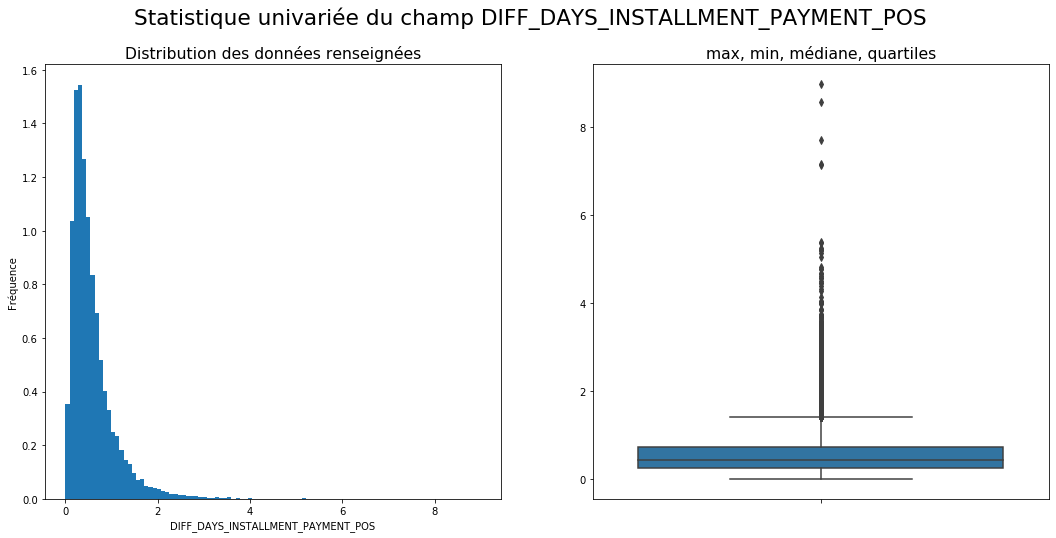

Mesures de position
 - Moyenne: 0.58
 - Médiane: 0.44
Mesures de dispertion
 - Ecart type: 0.5
 - Min: 0.0
 - Q25: 0.26
 - Q75: 0.72
 - Max: 8.99
Mesures de forme
 - Skewness (asymétrie): 3.11
 - Kurtosis (applatissement): 20.32


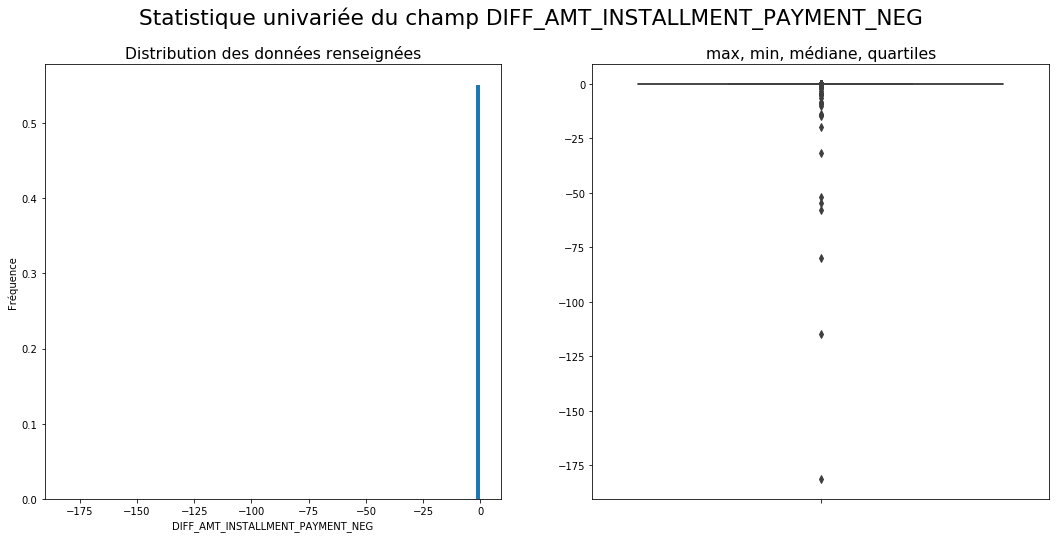

Mesures de position
 - Moyenne: -0.03
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1.64
 - Min: -181.32
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -81.3
 - Kurtosis (applatissement): 7689.17


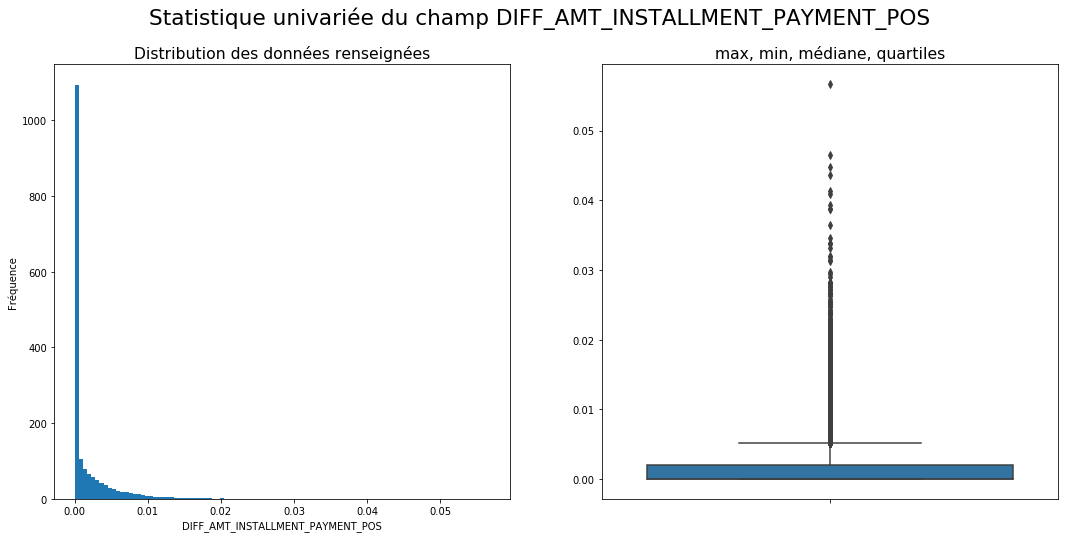

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.06
Mesures de forme
 - Skewness (asymétrie): 3.61
 - Kurtosis (applatissement): 20.69


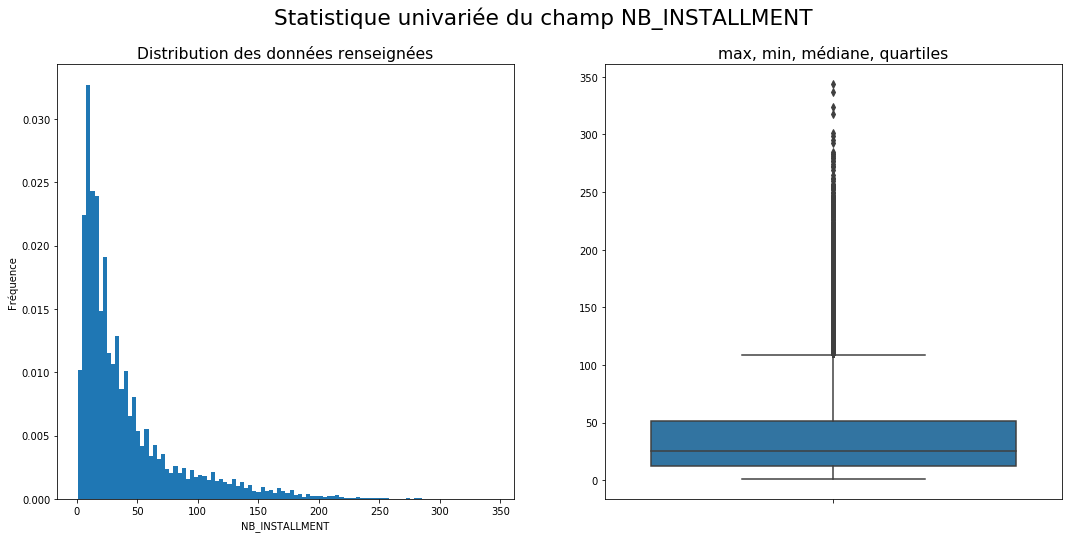

Mesures de position
 - Moyenne: 40.46
 - Médiane: 25.0
Mesures de dispertion
 - Ecart type: 41.98
 - Min: 1
 - Q25: 12.0
 - Q75: 51.0
 - Max: 344
Mesures de forme
 - Skewness (asymétrie): 2.02
 - Kurtosis (applatissement): 4.63


In [259]:
myDf(dfInstallmentsPayments).Stat(exclCol='SK_ID_CURR', typeStat='univ')

## Feature engineering sur Pos Cash Balance

In [260]:
dfPosCashBalanceCount = pd.DataFrame(dfPosCashBalance.groupby('SK_ID_CURR').size(), columns=['NB_POS_CASH_BALANCE']).reset_index(drop=False)
dfPosCashBalanceCount.head(3)

SK_ID_CURR  NB_POS_CASH_BALANCE
0      150001                   12
1      150003                   20
2      150004                   19

In [261]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfPosCashBalance['MONTHS_BALANCE']
del dfPosCashBalance['SK_ID_PREV']

In [262]:
dfPosCashBalance = dfPosCashBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)

In [263]:
dfPosCashBalance = dfPosCashBalance.merge(dfPosCashBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [264]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / x.NB_POS_CASH_BALANCE, axis=1)

In [265]:
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)

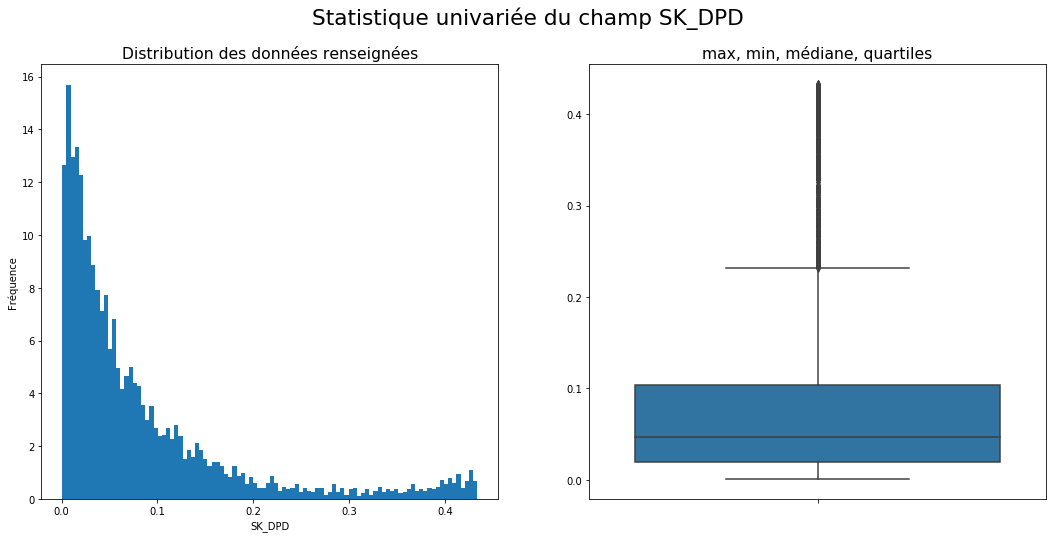

Mesures de position
 - Moyenne: 0.08
 - Médiane: 0.05
Mesures de dispertion
 - Ecart type: 0.1
 - Min: 0.0
 - Q25: 0.02
 - Q75: 0.1
 - Max: 0.43
Mesures de forme
 - Skewness (asymétrie): 2.01
 - Kurtosis (applatissement): 3.7


In [266]:
myDf(dfPosCashBalance[dfPosCashBalance.SK_DPD != 0]).Stat('SK_DPD')

## Feature engineering sur Bureau Balance

#### Création d'une variable iniquant le niveau de DPD (day past due) du client sur Bureau

On récupère le SK_ID_CURR

In [267]:
dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_CURR','SK_ID_BUREAU']], left_on=['SK_ID_BUREAU'], right_on=['SK_ID_BUREAU'])

On compte le nombre de ligne par client

In [268]:
dfBureauBalanceCount = pd.DataFrame(dfBureauBalance.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU_BALANCE']).reset_index(drop=False)
dfBureauBalanceCount.head(3)

SK_ID_CURR  NB_BUREAU_BALANCE
0      100002                110
1      100010                 72
2      100019                 34

On ne conserve que les lignes avec un DPD (day past due) positif

In [269]:
del dfBureauBalance['SK_ID_BUREAU']
dfBureauBalance = dfBureauBalance[dfBureauBalance.STATUS.isin(['1','2','3','4','5'])]
dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype('int')

On applique un facteur temporel afin de diminuer l'impact des DPD anciens

In [270]:
dfBureauBalance['STATUS_DPD'] = dfBureauBalance.apply(lambda x: x.STATUS / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
del dfBureauBalance['STATUS']
del dfBureauBalance['MONTHS_BALANCE']

On somme par SK_ID_CURR

In [271]:
dfBureauDPD = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)[['SK_ID_CURR','STATUS_DPD']]

On divise par le nombre de lignes

In [272]:
dfBureauDPD = dfBureauDPD.merge(dfBureauBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
#dfBureauDPD['STATUS_DPD'] = dfBureauDPD.apply(lambda x: x.STATUS_DPD / x.NB_BUREAU_BALANCE, axis=1)

On ajoute les SK_ID_CURR sans DPD

In [273]:
dfBureauNoDPD = myDf(dfBureau).WhereNotExists(dfBureauDPD, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])[['SK_ID_CURR']].drop_duplicates()
dfBureauNoDPD['STATUS_DPD'] = 0

In [274]:
dfBureauDPD = pd.concat([dfBureauDPD,dfBureauNoDPD])

/home/pierre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


On passe au log

In [275]:
dfBureauDPD['STATUS_DPD'] = dfBureauDPD.apply(lambda x: np.log(1+x.STATUS_DPD), axis=1)

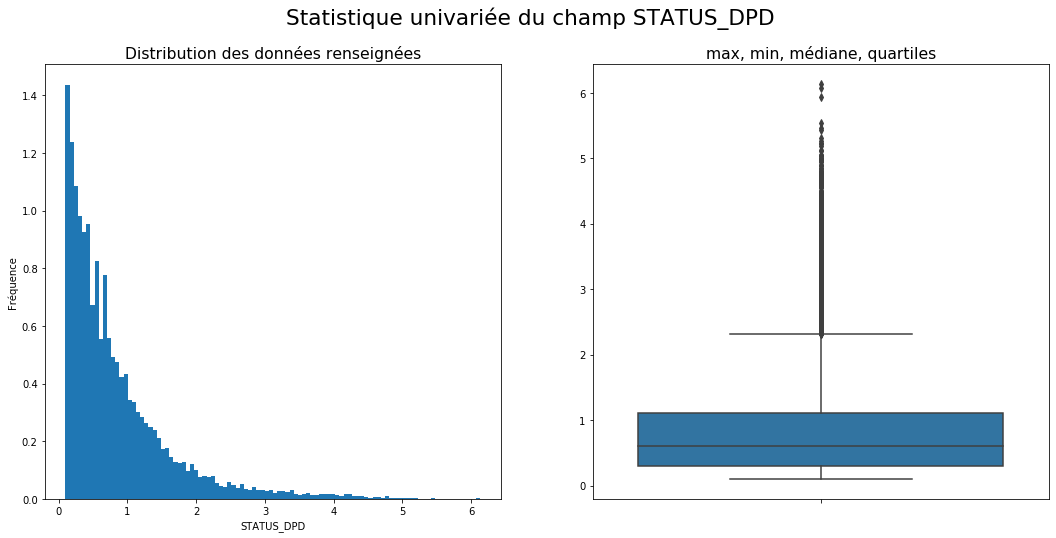

Mesures de position
 - Moyenne: 0.85
 - Médiane: 0.6
Mesures de dispertion
 - Ecart type: 0.79
 - Min: 0.1
 - Q25: 0.3
 - Q75: 1.11
 - Max: 6.14
Mesures de forme
 - Skewness (asymétrie): 2.04
 - Kurtosis (applatissement): 5.13


In [276]:
myDf(dfBureauDPD[dfBureauDPD.STATUS_DPD>0]).Stat('STATUS_DPD')

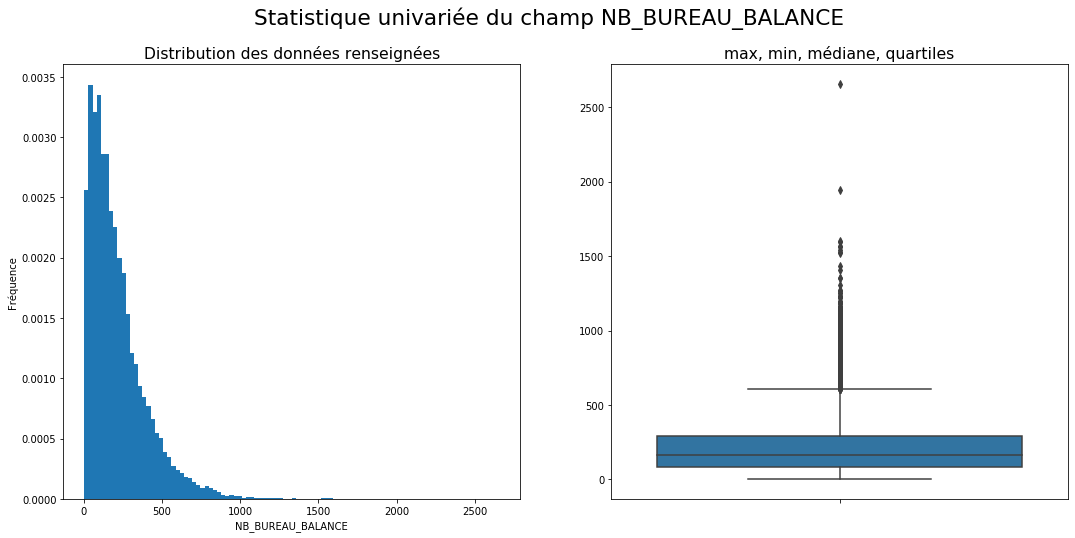

Mesures de position
 - Moyenne: 215.18
 - Médiane: 167.0
Mesures de dispertion
 - Ecart type: 181.91
 - Min: 2.0
 - Q25: 83.0
 - Q75: 293.0
 - Max: 2657.0
Mesures de forme
 - Skewness (asymétrie): 1.8
 - Kurtosis (applatissement): 5.96


In [277]:
myDf(dfBureauDPD).Stat('NB_BUREAU_BALANCE')

# Transformation de dfBureau et dfPreviousApplication en un dataframe avec une ligne par SK_ID_CURR

## Transformation de dfPreviousApplication

In [114]:
del dfPreviousApplication['SK_ID_PREV']
dfPreviousApplicationCat = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates()
dfPreviousApplicationNum = dfPreviousApplication.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfPreviousApplication = dfPreviousApplicationNum.merge(dfPreviousApplicationCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR')
dfPreviousApplication

SK_ID_CURR  AMT_CREDIT  RATE_DOWN_PAYMENT  DAYS_DECISION  \
0           100002  179055.000           0.000000       -606.000   
1           100004   20106.000           0.212008       -815.000   
2           100008  203459.625           0.073051      -1469.500   
3           100010  260811.000           0.000000      -1070.000   
4           100012   98826.000           0.000000      -1004.000   
...            ...         ...                ...            ...   
194718      456251   40455.000           0.000000       -273.000   
194719      456252   56821.500           0.062443      -2497.000   
194720      456253   20625.750           0.214316      -2380.000   
194721      456254  134439.750           0.000000       -299.500   
194722      456255  424431.000           0.064780       -587.625   

        NFLAG_INSURED_ON_APPROVAL  NAME_YIELD_GROUP_ENCODED  \
0                        0.000000                      1.00   
1                        0.000000                      2.00   
2                        0.250000                      1.25   
3                        0.000000                      1.00   
4                        0.666667                      3.00   
...                           ...                       ...   
194718                   0.000000                      3.00   
194719                   1.000000                      1.00   
194720                   0.500000                      3.00   
194721                   0.500000                      2.00   
194722                   0.333333                      2.00   

        NAME_CONTRACT_STATUS_ENCODED  X_SELL  NB_PREVIOUS  \
0                               1.00     0.0          1.0   
1                               1.00     0.0          1.0   
2                               1.00     1.0          4.0   
3                               1.00     0.0          1.0   
4                               1.00     1.0          3.0   
...                              ...     ...          ...   
194718                          1.00     0.0          1.0   
194719                          1.00     0.0          1.0   
194720                          1.00     0.0          2.0   
194721                          1.00     0.0          2.0   
194722                          0.75     1.0          8.0   

        NAME_SELLER_INDUSTRY  
0            Auto technology  
1               Connectivity  
2       Consumer electronics  
3                  Furniture  
4               Connectivity  
...                      ...  
194718          Connectivity  
194719  Consumer electronics  
194720          Connectivity  
194721  Consumer electronics  
194722          Connectivity  

[194723 rows x 10 columns]

## Transformation de dfBureau

### On isole les variables catégorielles

In [296]:
categorical_ix = list(dfBureau.select_dtypes(include=['object', 'bool']).columns)
cols = ['SK_ID_CURR']
cols.extend(categorical_ix)
dfBureauCat = dfBureau[cols].drop_duplicates()

### On moyenne les variables numériques

In [294]:
del dfBureau['SK_ID_BUREAU']
dfBureauNum = dfBureau.groupby('SK_ID_CURR').mean().reset_index(drop=False)

### Merge des variables numériques et catégorielles

In [297]:
dfBureau = dfBureauNum.merge(dfBureauCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR')
dfBureau

SK_ID_CURR  CREDIT_ACTIVE  DAYS_CREDIT  DAYS_CREDIT_ENDDATE  \
0           100002       0.250000  -874.000000          -349.000000   
1           100004       0.000000  -867.000000          -488.500000   
2           100008       0.333333  -757.333333          -391.333333   
3           100010       0.500000 -1939.500000          -119.500000   
4           100014       0.250000 -1095.375000          -387.375000   
...            ...            ...          ...                  ...   
175662      456246       0.333333 -1361.000000          -234.666667   
175663      456249       0.153846 -1667.076923         -1232.333333   
175664      456253       0.500000  -867.500000           280.500000   
175665      456254       0.000000 -1104.000000          -859.000000   
175666      456255       0.400000 -1160.600000           822.400000   

        AMT_CREDIT_SUM  NB_CREDIT_TYPE MAIN_CREDIT_TYPE  
0             9.811994             2.0  Consumer credit  
1            11.456566             1.0  Consumer credit  
2            11.842916             1.0  Consumer credit  
3            13.041400             2.0  Consumer credit  
4            12.207262             1.0  Consumer credit  
...                ...             ...              ...  
175662       11.617111             2.0  Consumer credit  
175663       12.218622             3.0  Consumer credit  
175664       13.566311             2.0  Consumer credit  
175665       10.714440             1.0  Consumer credit  
175666       12.043499             2.0  Consumer credit  

[175667 rows x 7 columns]